# Catastrophic Forgetting Results Notebook<a name='top'/>

This notebook contains the data analysis tools and products for all the experiments associated with this project.

## Table of Contents

<a href=#setup>Setup</a>

<a href=#experiment_1_mnist>Experiment 1 MNIST</a>
> <a href=#experiment_1_mnist_validation>Validation Phase</a><br><br>
> <a href=#experiment_1_mnist_testing>Testing Phase</a><br><br>
>> <a href=#experiment_1_mnist_testing_hypothesis>Statistical Hypothesis Testing</a><br><br>
>> <a href=#experiment_1_mnist_testing_plotting>Plotting</a>

<a href=#experiment_2_mnist>Experiment 2 MNIST</a>
> <a href=#experiment_2_mnist_validation>Validation Phase</a><br><br>
> <a href=#experiment_2_mnist_testing>Testing Phase</a>

<a href=#experiment_2_mountain_car>Experiment 2 Mountain Car</a>
> <a href=#experiment_2_mountain_car_validation>Validation Phase</a><br><br>
> <a href=#experiment_2_mountain_car_testing>Testing Phase</a>

<a href=#experiment_2_acrobot>Experiment 2 Acrobot</a>
> <a href=#experiment_2_acrobot_validation>Validation Phase</a><br><br>
> <a href=#experiment_2_acrobot_testing>Testing Phase</a>

## Setup <a name='setup'/>

In [1]:
import collections
import copy
import json
import matplotlib.pyplot as plt
import mnist.tools as mnist_tools
import mountain_car.tools as mc_tools
import acrobot.tools as ac_tools
import numpy as np
import pandas as pd
import scipy.stats as st
import seaborn as sns

from matplotlib import rc
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle
from statsmodels.stats.multicomp import MultiComparison

# setup matplotlib
%matplotlib inline
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_style('ticks')
sns.set_context('notebook')

# setup dict for specifying nice names for legends
optimizer_nice_names = {
    'constant': 'Constant',
    'adam': 'Adam',
    'momentum': 'Momentum',
    'rms': 'RMSProp',
    'sgd': 'SGD'}

<a href=#top>Back to Top</a>

## Experiment 1 MNIST<a name='experiment_1_mnist'/>

### Validation Phase<a name='experiment_1_mnist_validation'/>

In [2]:
rdf = mnist_tools.load_data(['experiment_1_mnist_validation.json'])
rdf = rdf[rdf['success']]
E12 = ((1, 2), (3, 4))
E34 = ((3, 4), (1, 2))
E1234 = ((1, 2, 3, 4), (1, 2), (3, 4))

E12_best = mnist_tools.get_best(
    mnist_tools.get_summary(rdf[rdf['phases'] == E12]),
    mnist_tools.phase_time_metric(2, 50, 2500))
E34_best = mnist_tools.get_best(
    mnist_tools.get_summary(rdf[rdf['phases'] == E34]),
    mnist_tools.phase_time_metric(2, 50, 2500))
E1234_best = mnist_tools.get_best(
    mnist_tools.get_summary(rdf[rdf['phases'] == E1234]),
    mnist_tools.phase_time_metric(1, 50, 2500))
print('{}: lr={}, count={}'.format(
    'E12',
    E12_best['lr'],
    int(E12_best['count'][0])))
print('{}: lr={}, count={}'.format(
    'E34',
    E34_best['lr'],
    int(E34_best['count'][0])))
print('{}: lr={}, count={}'.format(
    'E1234',
    E1234_best['lr'],
    int(E1234_best['count'][0])))

E12: lr=0.0625, count=50
E34: lr=0.0625, count=50
E1234: lr=0.03125, count=50


<a href=#top>Back to Top</a>

### Testing Phase<a name='experiment_1_mnist_testing'/>

In [3]:
rdf = mnist_tools.load_data(['experiment_1_mnist_test.json'])
rdf = rdf[rdf['success']]
E12 = ((1, 2), (3, 4), (1, 2), (3, 4))
E34 = ((3, 4), (1, 2), (3, 4), (1, 2))
E1234 = ((1, 2, 3, 4), (1, 2), (3, 4))
ER = ((1, 2), (3, 4), (1, 2), (3, 4), (1, 2), (3, 4), (1, 2), (3, 4))

<a href=#top>Back to Top</a>

#### Statistical Hypothesis Testing<a name='experiment_1_mnist_testing_hypothesis'/>

In [4]:
text = ''

# H1
accuracies = list()
for k,v in rdf[rdf['phases'] == E12].iterrows():
    accuracies.append(v['accuracies'][v['phase_length'][0] - 1][0])
h1_t, h1_p = st.ttest_1samp(accuracies, 0.9)
h1_p = h1_p / 2
text += 'H1: {} with p {}\n'.format(
    'Reject' if (h1_p < 0.01 / 11) and (h1_t >= 0) else 'Fail to Reject',
    '= {0:.4f}'.format(h1_p) if abs(h1_p) >= 1e-4 else '< 0.0001')

# H2
accuracies = list()
for k,v in rdf[rdf['phases'] == E12].iterrows():
    accuracies.append(v['accuracies'][v['phase_length'][0] + v['phase_length'][1] - 1][1])
h2_t, h2_p = st.ttest_1samp(accuracies, 0.9)
h2_p = h2_p / 2
text += 'H2: {} with p {}\n'.format(
    'Reject' if (h2_p < 0.01 / 11) and (h2_t >= 0) else 'Fail to Reject',
    '= {0:.4f}'.format(h2_p) if abs(h2_p) >= 1e-4 else '< 0.0001')

# H3
accuracies = list()
for k,v in rdf[rdf['phases'] == E1234].iterrows():
    accuracies.append(v['accuracies'][v['phase_length'][0] - 1][1])
h3_t, h3_p = st.ttest_1samp(accuracies, 0.9)
h3_p = h3_p / 2
text += 'H3: {} with p {}\n'.format(
    'Reject' if (h3_p < 0.01 / 11) and (h3_t >= 0) else 'Fail to Reject',
    '= {0:.4f}'.format(h3_p) if abs(h3_p) >= 1e-4 else '< 0.0001')

# H4
accuracies = list()
for k,v in rdf[rdf['phases'] == E1234].iterrows():
    accuracies.append(v['accuracies'][v['phase_length'][0] - 1][2])
h4_t, h4_p = st.ttest_1samp(accuracies, 0.9)
h4_p = h4_p / 2
text += 'H4: {} with p {}\n'.format(
    'Reject' if (h4_p < 0.01 / 11) and (h4_t >= 0) else 'Fail to Reject',
    '= {0:.4f}'.format(h4_p) if abs(h4_p) >= 1e-4 else '< 0.0001')

# H5
accuracies = list()
for k,v in rdf[rdf['phases'] == E12].iterrows():
    accuracies.append(v['accuracies'][v['phase_length'][0] + v['phase_length'][1] - 1][0])
h5_t, h5_p = st.ttest_1samp(accuracies, 0.9)
h5_p = h5_p / 2
text += 'H5: {} with p {}\n'.format(
    'Reject' if (h5_p < 0.01 / 11) and (h5_t < 0) else 'Fail to Reject',
    '= {0:.4f}'.format(h5_p) if abs(h5_p) >= 1e-4 else '< 0.0001')

# H6
accuracies = list()
for k,v in rdf[rdf['phases'] == E34].iterrows():
    accuracies.append(v['accuracies'][v['phase_length'][0] - 1][0])
h6_t, h6_p = st.ttest_1samp(accuracies, 0.9)
h6_p = h6_p / 2
text += 'H6: {} with p {}\n'.format(
    'Reject' if (h6_p < 0.01 / 11) and (h6_t >= 0) else 'Fail to Reject',
    '= {0:.4f}'.format(h6_p) if abs(h6_p) >= 1e-4 else '< 0.0001')

# H7
accuracies = list()
for k,v in rdf[rdf['phases'] == E34].iterrows():
    accuracies.append(v['accuracies'][v['phase_length'][0] + v['phase_length'][1] - 1][1])
h7_t, h7_p = st.ttest_1samp(accuracies, 0.9)
h7_p = h7_p / 2
text += 'H7: {} with p {}\n'.format(
    'Reject' if (h7_p < 0.01 / 11) and (h7_t >= 0) else 'Fail to Reject',
    '= {0:.4f}'.format(h7_p) if abs(h7_p) >= 1e-4 else '< 0.0001')

# H8
accuracies = list()
for k,v in rdf[rdf['phases'] == E34].iterrows():
    accuracies.append(v['accuracies'][v['phase_length'][0] + v['phase_length'][1] - 1][0])
h8_t, h8_p = st.ttest_1samp(accuracies, 0.9)
h8_p = h8_p / 2
text += 'H8: {} with p {}\n'.format(
    'Reject' if (h8_p < 0.01 / 11) and (h8_t < 0) else 'Fail to Reject',
    '= {0:.4f}'.format(h8_p) if abs(h8_p) >= 1e-4 else '< 0.0001')

# H9
P1_time = list()
for k,v in rdf[rdf['phases'] == E12].iterrows():
    P1_time.append(v['phase_length'][0])
P3_time = list()
for k,v in rdf[rdf['phases'] == E12].iterrows():
    P3_time.append(v['phase_length'][2])
h9_t, h9_p = st.ttest_ind(P1_time, P3_time)
h9_p = h9_p / 2
text += 'H9: {} with p {}\n'.format(
    'Reject' if (h9_p < 0.01 / 11) and (h9_t > 0) else 'Fail to Reject',
    '= {0:.4f}'.format(h9_p) if abs(h9_p) >= 1e-4 else '< 0.0001')

# H10
P2_time = list()
for k,v in rdf[rdf['phases'] == E12].iterrows():
    P2_time.append(v['phase_length'][1])
P4_time = list()
for k,v in rdf[rdf['phases'] == E12].iterrows():
    P4_time.append(v['phase_length'][3])
h10_t, h10_p = st.ttest_ind(P2_time, P4_time)
h10_p = h10_p / 2
text += 'H10: {} with p {}\n'.format(
    'Reject' if (h10_p < 0.01 / 11) and (h10_t > 0) else 'Fail to Reject',
    '= {0:.4f}'.format(h10_p) if abs(h10_p) >= 1e-4 else '< 0.0001')

# H11
E1234_time = list()
for k,v in rdf[rdf['phases'] == E1234].iterrows():
    E1234_time.append(v['phase_length'][0])
E12_time = list()
for k,v in rdf[rdf['phases'] == E12].iterrows():
    E12_time.append(v['phase_length'][0] + v['phase_length'][1])
h11_t, h11_p = st.ttest_ind(E1234_time, E12_time)
text += 'H11: {} with p {}\n'.format(
    'Reject' if (h11_p < 0.01 / 11) else 'Fail to Reject',
    '= {0:.4f}'.format(h11_p) if abs(h11_p) >= 1e-4 else '< 0.0001')

with open('experiment_1_hypotheses.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

H1: Reject with p < 0.0001
H2: Reject with p < 0.0001
H3: Reject with p < 0.0001
H4: Reject with p < 0.0001
H5: Reject with p < 0.0001
H6: Reject with p < 0.0001
H7: Reject with p < 0.0001
H8: Reject with p < 0.0001
H9: Reject with p < 0.0001
H10: Reject with p < 0.0001
H11: Reject with p < 0.0001



<a href=#top>Back to Top</a>

#### Plotting<a name='experiment_1_mnist_testing_plotting'/>

In [5]:
max_phase_lengths = list()
for _, row in rdf.iterrows():
    for i, l in enumerate(row['phase_length']):
        if len(max_phase_lengths) == i:
            max_phase_lengths.append(0)
        max_phase_lengths[i] = max(max_phase_lengths[i], l)
data = dict()
for k in rdf['phases'].unique():
    data[k] = dict()
    for k2 in ['d1_count',
               'd2_count']:
        data[k][k2] = [np.zeros(i, dtype=int) for i in max_phase_lengths]
    for k2 in ['d1_avg',
               'd1_sec',
               'd1_min',
               'd1_max',
               'd2_avg',
               'd2_sec',
               'd2_min',
               'd2_max']:
        data[k][k2] = [np.zeros(i, dtype=float) for i in max_phase_lengths]
    data[k]['phase_lengths'] = [list() for i in max_phase_lengths]
    for i in range(len(max_phase_lengths)):
        data[k]['d1_min'][i] += 1
        data[k]['d2_min'][i] += 1

    kdf = rdf[rdf['phases'] == k]
    for _, row in kdf.iterrows():
        j = 0
        for i, l in enumerate(row['phase_length']):
            data[k]['phase_lengths'][i].append(l)

            if k == E1234:
                d1_index = 1
                d2_index = 2
            elif k == E12:
                d1_index = 0
                d2_index = 1
            elif k == E34:
                d1_index = 1
                d2_index = 0
            else:
                assert k == ER
                d1_index = 0
                d2_index = 1
            
            values = np.array(row['accuracies'])[j:j + l, d1_index]
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['d1_avg'][i][mask]
            data[k]['d1_count'][i][mask] += 1
            data[k]['d1_avg'][i][mask] += delta / data[k]['d1_count'][i][mask]
            data[k]['d1_sec'][i][mask] += delta * (values - data[k]['d1_avg'][i][mask])
            data[k]['d1_min'][i][mask] = np.minimum(data[k]['d1_min'][i][mask], values)
            data[k]['d1_max'][i][mask] = np.maximum(data[k]['d1_max'][i][mask], values)

            values = np.array(row['accuracies'])[j:j + l, d2_index]
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['d2_avg'][i][mask]
            data[k]['d2_count'][i][mask] += 1
            data[k]['d2_avg'][i][mask] += delta / data[k]['d2_count'][i][mask]
            data[k]['d2_sec'][i][mask] += delta * (values - data[k]['d2_avg'][i][mask])
            data[k]['d2_min'][i][mask] = np.minimum(data[k]['d2_min'][i][mask], values)
            data[k]['d2_max'][i][mask] = np.maximum(data[k]['d2_max'][i][mask], values)

            j += l
    data[k]['d1_sem'] = list()
    data[k]['d2_sem'] = list()
    for i in range(len(max_phase_lengths)):
        data[k]['d1_sem'].append(np.nan_to_num(np.sqrt(data[k]['d1_sec'][i]) / data[k]['d1_count'][i]))
        data[k]['d2_sem'].append(np.nan_to_num(np.sqrt(data[k]['d2_sec'][i]) / data[k]['d2_count'][i]))
    del data[k]['d1_sec']
    del data[k]['d2_sec']

/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in true_divide


In [6]:
experiments = [E12, E34, E1234]
phase_lengths = [{experiment: list() for experiment in experiments} for i in range(max([len(v) for v in experiments]))]
for _, row in rdf.iterrows():
    if row['phases'] not in experiments:
        continue
    for i in range(len(row['phases'])):
        phase_lengths[i][row['phases']].append(row['phase_length'][i])

text = ''
text += '|------------|-------------------|------------------|------------------|------------------|\n'
text += '| Experiment | Steps in Phase 1  | Steps in Phase 2 | Steps in Phase 3 | Steps in Phase 4 |\n'
text += '|------------|-------------------|------------------|------------------|------------------|\n'
for experiment, experiment_name in zip(experiments, ['E12', 'E34', 'E1234']):
    text += '| {0:>10} |   {1:>7.2f}+-{2:<4.2f}   |'.format(
        experiment_name,
        np.mean(phase_lengths[0][experiment]), np.std(phase_lengths[0][experiment]) / np.sqrt(len(phase_lengths[0][experiment])))
    if experiment in [E12, E34]:
        text += '   {0:>6.2f}+-{1:<4.2f}   |   {2:>5.2f}+-{3:<4.2f}    |   {4:>5.2f}+-{5:<4.2f}    |\n'.format(
            np.mean(phase_lengths[1][experiment]), np.std(phase_lengths[1][experiment]) / np.sqrt(len(phase_lengths[1][experiment])),
            np.mean(phase_lengths[2][experiment]), np.std(phase_lengths[2][experiment]) / np.sqrt(len(phase_lengths[2][experiment])),
            np.mean(phase_lengths[3][experiment]), np.std(phase_lengths[3][experiment]) / np.sqrt(len(phase_lengths[3][experiment])))
    else:
        assert(experiment == E1234)
        text += '       N/A        |       N/A        |       N/A        |\n'
text += '|------------|-------------------|------------------|------------------|------------------|'
with open('experiment_1_speed.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|------------|-------------------|------------------|------------------|------------------|
| Experiment | Steps in Phase 1  | Steps in Phase 2 | Steps in Phase 3 | Steps in Phase 4 |
|------------|-------------------|------------------|------------------|------------------|
|        E12 |    116.87+-2.64   |   123.38+-2.05   |   48.80+-1.46    |   35.27+-1.33    |
|        E34 |    105.70+-2.47   |   142.50+-2.44   |   47.18+-1.37    |   35.23+-1.32    |
|      E1234 |   1041.06+-9.63   |       N/A        |       N/A        |       N/A        |
|------------|-------------------|------------------|------------------|------------------|


In [7]:
experiments = [E12, E34]
accuracies = {experiment: [[list() for j in range(2)] for i in range(4)] for experiment in experiments}
for _, row in rdf.iterrows():
    if row['phases'] not in experiments:
        continue
    for i in range(4):
        for j in range(2):
            accuracies[row['phases']][i][j].append(row['accuracies'][sum(row['phase_length'][:i + 1]) - 1][j])
text = ''
text += '|------------|-------|-------------------|-------------------|\n'
text += '| Experiment | Phase | Accuracy on 1 + 2 | Accuracy on 3 + 4 |\n'
text += '|------------|-------|-------------------|-------------------|\n'
for experiment, experiment_name in zip(experiments, ['E12', 'E34', 'E1234']):
    for phase in range(4):
        if (experiment != E12) and (phase == 0):
            text += '|------------|-------|-------------------|-------------------|\n'
        text += '| {0:>10} |   {1}   |  {2:>6.4f}+-{3:<6.4f}   |  {4:>6.4f}+-{5:<6.4f}   |\n'.format(
            experiment_name if phase == 1 else '',
            phase,
            np.mean(accuracies[experiment][phase][0]), np.std(accuracies[experiment][phase][0]) / np.sqrt(len(accuracies[experiment][phase][0])),
            np.mean(accuracies[experiment][phase][1]), np.std(accuracies[experiment][phase][1]) / np.sqrt(len(accuracies[experiment][phase][1])))
text += '|------------|-------|-------------------|-------------------|\n'
with open('experiment_1_retention.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|------------|-------|-------------------|-------------------|
| Experiment | Phase | Accuracy on 1 + 2 | Accuracy on 3 + 4 |
|------------|-------|-------------------|-------------------|
|            |   0   |  0.9558+-0.0030   |  0.0000+-0.0000   |
|        E12 |   1   |  0.0814+-0.0053   |  0.9707+-0.0011   |
|            |   2   |  0.9636+-0.0021   |  0.2411+-0.0088   |
|            |   3   |  0.4907+-0.0095   |  0.9584+-0.0019   |
|------------|-------|-------------------|-------------------|
|            |   0   |  0.9575+-0.0031   |  0.0000+-0.0000   |
|        E34 |   1   |  0.0294+-0.0023   |  0.9706+-0.0011   |
|            |   2   |  0.9680+-0.0009   |  0.3652+-0.0090   |
|            |   3   |  0.3944+-0.0121   |  0.9460+-0.0035   |
|------------|-------|-------------------|-------------------|



In [8]:
experiments = [E12, E34]
ratios = {experiment: list() for experiment in experiments}
for _, row in rdf.iterrows():
    if row['phases'] not in experiments:
        continue
    ratios[row['phases']].append(row['phase_length'][0] / row['phase_length'][2])

text = ''
text += '|------------|------------|\n'
text += '| Experiment | Relearning |\n'
text += '|------------|------------|\n'
for experiment, experiment_name in zip(experiments, ['E12', 'E34']):
    text += '| {0:>10} | {1:>4.2f}+-{2:<4.2f} |\n'.format(
        experiment_name,
        np.mean(ratios[experiment]),
        np.std(ratios[experiment]) / np.sqrt(len(ratios[experiment])))
text += '|------------|------------|\n'
with open('experiment_1_relearning.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|------------|------------|
| Experiment | Relearning |
|------------|------------|
|        E12 | 4.15+-0.19 |
|        E34 | 3.57+-0.16 |
|------------|------------|



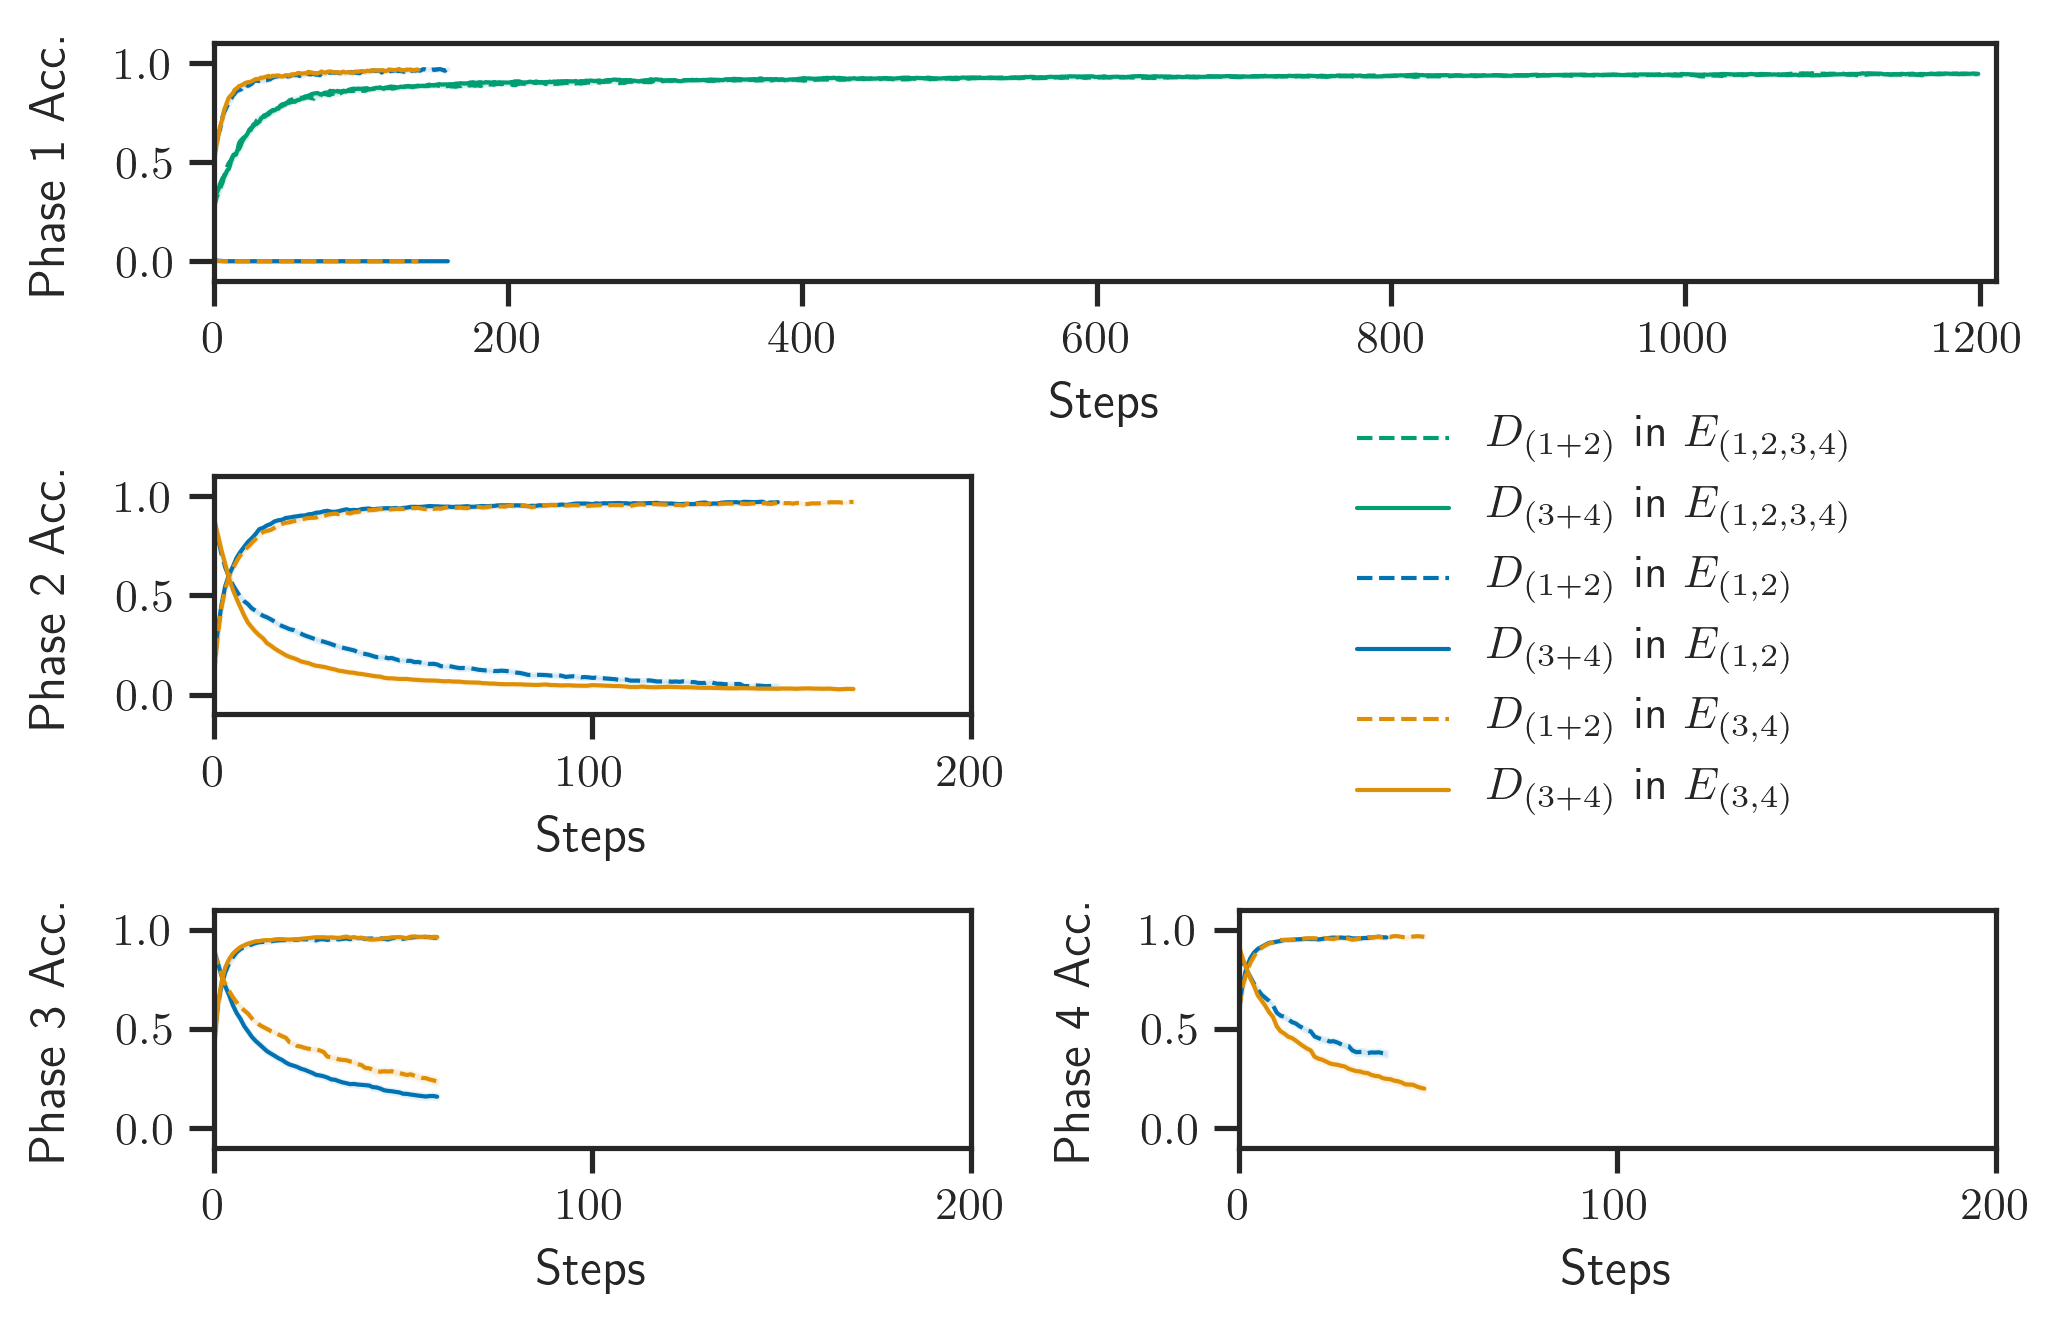

In [9]:
threshold = 125
fig = plt.figure(figsize=(7, 4.5), dpi=300)
gs = GridSpec(3, 2, figure=fig)
axarr = list()
axarr.append(fig.add_subplot(gs[0, :]))
axarr.append(fig.add_subplot(gs[1, 0]))
axarr.append(fig.add_subplot(gs[2, 0]))
axarr.append(fig.add_subplot(gs[2, 1]))
colors = sns.color_palette('colorblind', len(data.keys()))
xmax = 0

# phase 1 plot
ax = axarr[0]

x = np.where(data[E1234]['d1_count'][0] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E1234]['d1_avg'][0][x]
yerr = data[E1234]['d1_sem'][0][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[2], alpha=0.1)
ax.plot(x, y, color=colors[2], label=r'$D_{(1 + 2)}$ in $E_{(1, 2, 3, 4)}$', linestyle='--', linewidth=1)

x = np.where(data[E1234]['d2_count'][0] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E1234]['d2_avg'][0][x]
yerr = data[E1234]['d2_sem'][0][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[2], alpha=0.1)
ax.plot(x, y, color=colors[2], label=r'$D_{(3 + 4)}$ in $E_{(1, 2, 3, 4)}$', linestyle='-', linewidth=1)

x = np.where(data[E12]['d1_count'][0] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E12]['d1_avg'][0][x]
yerr = data[E12]['d1_sem'][0][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[0], alpha=0.1)
ax.plot(x, y, color=colors[0], label=r'$D_{(1 + 2)}$ in $E_{(1, 2)}$', linestyle='--', linewidth=1)

x = np.where(data[E12]['d2_count'][0] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E12]['d2_avg'][0][x]
yerr = data[E12]['d2_sem'][0][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[0], alpha=0.1)
ax.plot(x, y, color=colors[0], label=r'$D_{(3 + 4)}$ in $E_{(1, 2)}$', linestyle='-', linewidth=1)

x = np.where(data[E34]['d1_count'][0] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E34]['d1_avg'][0][x]
yerr = data[E34]['d1_sem'][0][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[1], alpha=0.1)
ax.plot(x, y, color=colors[1], label=r'$D_{(1 + 2)}$ in $E_{(3, 4)}$', linestyle='--', linewidth=1)

x = np.where(data[E34]['d2_count'][0] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E34]['d2_avg'][0][x]
yerr = data[E34]['d2_sem'][0][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[1], alpha=0.1)
ax.plot(x, y, color=colors[1], label=r'$D_{(3 + 4)}$ in $E_{(3, 4)}$', linestyle='-', linewidth=1)

# phase 2 plot
ax = axarr[1]

x = np.where(data[E12]['d1_count'][1] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E12]['d1_avg'][1][x]
yerr = data[E12]['d1_sem'][1][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[0], alpha=0.1)
ax.plot(x, y, color=colors[0], linestyle='--', linewidth=1)

x = np.where(data[E12]['d2_count'][1] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E12]['d2_avg'][1][x]
yerr = data[E12]['d2_sem'][1][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[0], alpha=0.1)
ax.plot(x, y, color=colors[0], linestyle='-', linewidth=1)

x = np.where(data[E34]['d1_count'][1] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E34]['d1_avg'][1][x]
yerr = data[E34]['d1_sem'][1][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[1], alpha=0.1)
ax.plot(x, y, color=colors[1], linestyle='--', linewidth=1)

x = np.where(data[E34]['d2_count'][1] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E34]['d2_avg'][1][x]
yerr = data[E34]['d2_sem'][1][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[1], alpha=0.1)
ax.plot(x, y, color=colors[1], linestyle='-', linewidth=1)

# phase 3 plot
ax = axarr[2]

x = np.where(data[E12]['d1_count'][2] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E12]['d1_avg'][2][x]
yerr = data[E12]['d1_sem'][2][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[0], alpha=0.1)
ax.plot(x, y, color=colors[0], linestyle='--', linewidth=1)

x = np.where(data[E12]['d2_count'][2] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E12]['d2_avg'][2][x]
yerr = data[E12]['d2_sem'][2][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[0], alpha=0.1)
ax.plot(x, y, color=colors[0], linestyle='-', linewidth=1)

x = np.where(data[E34]['d1_count'][2] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E34]['d1_avg'][2][x]
yerr = data[E34]['d1_sem'][2][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[1], alpha=0.1)
ax.plot(x, y, color=colors[1], linestyle='--', linewidth=1)

x = np.where(data[E34]['d2_count'][2] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E34]['d2_avg'][2][x]
yerr = data[E34]['d2_sem'][2][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[1], alpha=0.1)
ax.plot(x, y, color=colors[1], linestyle='-', linewidth=1)

# phase 4 plot
ax = axarr[3]

x = np.where(data[E12]['d1_count'][3] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E12]['d1_avg'][3][x]
yerr = data[E12]['d1_sem'][3][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[0], alpha=0.1)
ax.plot(x, y, color=colors[0], linestyle='--', linewidth=1)

x = np.where(data[E12]['d2_count'][3] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E12]['d2_avg'][3][x]
yerr = data[E12]['d2_sem'][3][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[0], alpha=0.1)
ax.plot(x, y, color=colors[0], linestyle='-', linewidth=1)

x = np.where(data[E34]['d1_count'][3] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E34]['d1_avg'][3][x]
yerr = data[E34]['d1_sem'][3][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[1], alpha=0.1)
ax.plot(x, y, color=colors[1], linestyle='--', linewidth=1)

x = np.where(data[E34]['d2_count'][3] >= threshold)[0]
xmax = max(xmax, max(x))
y = data[E34]['d2_avg'][3][x]
yerr = data[E34]['d2_sem'][3][x]
ax.fill_between(x, y - yerr, y + yerr, color=colors[1], alpha=0.1)
ax.plot(x, y, color=colors[1], linestyle='-', linewidth=1)

# clean up plot
for j in range(len(axarr)):
    ax = axarr[j]
    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xlabel(r'Steps', labelpad=5)
axarr[0].set_ylabel(r'Phase 1 Acc.', labelpad=10)
axarr[0].set_xticks([0, 200, 400, 600, 800, 1000, 1200])
axarr[0].set_xlim(0, max(xmax * 1.01, 1200))
axarr[1].set_ylabel(r'Phase 2 Acc.', labelpad=10)
axarr[1].set_xticks([0, 100, 200])
axarr[1].set_xlim(0, 200)
axarr[2].set_ylabel(r'Phase 3 Acc.', labelpad=10)
axarr[2].set_xticks([0, 100, 200])
axarr[2].set_xlim(0, 200)
axarr[3].set_ylabel(r'Phase 4 Acc.', labelpad=10)
axarr[3].set_xticks([0, 100, 200])
axarr[3].set_xlim(0, 200)
fig.legend(frameon=False, loc=(0.65, 0.37))
fig.tight_layout(pad=1)

# save plot
fig.savefig('experiment_1_accuracies.pdf', bbox_inches='tight')

In [10]:
text = ''
text += '|-------|---------------|\n'
text += '| Phase | Steps         |\n'
text += '|-------|---------------|\n'
for i, phase_lengths in enumerate(data[ER]['phase_lengths']):
    text += '| {0:>5} | {1:>7.2f}+-{2:4.2f} |\n'.format(
        i + 1,
        np.mean(phase_lengths),
        np.std(phase_lengths) / np.sqrt(len(phase_lengths)))
text += '|-------|---------------|\n'
with open('experiment_1_extended_phase_lengths.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|-------|---------------|
| Phase | Steps         |
|-------|---------------|
|     1 |  116.87+-2.64 |
|     2 |  123.38+-2.05 |
|     3 |   48.80+-1.46 |
|     4 |   35.27+-1.33 |
|     5 |   27.43+-1.12 |
|     6 |   21.55+-0.85 |
|     7 |   21.35+-0.99 |
|     8 |   16.23+-0.66 |
|-------|---------------|



<a href=#top>Back to Top</a>

## Experiment 2 MNIST<a name='experiment_2_mnist'/>

### Validation Phase<a name='experiment_2_mnist_validation'/>

In [11]:
rdf = mnist_tools.load_data(['experiment_2_mnist_validation.json'])
rdf = rdf[rdf['success']]
for i in rdf.index:
    if rdf.at[i, 'optimizer'] == 'sgd':
        if float(rdf.at[i, 'momentum']) > 0:
            rdf.at[i, 'optimizer'] = 'momentum'
        else:
            rdf.at[i, 'momentum'] = np.nan

metric = mnist_tools.total_time_metric(50, 2500)
best = mnist_tools.get_best(
    mnist_tools.get_summary(rdf),
    metric,
    ['optimizer', 'momentum', 'rho'])
key = ('sgd',)
print('{0}: lr={1}, metric={2:.2f}, count={3}'.format(
    optimizer_nice_names[key[0]],
    best[key]['lr'],
    metric(best[key]),
    int(best[key]['count'][0])))
for momentum in np.sort(rdf['momentum'].unique()):
    key = ('momentum', momentum)
    if key not in best:
        continue
    print('{0} momentum={1}: lr={2}, metric={3:.2f}, count={4}'.format(
        optimizer_nice_names[key[0]],
        momentum,
        best[key]['lr'],
        metric(best[key]),
        int(best[key]['count'][0])))
for rho in np.sort(rdf['rho'].unique()):
    key = ('rms', rho)
    if key not in best:
        continue
    print('{0} rho={1}: lr={2}, metric={3:.2f}, count={4}'.format(
        optimizer_nice_names[key[0]],
        rho,
        best[key]['lr'],
        metric(best[key]),
        int(best[key]['count'][0])))
key = ('adam',)
print('{0} beta_1={1} beta_2={2}: lr={3}, metric={4:.2f}, count={5}'.format(
    optimizer_nice_names[key[0]],
    best[key]['beta_1'],
    best[key]['beta_2'],
    best[key]['lr'],
    metric(best[key]),
    int(best[key]['count'][0])))

SGD: lr=0.0625, metric=293.80, count=50
Momentum momentum=0.81: lr=0.015625, metric=418.60, count=50
Momentum momentum=0.9: lr=0.0078125, metric=573.80, count=50
Momentum momentum=0.99: lr=0.0009765625, metric=2305.00, count=50
RMSProp rho=0.81: lr=0.0078125, metric=266.00, count=50
RMSProp rho=0.9: lr=0.0078125, metric=236.80, count=50
RMSProp rho=0.99: lr=0.001953125, metric=209.40, count=50
RMSProp rho=0.999: lr=0.00048828125, metric=218.10, count=50
Adam beta_1=0.9 beta_2=0.999: lr=0.00390625, metric=487.80, count=50


In [12]:
best = mnist_tools.get_best(
    mnist_tools.get_summary(rdf),
    metric,
    ['optimizer', 'lr', 'momentum', 'rho'])
summary = dict()
for k, v in best.items():
    if (k[0] == 'momentum') and (k[2] != 0.9):
        continue
    if (k[0] == 'rms') and (k[2] != 0.999):
        continue
    if k[0] not in summary:
        summary[k[0]] = dict()
    assert(k[1] not in summary[k[0]])
    summary[k[0]][k[1]] = v

max_phase_lengths = list()
for _, row in rdf.iterrows():
    for i, l in enumerate(row['phase_length']):
        if len(max_phase_lengths) == i:
            max_phase_lengths.append(0)
        max_phase_lengths[i] = max(max_phase_lengths[i], l)
data = dict()
for k in best.keys():
    data[k] = dict()
    for k2 in ['d1_count',
               'd2_count',
               'online_count',
               'as_count',
               'pi_count']:
        data[k][k2] = [np.zeros(i, dtype=int) for i in max_phase_lengths]
    for k2 in ['d1_avg',
               'd1_sec',
               'd1_min',
               'd1_max',
               'd2_avg',
               'd2_sec',
               'd2_min',
               'd2_max',
               'online_avg',
               'online_sec',
               'online_min',
               'online_max',
               'as_avg',
               'as_sec',
               'as_min',
               'as_max',
               'pi_avg',
               'pi_sec',
               'pi_min',
               'pi_max']:
        data[k][k2] = [np.zeros(i, dtype=float) for i in max_phase_lengths]
    for k2 in ['d1_final_avg',
               'd1_final_sec',
               'd2_final_avg',
               'd2_final_sec',
               'online_final_avg',
               'online_final_sec',
               'as_final_avg',
               'as_final_sec',
               'pi_final_avg',
               'pi_final_sec']:
        data[k][k2] = [0 for _ in range(len(max_phase_lengths))]
    data[k]['phase_length_count'] = [0 for i in max_phase_lengths]
    data[k]['phase_length_avg'] = [0 for i in max_phase_lengths]
    data[k]['phase_length_sec'] = [0 for i in max_phase_lengths]
    for i in range(len(max_phase_lengths)):
        data[k]['d1_min'][i] += 1
        data[k]['d2_min'][i] += 1
    kdf = rdf[rdf['optimizer'] == k[0]]
    kdf = kdf[kdf['lr'] == k[1]]
    if k[0] == 'momentum':
        kdf = kdf[kdf['momentum'] == k[2]]
    if k[0] == 'rms':
        kdf = kdf[kdf['rho'] == k[2]]
    for _, row in kdf.iterrows():
        j = 0
        for i, l in enumerate(row['phase_length']):
            delta = l - data[k]['phase_length_avg'][i]
            data[k]['phase_length_count'][i] += 1
            data[k]['phase_length_avg'][i] += delta / data[k]['phase_length_count'][i]
            data[k]['phase_length_sec'][i] += delta * (l - data[k]['phase_length_avg'][i])

            values = np.array(row['accuracies'])[j:j + l, 0]
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['d1_avg'][i][mask]
            data[k]['d1_count'][i][mask] += 1
            data[k]['d1_avg'][i][mask] += delta / data[k]['d1_count'][i][mask]
            data[k]['d1_sec'][i][mask] += delta * (values - data[k]['d1_avg'][i][mask])
            data[k]['d1_min'][i][mask] = np.minimum(data[k]['d1_min'][i][mask], values)
            data[k]['d1_max'][i][mask] = np.maximum(data[k]['d1_max'][i][mask], values)
            delta = values[-1] - data[k]['d1_final_avg'][i]
            data[k]['d1_final_avg'][i] += delta / data[k]['d1_count'][i][0]
            data[k]['d1_final_sec'][i] += delta * (values[-1] - data[k]['d1_final_avg'][i])

            values = np.array(row['accuracies'])[j:j + l, 1]
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['d2_avg'][i][mask]
            data[k]['d2_count'][i][mask] += 1
            data[k]['d2_avg'][i][mask] += delta / data[k]['d2_count'][i][mask]
            data[k]['d2_sec'][i][mask] += delta * (values - data[k]['d2_avg'][i][mask])
            data[k]['d2_min'][i][mask] = np.minimum(data[k]['d2_min'][i][mask], values)
            data[k]['d2_max'][i][mask] = np.maximum(data[k]['d2_max'][i][mask], values)
            delta = values[-1] - data[k]['d2_final_avg'][i]
            data[k]['d2_final_avg'][i] += delta / data[k]['d2_count'][i][0]
            data[k]['d2_final_sec'][i] += delta * (values[-1] - data[k]['d2_final_avg'][i])

            values = np.cumsum(np.array(row['correct'])[j:j + l]) / (np.arange(l) + 1)
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['online_avg'][i][mask]
            data[k]['online_count'][i][mask] += 1
            data[k]['online_avg'][i][mask] += delta / data[k]['online_count'][i][mask]
            data[k]['online_sec'][i][mask] += delta * (values - data[k]['online_avg'][i][mask])
            data[k]['online_min'][i][mask] = np.minimum(data[k]['online_min'][i][mask], values)
            data[k]['online_max'][i][mask] = np.maximum(data[k]['online_max'][i][mask], values)
            delta = values[-1] - data[k]['online_final_avg'][i]
            data[k]['online_final_avg'][i] += delta / data[k]['online_count'][i][0]
            data[k]['online_final_sec'][i] += delta * (values[-1] - data[k]['online_final_avg'][i])

            values = np.array(row['activation_similarity'])[j:j + l]
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['as_avg'][i][mask]
            data[k]['as_count'][i][mask] += 1
            data[k]['as_avg'][i][mask] += delta / data[k]['as_count'][i][mask]
            data[k]['as_sec'][i][mask] += delta * (values - data[k]['as_avg'][i][mask])
            data[k]['as_min'][i][mask] = np.minimum(data[k]['as_min'][i][mask], values)
            data[k]['as_max'][i][mask] = np.maximum(data[k]['as_max'][i][mask], values)
            delta = values[-1] - data[k]['as_final_avg'][i]
            data[k]['as_final_avg'][i] += delta / data[k]['as_count'][i][0]
            data[k]['as_final_sec'][i] += delta * (values[-1] - data[k]['as_final_avg'][i])
            
            values = np.array(row['pairwise_interference'])[j:j + l]
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['pi_avg'][i][mask]
            data[k]['pi_count'][i][mask] += 1
            data[k]['pi_avg'][i][mask] += delta / data[k]['pi_count'][i][mask]
            data[k]['pi_sec'][i][mask] += delta * (values - data[k]['pi_avg'][i][mask])
            data[k]['pi_min'][i][mask] = np.minimum(data[k]['pi_min'][i][mask], values)
            data[k]['pi_max'][i][mask] = np.maximum(data[k]['pi_max'][i][mask], values)
            delta = values[-1] - data[k]['pi_final_avg'][i]
            data[k]['pi_final_avg'][i] += delta / data[k]['pi_count'][i][0]
            data[k]['pi_final_sec'][i] += delta * (values[-1] - data[k]['pi_final_avg'][i])

            j += l
    data[k]['phase_length_sem'] = list()
    data[k]['d1_sem'] = list()
    data[k]['d2_sem'] = list()
    data[k]['online_sem'] = list()
    data[k]['as_sem'] = list()
    data[k]['pi_sem'] = list()
    data[k]['d1_final_sem'] = list()
    data[k]['d2_final_sem'] = list()
    data[k]['online_final_sem'] = list()
    data[k]['as_final_sem'] = list()
    data[k]['pi_final_sem'] = list()
    for i in range(len(max_phase_lengths)):
        data[k]['phase_length_sem'].append(np.sqrt(data[k]['phase_length_sec'][i]) / data[k]['phase_length_count'][i])
        data[k]['d1_sem'].append(np.nan_to_num(np.sqrt(data[k]['d1_sec'][i]) / data[k]['d1_count'][i]))
        data[k]['d2_sem'].append(np.nan_to_num(np.sqrt(data[k]['d2_sec'][i]) / data[k]['d2_count'][i]))
        data[k]['online_sem'].append(np.nan_to_num(np.sqrt(data[k]['online_sec'][i]) / data[k]['online_count'][i]))
        data[k]['as_sem'].append(np.nan_to_num(np.sqrt(data[k]['as_sec'][i]) / data[k]['as_count'][i]))
        data[k]['pi_sem'].append(np.nan_to_num(np.sqrt(data[k]['pi_sec'][i]) / data[k]['pi_count'][i]))
        data[k]['d1_final_sem'].append(np.nan_to_num(np.sqrt(data[k]['d1_final_sec'][i]) / data[k]['d1_count'][i][0]))
        data[k]['d2_final_sem'].append(np.nan_to_num(np.sqrt(data[k]['d2_final_sec'][i]) / data[k]['d2_count'][i][0]))
        data[k]['online_final_sem'].append(np.nan_to_num(np.sqrt(data[k]['online_final_sec'][i]) / data[k]['online_count'][i][0]))
        data[k]['as_final_sem'].append(np.nan_to_num(np.sqrt(data[k]['as_final_sec'][i]) / data[k]['as_count'][i][0]))
        data[k]['pi_final_sem'].append(np.nan_to_num(np.sqrt(data[k]['pi_final_sec'][i]) / data[k]['pi_count'][i][0]))
    
    del data[k]['phase_length_sec']
    del data[k]['d1_sec']
    del data[k]['d2_sec']
    del data[k]['online_sec']
    del data[k]['as_sec']
    del data[k]['pi_sec']
    del data[k]['d1_final_sec']
    del data[k]['d2_final_sec']
    del data[k]['online_final_sec']
    del data[k]['as_final_sec']
    del data[k]['pi_final_sec']

collected = {k[0]: dict() for k in data.keys()}
for k, v in data.items():
    if (k[0] == 'momentum') and (k[2] != 0.9):
        continue
    if (k[0] == 'rms') and (k[2] != 0.999):
        continue
    collected[k[0]][k[1]] = v
ordered = {k: dict() for k in collected.keys()}
for k, v in collected.items():
    ordered[k]['lr'] = sorted(v.keys())
    for k2 in ['phase_length',
               'd1_final',
               'd2_final',
               'online_final',
               'as_final',
               'pi_final']:
        ordered[k][k2 + '_avg'] = list()
        ordered[k][k2 + '_sem'] = list()
    for lr in ordered[k]['lr']:
        for k2 in ['phase_length',
                   'd1_final',
                   'd2_final',
                   'online_final',
                   'as_final',
                   'pi_final']:
            ordered[k][k2 + '_avg'].append(collected[k][lr][k2 + '_avg'])
            ordered[k][k2 + '_sem'].append(collected[k][lr][k2 + '_sem'])
    for k2 in ['phase_length','d1_final',
               'd2_final',
               'online_final',
               'as_final',
               'pi_final']:
        ordered[k][k2 + '_avg'] = np.array(ordered[k][k2 + '_avg'])
        ordered[k][k2 + '_sem'] = np.array(ordered[k][k2 + '_sem'])

/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:162: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:163: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:164: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:165: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:166: RuntimeWarning: invalid value encountered in true_divide


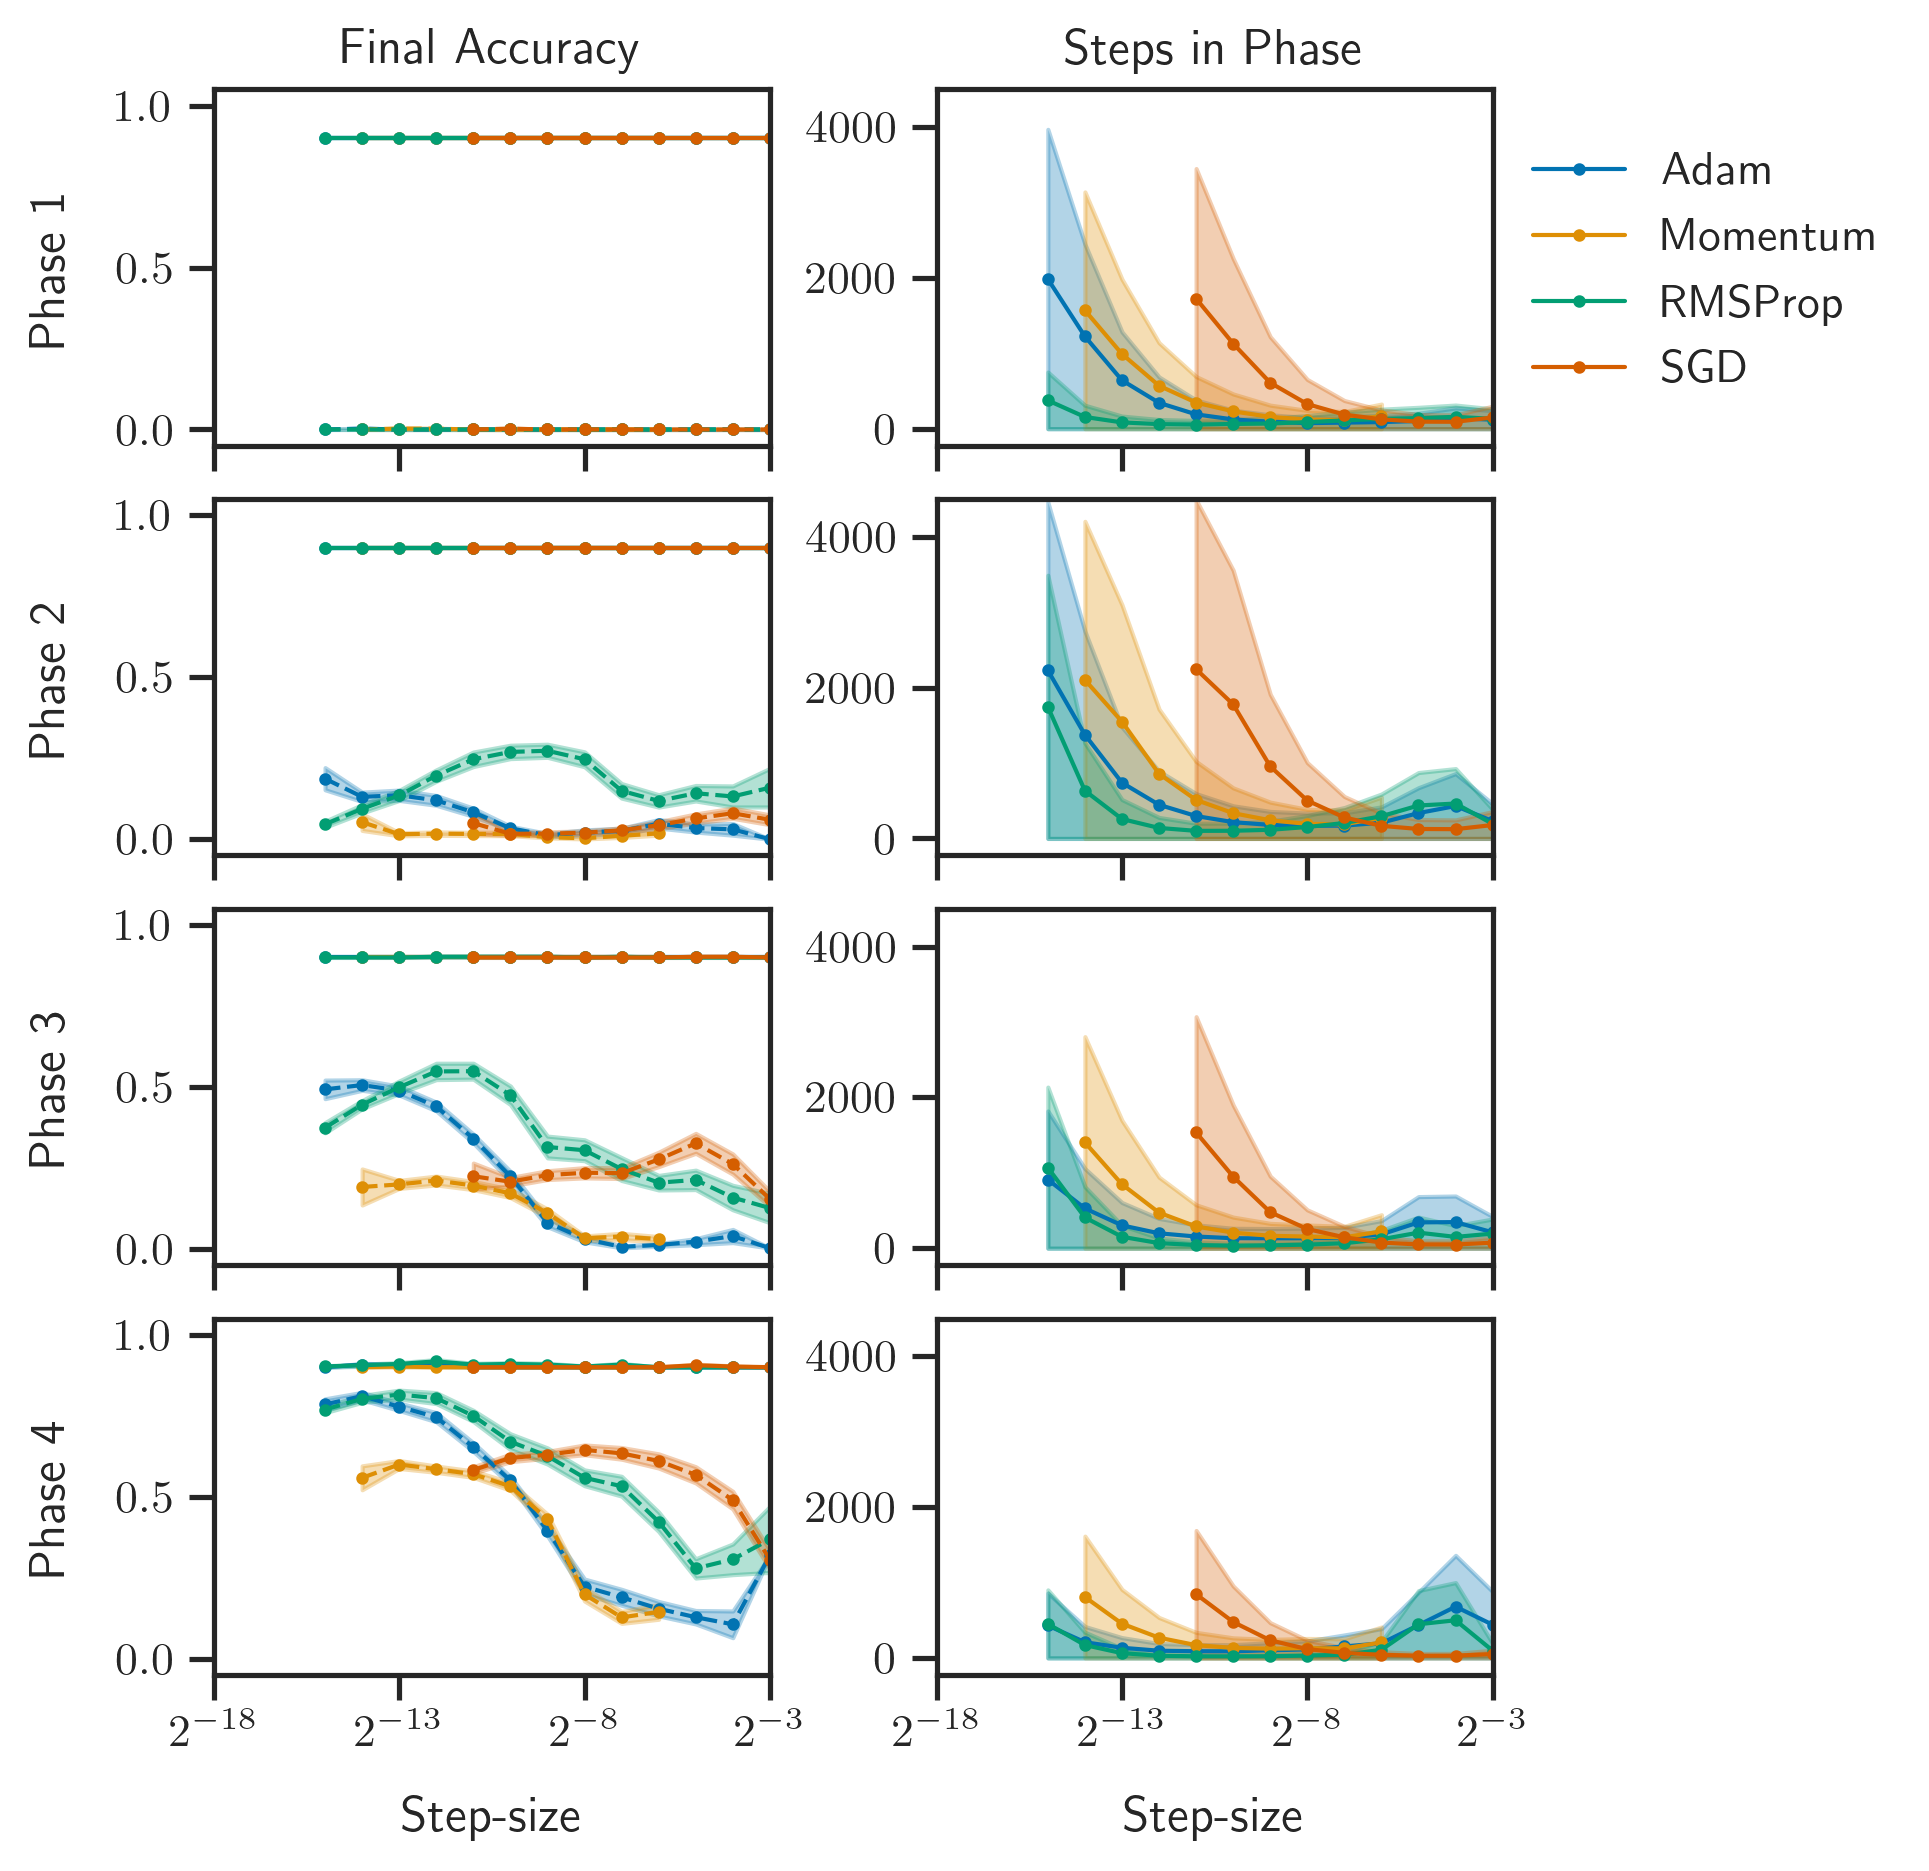

In [13]:
fig, axmat = plt.subplots(4, 2, figsize=(5.5, 7), dpi=300, sharex=True)
colors = sns.color_palette('colorblind', len(ordered.keys()))
xmax = 0
for j in range(4):
    for i, (k, v) in enumerate(sorted(ordered.items(), key=lambda x: x[0])):
        other_phase = (j + 1) % 2 + 1
        x = v['lr']
        y = v['d{}_final_avg'.format(other_phase)][:, j]
        yerr = v['d{}_final_sem'.format(other_phase)][:, j]
        axmat[j, 0].plot(
            x,
            y,
            '-o',
            linestyle='--',
            linewidth=1,
            markersize=2,
            color=colors[i])
        axmat[j, 0].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)

        y = v['online_final_avg'][:, j]
        yerr = v['online_final_sem'][:, j]
        axmat[j, 0].plot(
            x,
            y,
            '-o',
            label=optimizer_nice_names[k],
            linewidth=1,
            markersize=2,
            color=colors[i])
        axmat[j, 0].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)
        
        y = v['phase_length_avg'][:, j]
        yerr = v['phase_length_avg'][:, j]
        axmat[j, 1].plot(
            x,
            y,
            '-o',
            label=optimizer_nice_names[k],
            linewidth=1,
            markersize=2,
            color=colors[i])
        axmat[j, 1].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)

for j in range(len(axarr)):
    axmat[j, 0].set_ylim(-0.05, 1.05)
    axmat[j, 0].set_yticks([0.0, 0.5, 1.0])
    axmat[j, 0].set_ylabel('Phase {}'.format(j + 1), labelpad=10)
    axmat[j, 1].set_ylim(- 225, 4500)
    axmat[j, 1].set_yticks([0, 2000, 4000])
axmat[0, 0].set_title('Final Accuracy')
axmat[0, 1].set_title('Steps in Phase')
axmat[-1, 0].set_xscale('log', basex=2)
axmat[-1, 0].set_xticks([2 ** (-18), 2 ** (-13), 2 ** (-8), 2 ** (-3)])
axmat[-1, 0].set_xlim(2 ** (-18), 2 ** (-3))
axmat[-1, 0].set_xlabel('Step-size', labelpad=10)
axmat[-1, 1].set_xlabel('Step-size', labelpad=10)
plt.legend(frameon=False, loc=(1.04, 3.55))
fig.subplots_adjust(hspace=0.15, wspace=0.3)
fig.savefig('experiment_2_mnist_accuracies_and_speed_step-size.pdf', bbox_inches='tight')

/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = re

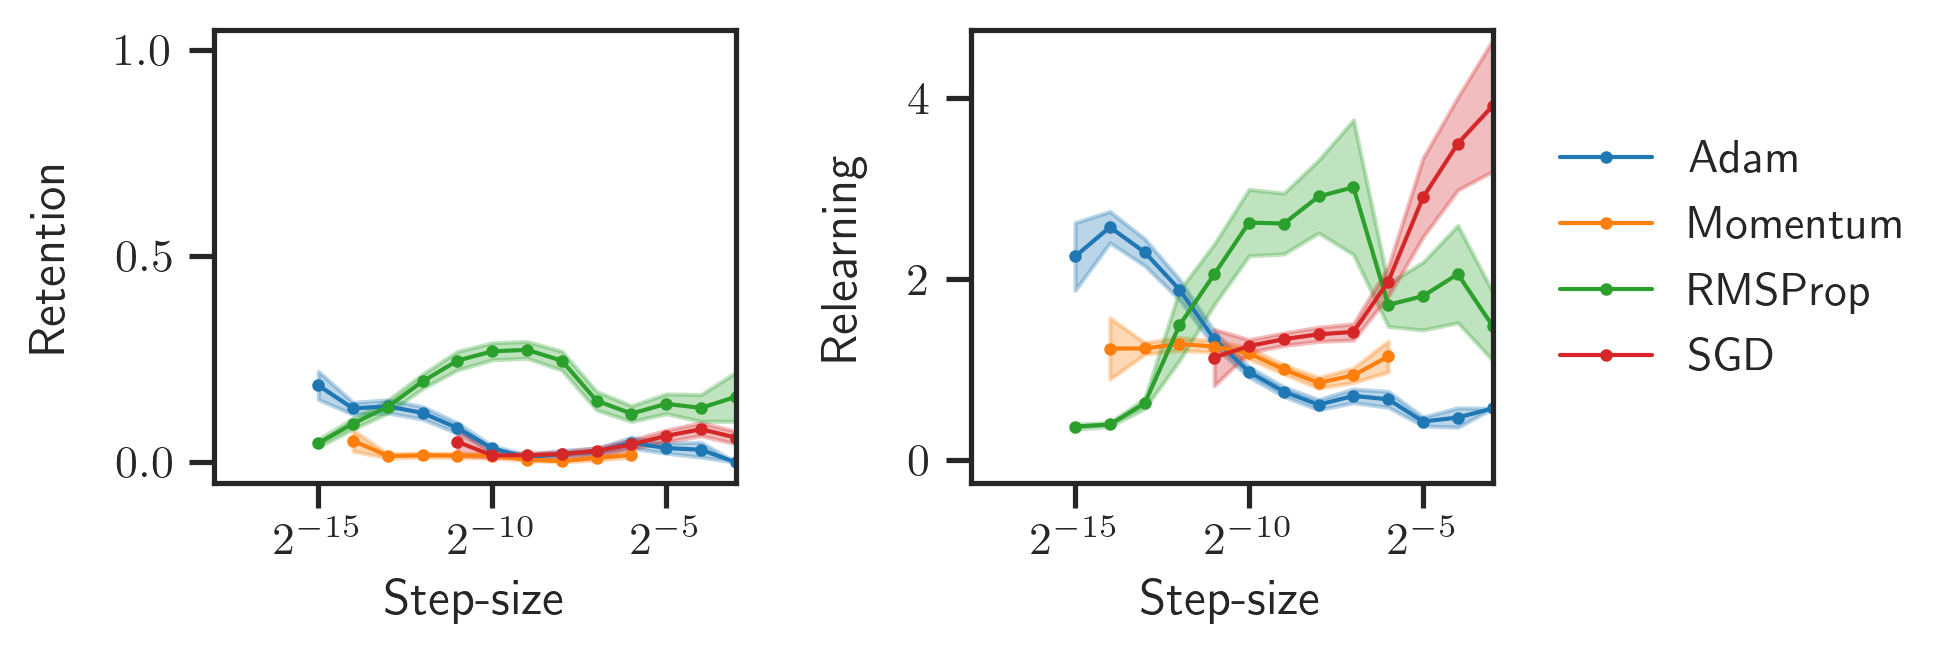

In [14]:
learning_rates = [0.125,
                  0.0625,
                  0.03125,
                  0.015625,
                  0.0078125,
                  0.00390625,
                  0.001953125,
                  0.0009765625,
                  0.00048828125,
                  0.000244140625,
                  0.0001220703125,
                  6.103515625e-05,
                  3.0517578125e-05,
                  1.52587890625e-05,
                  7.62939453125e-06,
                  3.814697265625e-06]

retention = dict()
relearning = dict()
for _, row in rdf.iterrows():
    optimizer = row['optimizer']
    if optimizer == 'constant':
        continue
    if (optimizer == 'momentum') and (row['momentum'] != 0.9):
        continue
    if (optimizer == 'rms') and (row['rho'] != 0.999):
        continue
    lr = row['lr']
    if optimizer not in retention:
        assert(optimizer not in relearning)
        for dict_ in [retention, relearning]:
            dict_[optimizer] = collections.OrderedDict()
            for value in learning_rates:
                dict_[optimizer][value] = list()
    retention[optimizer][lr].append(row['accuracies'][sum(row['phase_length'][:2]) - 1][0])
    relearning[optimizer][lr].append(row['phase_length'][0] / row['phase_length'][2])

colors = sns.color_palette(n_colors=len(retention.keys()))
fig, (ax1, ax2) = plt.subplots(1, 2, dpi=300, figsize=(5.5, 2))
sort_key = lambda x: x[0]
for i, optimizer in enumerate(sorted(retention.keys())):
    x = list(retention[optimizer].keys())
    y1 = list()
    y1err = list()
    y2 = list()
    y2err = list()
    for lr in x:
        for values, y, yerr in [(retention[optimizer][lr], y1, y1err),
                                (relearning[optimizer][lr], y2, y2err)]:
            y.append(np.mean(values))
            yerr.append(np.std(values) / np.sqrt(len(values)))
    x = np.array(x)
    y1 = np.array(y1)
    y1err = np.array(y1err)
    y2 = np.array(y2)
    y2err = np.array(y2err)
            
    ax1.plot(
        x,
        y1,
        '-o',
        label=optimizer_nice_names[optimizer],
        markersize=2,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    
    ax2.plot(
        x,
        y2,
        '-o',
        linewidth=1,
        markersize=2,
        color=colors[i])
    ax2.fill_between(
        x,
        y2 - y2err,
        y2 + y2err,
        alpha=0.3,
        color=colors[i])

for ax in [ax1, ax2]:
    ax.set_xscale('log', basex=2)
    ax.set_xlim(2 ** (-18), 2 ** (-3))
    ax.set_xticks([2 ** (-15), 2 ** (-10), 2 ** (-5)])
    ax.set_xlabel('Step-size')
ax1.set_ylabel('Retention', labelpad=10)
ax1.set_ylim(-0.05, 1.05)
ax1.set_yticks([0.0, 0.5, 1.0])
ax2.set_ylabel('Relearning', labelpad=10)
ax2.set_ylim(-0.25, 4.75)
ax2.set_yticks([0, 2, 4])
lgd = ax1.legend(loc='upper right', bbox_to_anchor=(3.325, 0.85), frameon=False)
fig.subplots_adjust(wspace=0.45)
fig.savefig('experiment_2_mnist_interference_step-size.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')

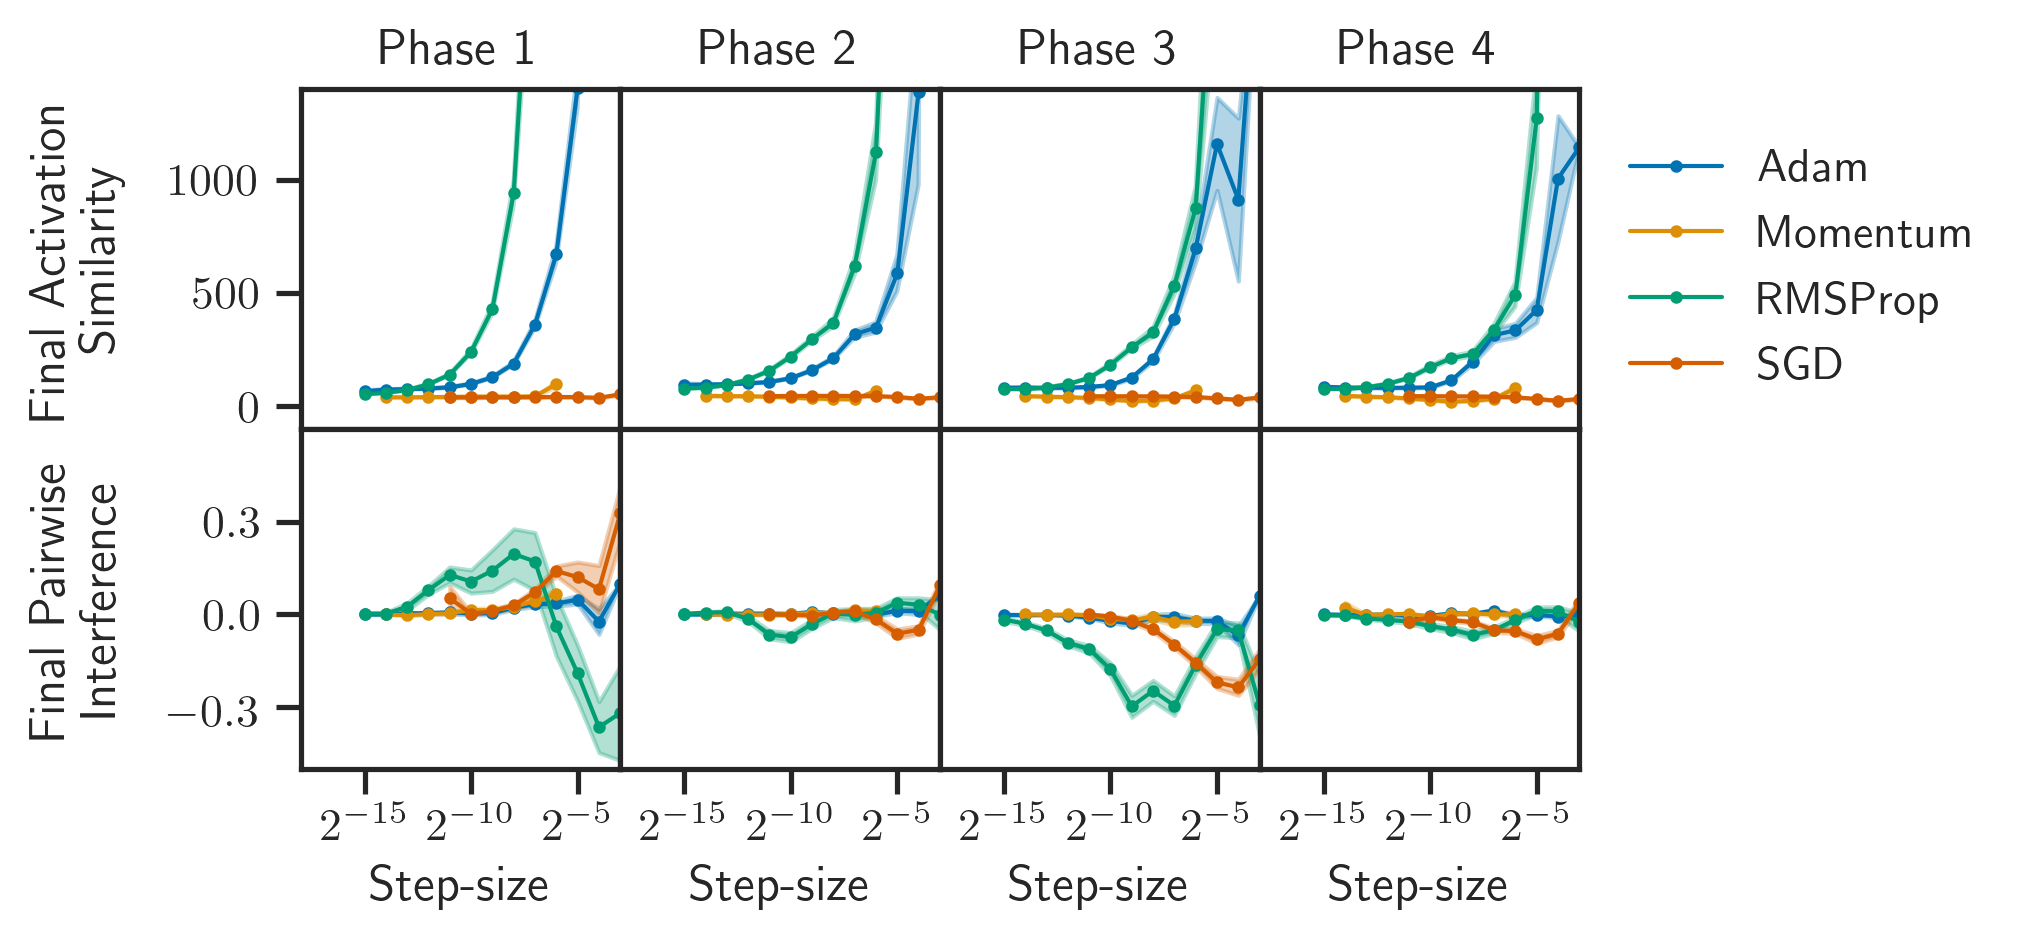

In [15]:
threshold = 125
fig, axmat = plt.subplots(2, 4, sharex=True, dpi=300, figsize=(5.5, 3))
colors = sns.color_palette('colorblind', len(data.keys()))
xmax = 0
for j in range(4):
    for i, (k, v) in enumerate(sorted(ordered.items(), key=lambda x: x[0])):
        x = v['lr']
        label = optimizer_nice_names[k] if j == 0 else None

        y = v['as_final_avg'][:, j]
        yerr = v['as_final_sem'][:, j]
        axmat[0, j].plot(
            x,
            y,
            '-o',
            label=label,
            linewidth=1,
            markersize=2,
            color=colors[i])
        axmat[0, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)

        y = v['pi_final_avg'][:, j]
        yerr = v['pi_final_sem'][:, j]
        axmat[1, j].plot(
            x,
            y,
            '-o',
            label=label,
            linewidth=1,
            markersize=2,
            color=colors[i])
        axmat[1, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)

axmat[0, 0].set_ylabel('Final Activation\nSimilarity', labelpad=10)
axmat[1, 0].set_ylabel('Final Pairwise\nInterference', labelpad=10)
for j in range(4):
    axmat[0, j].set_title('Phase {}'.format(j + 1))
    axmat[0, j].set_ylim(- 100, 1400)
    axmat[0, j].set_yticks([0, 500, 1000])
    axmat[1, j].set_ylim(- 0.5, 0.6)
    axmat[1, j].set_yticks([- 0.3, 0, 0.3])
    for i in range(2):
        axmat[i, j].set_xscale('log', basex=2)
        axmat[i, j].set_xlim(2 ** (-18), 2 ** (-3))
        if j != 0:
            axmat[i, j].tick_params(axis='y', which='both', left=False)
            axmat[i, j].set_yticklabels([])
    axmat[1, j].set_xticks([2 ** (-15), 2 ** (-10), 2 ** (-5)])
    axmat[1, j].set_xlabel('Step-size')
fig.align_ylabels(axmat[:, 0])
axmat[0, 0].legend(loc='upper right', bbox_to_anchor=(5.375, 0.95), frameon=False)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig('experiment_2_mnist_additional_interference_step-size.pdf', bbox_inches='tight')

<a href=#top>Back to Top</a>

### Testing Phase<a name='experiment_2_mnist_testing'/>

In [16]:
rdf = mnist_tools.load_data(['experiment_2_mnist_test.json'])
rdf = rdf[rdf['success']]
for i in rdf.index:
    if rdf.at[i, 'optimizer'] == 'sgd':
        if float(rdf.at[i, 'momentum']) > 0:
            rdf.at[i, 'optimizer'] = 'momentum'
        else:
            rdf.at[i, 'momentum'] = None
best = mnist_tools.get_best(
    mnist_tools.get_summary(rdf),
    mnist_tools.total_time_metric(50, 2500),
    ['optimizer', 'momentum', 'rho'])

max_phase_lengths = list()
for _, row in rdf.iterrows():
    for i, l in enumerate(row['phase_length']):
        if len(max_phase_lengths) == i:
            max_phase_lengths.append(0)
        max_phase_lengths[i] = max(max_phase_lengths[i], l)
data = dict()
for k in best.keys():
    data[k] = dict()
    for k2 in ['d1_count',
               'd2_count',
               'online_count',
               'as_count',
               'pi_count']:
        data[k][k2] = [np.zeros(i, dtype=int) for i in max_phase_lengths]
    for k2 in ['d1_avg',
               'd1_sec',
               'd1_min',
               'd1_max',
               'd2_avg',
               'd2_sec',
               'd2_min',
               'd2_max',
               'online_avg',
               'online_sec',
               'online_min',
               'online_max',
               'as_avg',
               'as_sec',
               'as_min',
               'as_max',
               'pi_avg',
               'pi_sec',
               'pi_min',
               'pi_max']:
        data[k][k2] = [np.zeros(i, dtype=float) for i in max_phase_lengths]
    data[k]['phase_lengths'] = [list() for i in max_phase_lengths]
    for i in range(len(max_phase_lengths)):
        data[k]['d1_min'][i] += 1
        data[k]['d2_min'][i] += 1
    kdf = rdf[rdf['optimizer'] == k[0]]
    if k[0] == 'momentum':
        kdf = kdf[kdf['momentum'] == k[1]]
    if k[0] == 'rms':
        kdf = kdf[kdf['rho'] == k[1]]
    for _, row in kdf.iterrows():
        j = 0
        for i, l in enumerate(row['phase_length']):
            data[k]['phase_lengths'][i].append(l)

            values = np.array(row['accuracies'])[j:j + l, 0]
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['d1_avg'][i][mask]
            data[k]['d1_count'][i][mask] += 1
            data[k]['d1_avg'][i][mask] += delta / data[k]['d1_count'][i][mask]
            data[k]['d1_sec'][i][mask] += delta * (values - data[k]['d1_avg'][i][mask])
            data[k]['d1_min'][i][mask] = np.minimum(data[k]['d1_min'][i][mask], values)
            data[k]['d1_max'][i][mask] = np.maximum(data[k]['d1_max'][i][mask], values)

            values = np.array(row['accuracies'])[j:j + l, 1]
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['d2_avg'][i][mask]
            data[k]['d2_count'][i][mask] += 1
            data[k]['d2_avg'][i][mask] += delta / data[k]['d2_count'][i][mask]
            data[k]['d2_sec'][i][mask] += delta * (values - data[k]['d2_avg'][i][mask])
            data[k]['d2_min'][i][mask] = np.minimum(data[k]['d2_min'][i][mask], values)
            data[k]['d2_max'][i][mask] = np.maximum(data[k]['d2_max'][i][mask], values)

            values = np.cumsum(np.array(row['correct'])[j:j + l]) / (np.arange(l) + 1)
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['online_avg'][i][mask]
            data[k]['online_count'][i][mask] += 1
            data[k]['online_avg'][i][mask] += delta / data[k]['online_count'][i][mask]
            data[k]['online_sec'][i][mask] += delta * (values - data[k]['online_avg'][i][mask])
            data[k]['online_min'][i][mask] = np.minimum(data[k]['online_min'][i][mask], values)
            data[k]['online_max'][i][mask] = np.maximum(data[k]['online_max'][i][mask], values)

            values = np.array(row['activation_similarity'])[j:j + l]
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['as_avg'][i][mask]
            data[k]['as_count'][i][mask] += 1
            data[k]['as_avg'][i][mask] += delta / data[k]['as_count'][i][mask]
            data[k]['as_sec'][i][mask] += delta * (values - data[k]['as_avg'][i][mask])
            data[k]['as_min'][i][mask] = np.minimum(data[k]['as_min'][i][mask], values)
            data[k]['as_max'][i][mask] = np.maximum(data[k]['as_max'][i][mask], values)
            
            values = np.array(row['pairwise_interference'])[j:j + l]
            mask = np.where(np.array(np.invert(np.isnan(values)), dtype=int))[0]
            values = values[mask]
            delta = values - data[k]['pi_avg'][i][mask]
            data[k]['pi_count'][i][mask] += 1
            data[k]['pi_avg'][i][mask] += delta / data[k]['pi_count'][i][mask]
            data[k]['pi_sec'][i][mask] += delta * (values - data[k]['pi_avg'][i][mask])
            data[k]['pi_min'][i][mask] = np.minimum(data[k]['pi_min'][i][mask], values)
            data[k]['pi_max'][i][mask] = np.maximum(data[k]['pi_max'][i][mask], values)

            j += l
    data[k]['d1_sem'] = list()
    data[k]['d2_sem'] = list()
    data[k]['online_sem'] = list()
    data[k]['as_sem'] = list()
    data[k]['pi_sem'] = list()
    for i in range(len(max_phase_lengths)):
        data[k]['d1_sem'].append(np.nan_to_num(np.sqrt(data[k]['d1_sec'][i]) / data[k]['d1_count'][i]))
        data[k]['d2_sem'].append(np.nan_to_num(np.sqrt(data[k]['d2_sec'][i]) / data[k]['d2_count'][i]))
        data[k]['online_sem'].append(np.nan_to_num(np.sqrt(data[k]['online_sec'][i]) / data[k]['online_count'][i]))
        data[k]['as_sem'].append(np.nan_to_num(np.sqrt(data[k]['as_sec'][i]) / data[k]['as_count'][i]))
        data[k]['pi_sem'].append(np.nan_to_num(np.sqrt(data[k]['pi_sec'][i]) / data[k]['pi_count'][i]))
    del data[k]['d1_sec']
    del data[k]['d2_sec']
    del data[k]['online_sec']
    del data[k]['as_sec']
    del data[k]['pi_sec']

/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:121: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:123: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: invalid value encountered in true_divide
/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: invalid value encountered in true_divide


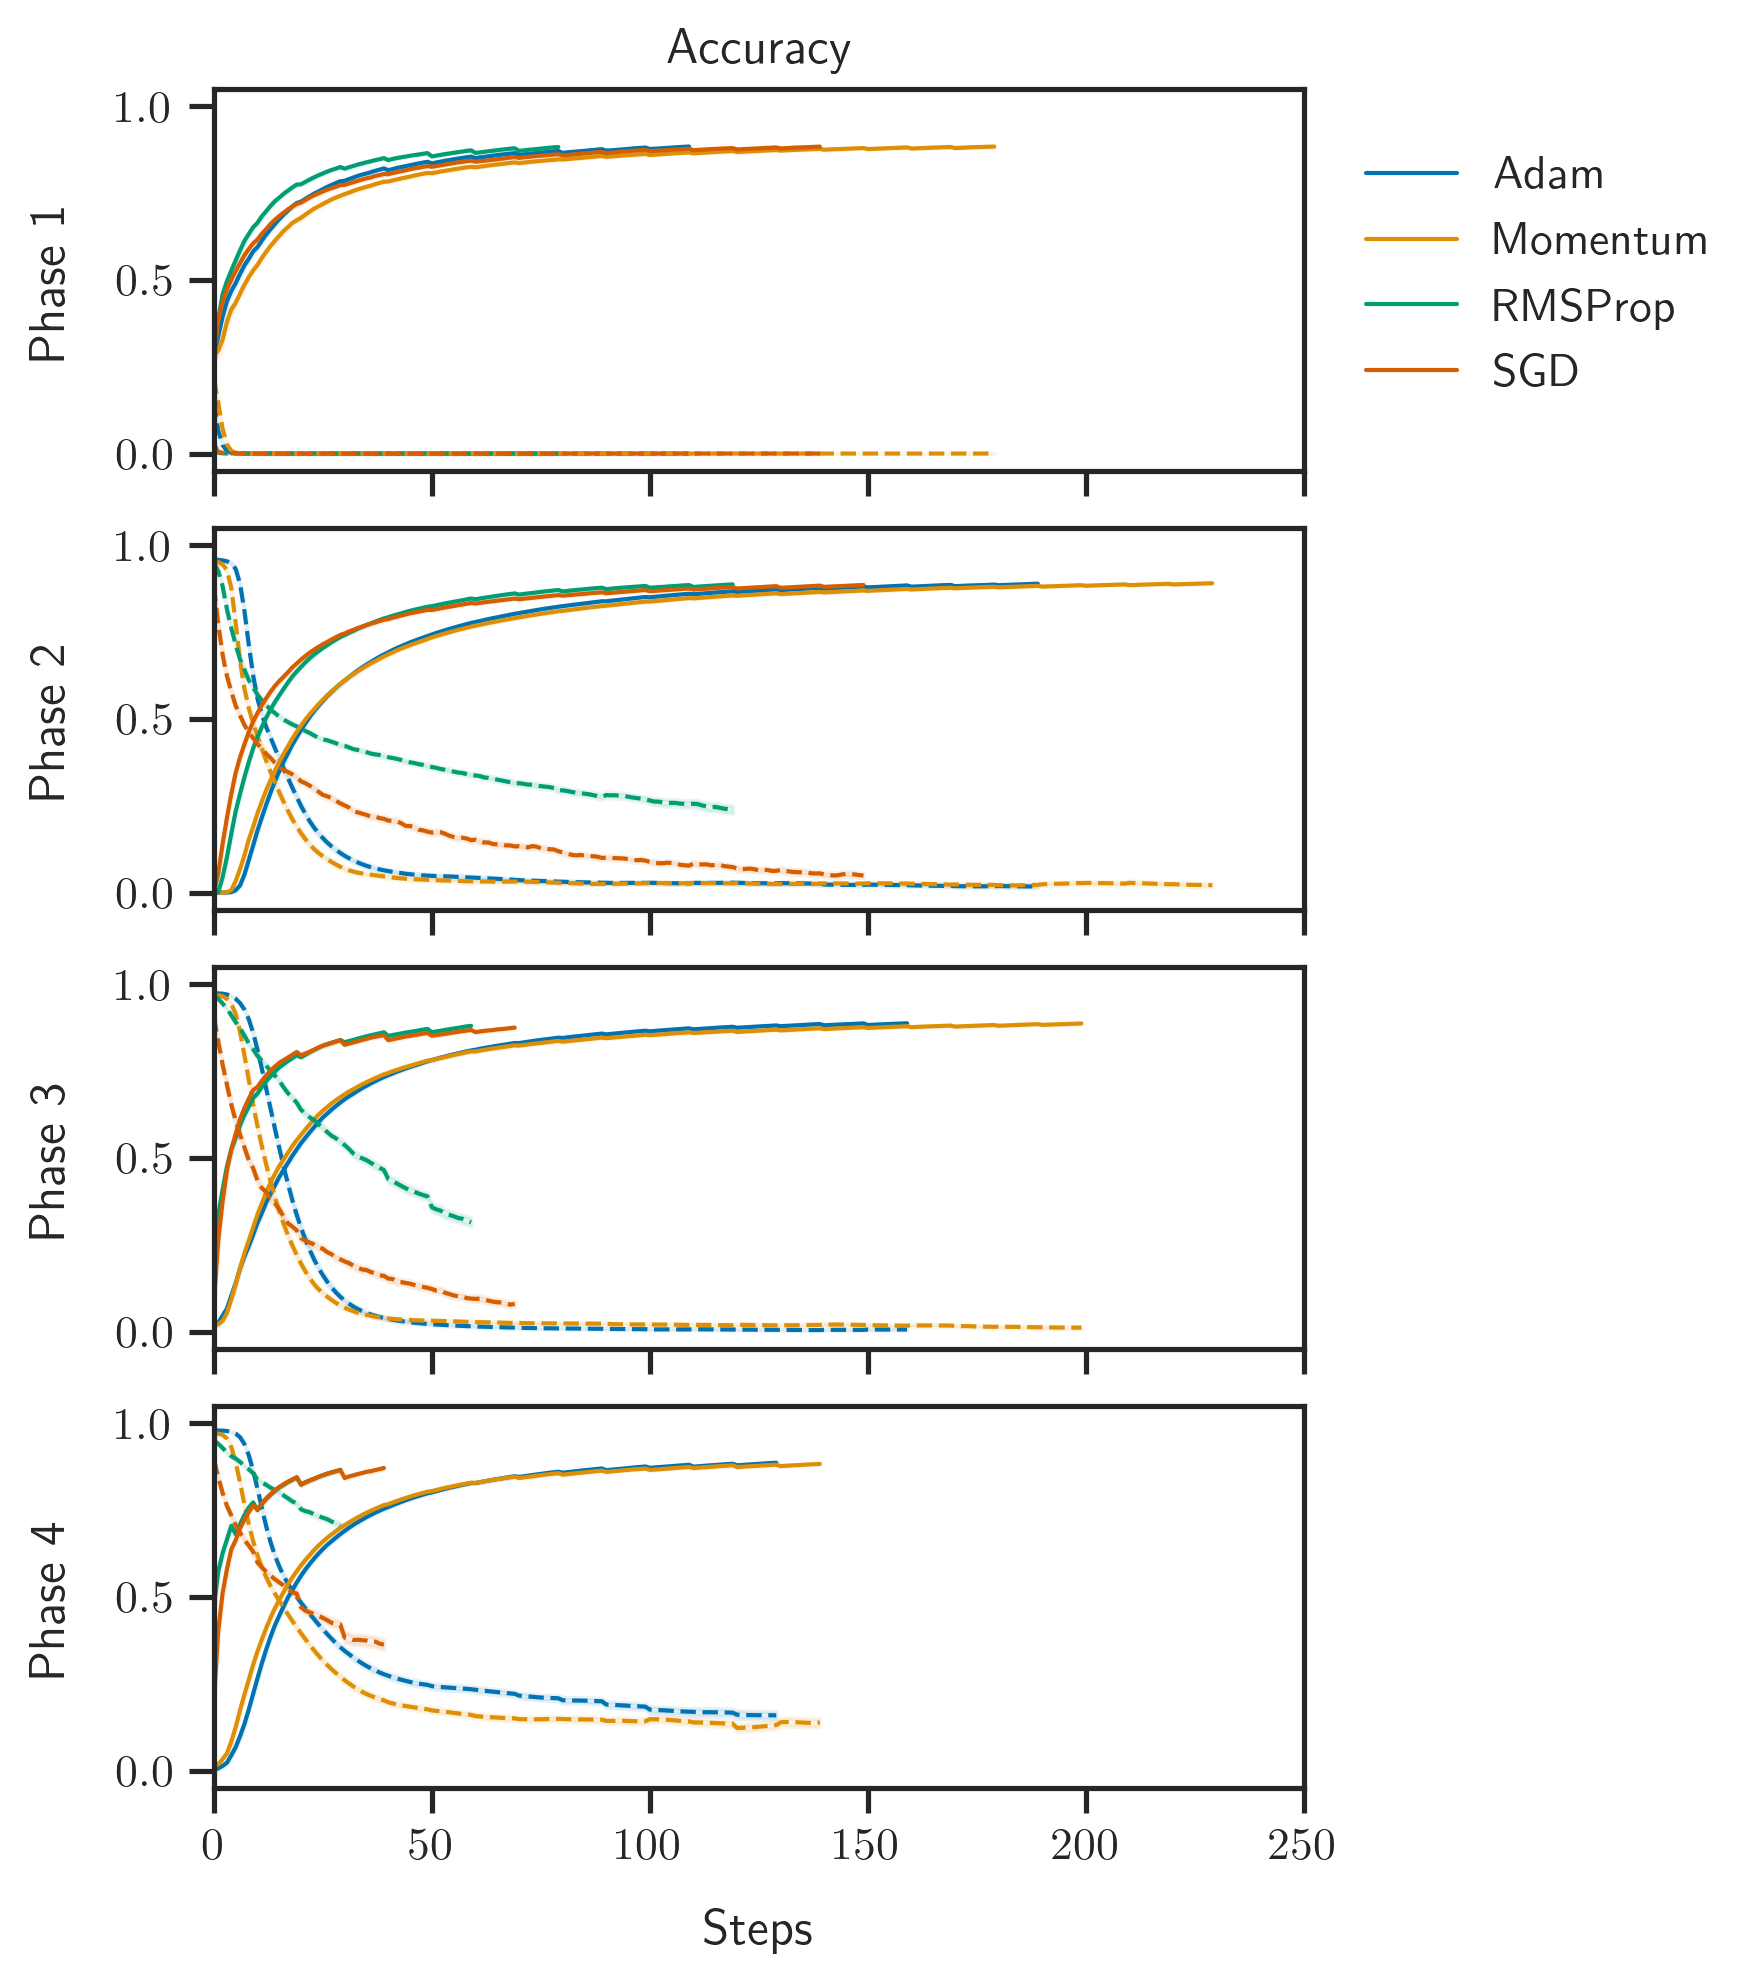

In [17]:
plot_data = {k: v for k, v in data.items() if (len(k) == 1) or ((k[0] == 'momentum') and (k[1] == 0.9)) or ((k[0] == 'rms') and (k[1] == 0.999))}
threshold = 125
fig, axarr = plt.subplots(4, 1, figsize=(4.6875, 7.5), dpi=300, sharex=True)
colors = sns.color_palette('colorblind', len(plot_data.keys()))
xmax = 0
for j in range(len(axarr)):
    ax = axarr[j]
    for i, (k, v) in enumerate(sorted(plot_data.items(), key=lambda x: x[0])):
        other_phase = (j + 1) % 2 + 1
        x = np.where(v['d{}_count'.format(other_phase)][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['d{}_avg'.format(other_phase)][j][x]
        yerr = v['d{}_sem'.format(other_phase)][j][x]
        ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        ax.plot(x, y, color=colors[i], linestyle='--', linewidth=1)

        x = np.where(v['online_count'][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['online_avg'][j][x]
        yerr = v['online_sem'][j][x]
        ax.fill_between(x, y - yerr, y + yerr, color=colors[i], alpha=0.1)
        ax.plot(x, y, label=optimizer_nice_names[k[0]], color=colors[i], linestyle='-', linewidth=1)
for j in range(len(axarr)):
    ax = axarr[j]
    ax.set_ylim(-0.05, 1.05)
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xlim((0, xmax * 1.05))
    ax.set_ylabel('Phase {}'.format(j + 1), labelpad=10)
axarr[0].set_title('Accuracy')
axarr[-1].set_xticks([0, 50, 100, 150, 200, 250])
axarr[-1].set_xlim(0, 250)
axarr[-1].set_xlabel('Steps', labelpad=10)
plt.legend(frameon=False, loc=(1.04, 3.6))
fig.subplots_adjust(hspace=0.15)
fig.savefig('experiment_2_mnist_accuracies.pdf', bbox_inches='tight')

In [18]:
phase_lengths = [{optimizer: list() for optimizer in rdf['optimizer'].unique()} for _ in range(4)]
for _, row in rdf.iterrows():
    if (row['optimizer'] == 'momentum') and (row['momentum'] != 0.9):
        continue
    if (row['optimizer'] == 'rms') and (row['rho'] != 0.999):
        continue
    for i in range(4):
        phase_lengths[i][row['optimizer']].append(row['phase_length'][i])
text = ''
text += '|-----------|------------------|------------------|------------------|------------------|\n'
text += '| Optimizer | Steps in Phase 1 | Steps in Phase 2 | Steps in Phase 3 | Steps in Phase 4 |\n'
text += '|-----------|------------------|------------------|------------------|------------------|\n'
for optimizer in sorted(list(phase_lengths[0].keys())):
    text += '| {0:>9} |   {1:>6.2f}+-{2:<4.2f}   |   {3:>6.2f}+-{4:<4.2f}   |   {5:>6.2f}+-{6:<4.2f}   |   {7:>6.2f}+-{8:<4.2f}   |\n'.format(
        optimizer_nice_names[optimizer],
        np.mean(phase_lengths[0][optimizer]), np.std(phase_lengths[0][optimizer]) / np.sqrt(len(phase_lengths[0][optimizer])),
        np.mean(phase_lengths[1][optimizer]), np.std(phase_lengths[1][optimizer]) / np.sqrt(len(phase_lengths[1][optimizer])),
        np.mean(phase_lengths[2][optimizer]), np.std(phase_lengths[2][optimizer]) / np.sqrt(len(phase_lengths[2][optimizer])),
        np.mean(phase_lengths[3][optimizer]), np.std(phase_lengths[3][optimizer]) / np.sqrt(len(phase_lengths[3][optimizer])))
text += '|-----------|------------------|------------------|------------------|------------------|'
with open('experiment_2_mnist_speed.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|-----------|------------------|------------------|------------------|------------------|
| Optimizer | Steps in Phase 1 | Steps in Phase 2 | Steps in Phase 3 | Steps in Phase 4 |
|-----------|------------------|------------------|------------------|------------------|
|      Adam |    82.98+-1.78   |   161.58+-1.80   |   136.14+-1.78   |   110.78+-1.45   |
|  Momentum |   135.88+-2.86   |   192.18+-2.38   |   155.03+-2.67   |   116.55+-1.90   |
|   RMSProp |    60.19+-1.25   |   100.08+-1.28   |    49.29+-1.11   |    24.54+-0.81   |
|       SGD |   105.67+-2.26   |   120.82+-1.97   |    52.12+-1.51   |    29.81+-0.90   |
|-----------|------------------|------------------|------------------|------------------|


In [19]:
accuracies = {name: [[list() for j in range(2)] for i in range(4)] for name in list(set(rdf['optimizer'].unique()) - {'constant'})}
for _, row in rdf.iterrows():
    if row['optimizer'] == 'constant':
        continue
    if (row['optimizer'] == 'momentum') and (row['momentum'] != 0.9):
        continue
    if (row['optimizer'] == 'rms') and (row['rho'] != 0.999):
        continue
    for i in range(4):
        for j in range(2):
            accuracies[row['optimizer']][i][j].append(row['accuracies'][sum(row['phase_length'][:i + 1]) - 1][j])
text = ''
text += '|-----------|-------|-------------------|-------------------|\n'
text += '| Optimizer | Phase | Accuracy on 1 + 2 | Accuracy on 3 + 4 |\n'
text += '|-----------|-------|-------------------|-------------------|\n'
for optimizer in sorted(list(accuracies.keys())):
    for phase in range(4):
        if (optimizer != 'adam') and (phase == 0):
            text += '|-----------|-------|-------------------|-------------------|\n'
        text += '| {0:>9} |   {1}   |  {2:>6.4f}+-{3:<6.4f}   |  {4:>6.4f}+-{5:<6.4f}   |\n'.format(
            optimizer_nice_names[optimizer] if phase == 1 else '',
            phase,
            np.mean(accuracies[optimizer][phase][0]), np.std(accuracies[optimizer][phase][0]) / np.sqrt(len(accuracies[optimizer][phase][0])),
            np.mean(accuracies[optimizer][phase][1]), np.std(accuracies[optimizer][phase][1]) / np.sqrt(len(accuracies[optimizer][phase][1])))
text += '|-----------|-------|-------------------|-------------------|\n'
with open('experiment_2_mnist_retention.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|-----------|-------|-------------------|-------------------|
| Optimizer | Phase | Accuracy on 1 + 2 | Accuracy on 3 + 4 |
|-----------|-------|-------------------|-------------------|
|           |   0   |  0.9580+-0.0031   |  0.0000+-0.0000   |
|      Adam |   1   |  0.0200+-0.0025   |  0.9741+-0.0007   |
|           |   2   |  0.9790+-0.0006   |  0.0059+-0.0010   |
|           |   3   |  0.2032+-0.0068   |  0.9778+-0.0006   |
|-----------|-------|-------------------|-------------------|
|           |   0   |  0.9533+-0.0035   |  0.0000+-0.0000   |
|  Momentum |   1   |  0.0177+-0.0023   |  0.9689+-0.0010   |
|           |   2   |  0.9701+-0.0015   |  0.0171+-0.0027   |
|           |   3   |  0.1527+-0.0068   |  0.9703+-0.0011   |
|-----------|-------|-------------------|-------------------|
|           |   0   |  0.9573+-0.0032   |  0.0000+-0.0000   |
|   RMSProp |   1   |  0.2635+-0.0061   |  0.9756+-0.0005   |
|           |   2   |  0.9615+-0.0028   |  0.4645+-0.0101   |
|       

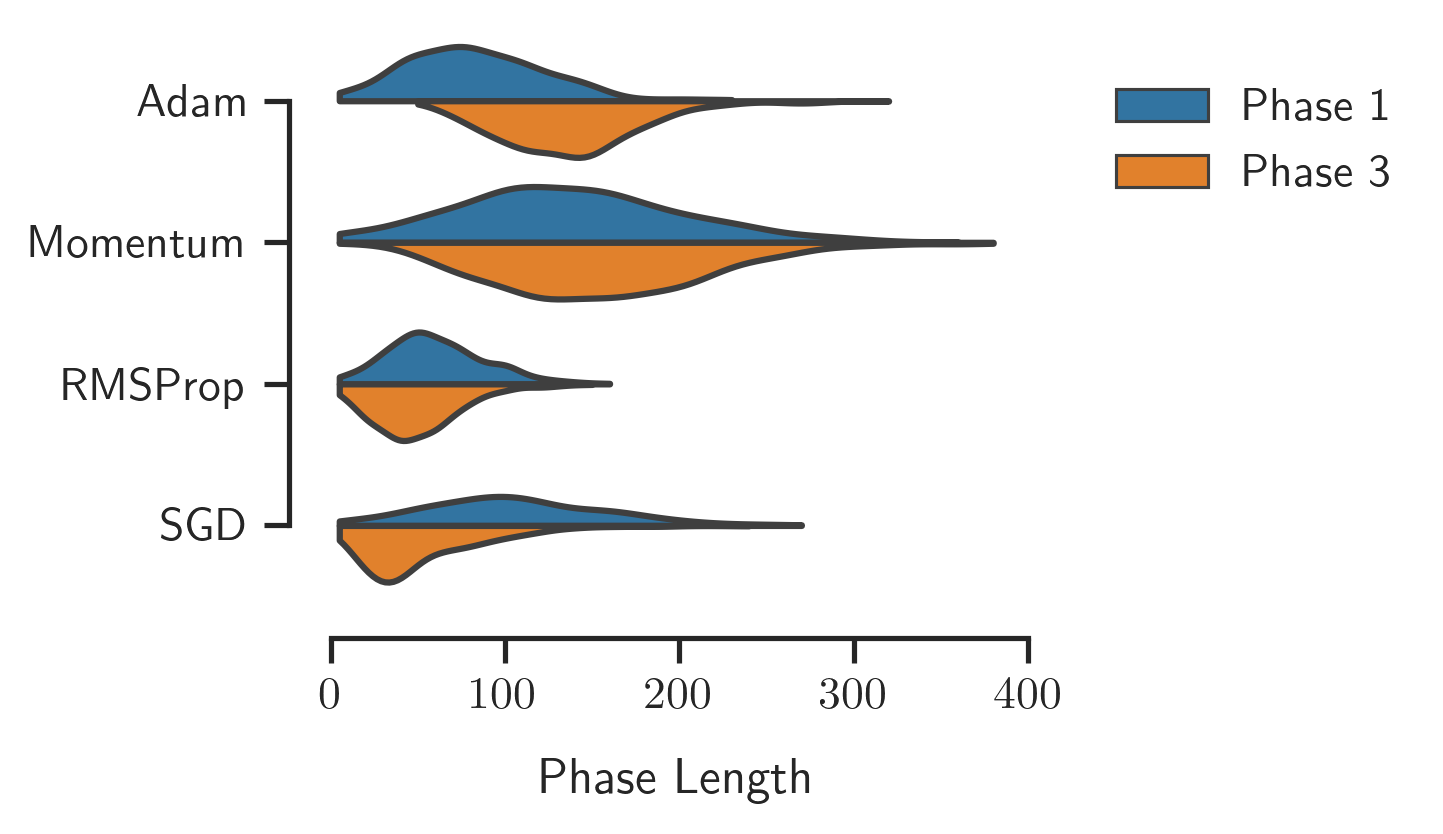

In [20]:
phase_lengths = [{optimizer: list() for optimizer in rdf['optimizer'].unique()} for _ in range(4)]
for _, row in rdf.iterrows():
    if (row['optimizer'] == 'momentum') and (row['momentum'] != 0.9):
        continue
    if (row['optimizer'] == 'rms') and (row['rho'] != 0.999):
        continue
    for i in range(4):
        phase_lengths[i][row['optimizer']].append(row['phase_length'][i])
boxplot_data = {'optimizer': [], 'phase': [], 'phase_length': []}
for optimizer in sorted(list(phase_lengths[2].keys())):
    for i in range(len(phase_lengths[0][optimizer])):
        first_phase_length = phase_lengths[0][optimizer][i]
        third_phase_length = phase_lengths[2][optimizer][i]
        boxplot_data['optimizer'].append(optimizer_nice_names[optimizer])
        boxplot_data['phase'].append('Phase 1')
        boxplot_data['phase_length'].append(first_phase_length)
        boxplot_data['optimizer'].append(optimizer_nice_names[optimizer])
        boxplot_data['phase'].append('Phase 3')
        boxplot_data['phase_length'].append(third_phase_length)
fig, ax = plt.subplots(1, 1, figsize=(3, 2.5), dpi=300)
ax.set_xlabel('Phase Length', labelpad=10)
sns.violinplot(x='phase_length', y='optimizer', hue='phase', data=boxplot_data, cut=0, split=True, inner=None, ax=ax)
ax.set_xlim(0, 400)
ax.set_xticks([0, 100, 200, 300, 400])
sns.despine(offset=10, trim=True)
plt.legend(frameon=False, loc=(1.1, 0.675))
fig.savefig('experiment_2_mnist_relearning.pdf', bbox_inches='tight')

In [21]:
ratios = {optimizer: list() for optimizer in rdf['optimizer'].unique()}
for _, row in rdf.iterrows():
    if (row['optimizer'] == 'momentum') and (row['momentum'] != 0.9):
        continue
    if (row['optimizer'] == 'rms') and (row['rho'] != 0.999):
        continue
    ratios[row['optimizer']].append(row['phase_length'][0] / row['phase_length'][2])

text = ''
text += '|-----------|------------|\n'
text += '| Optimizer | Relearning |\n'
text += '|---------- |------------|\n'
for optimizer in sorted(list(ratios.keys())):
    text += '| {0:>9} | {1:>4.2f}+-{2:<4.2f} |\n'.format(
        optimizer_nice_names[optimizer],
        np.mean(ratios[optimizer]),
        np.std(ratios[optimizer]) / np.sqrt(len(ratios[optimizer])))
text += '|---------- |------------|\n'
with open('experiment_2_mnist_relearning.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|-----------|------------|
| Optimizer | Relearning |
|---------- |------------|
|      Adam | 0.67+-0.02 |
|  Momentum | 1.18+-0.07 |
|   RMSProp | 1.80+-0.09 |
|       SGD | 3.43+-0.18 |
|---------- |------------|



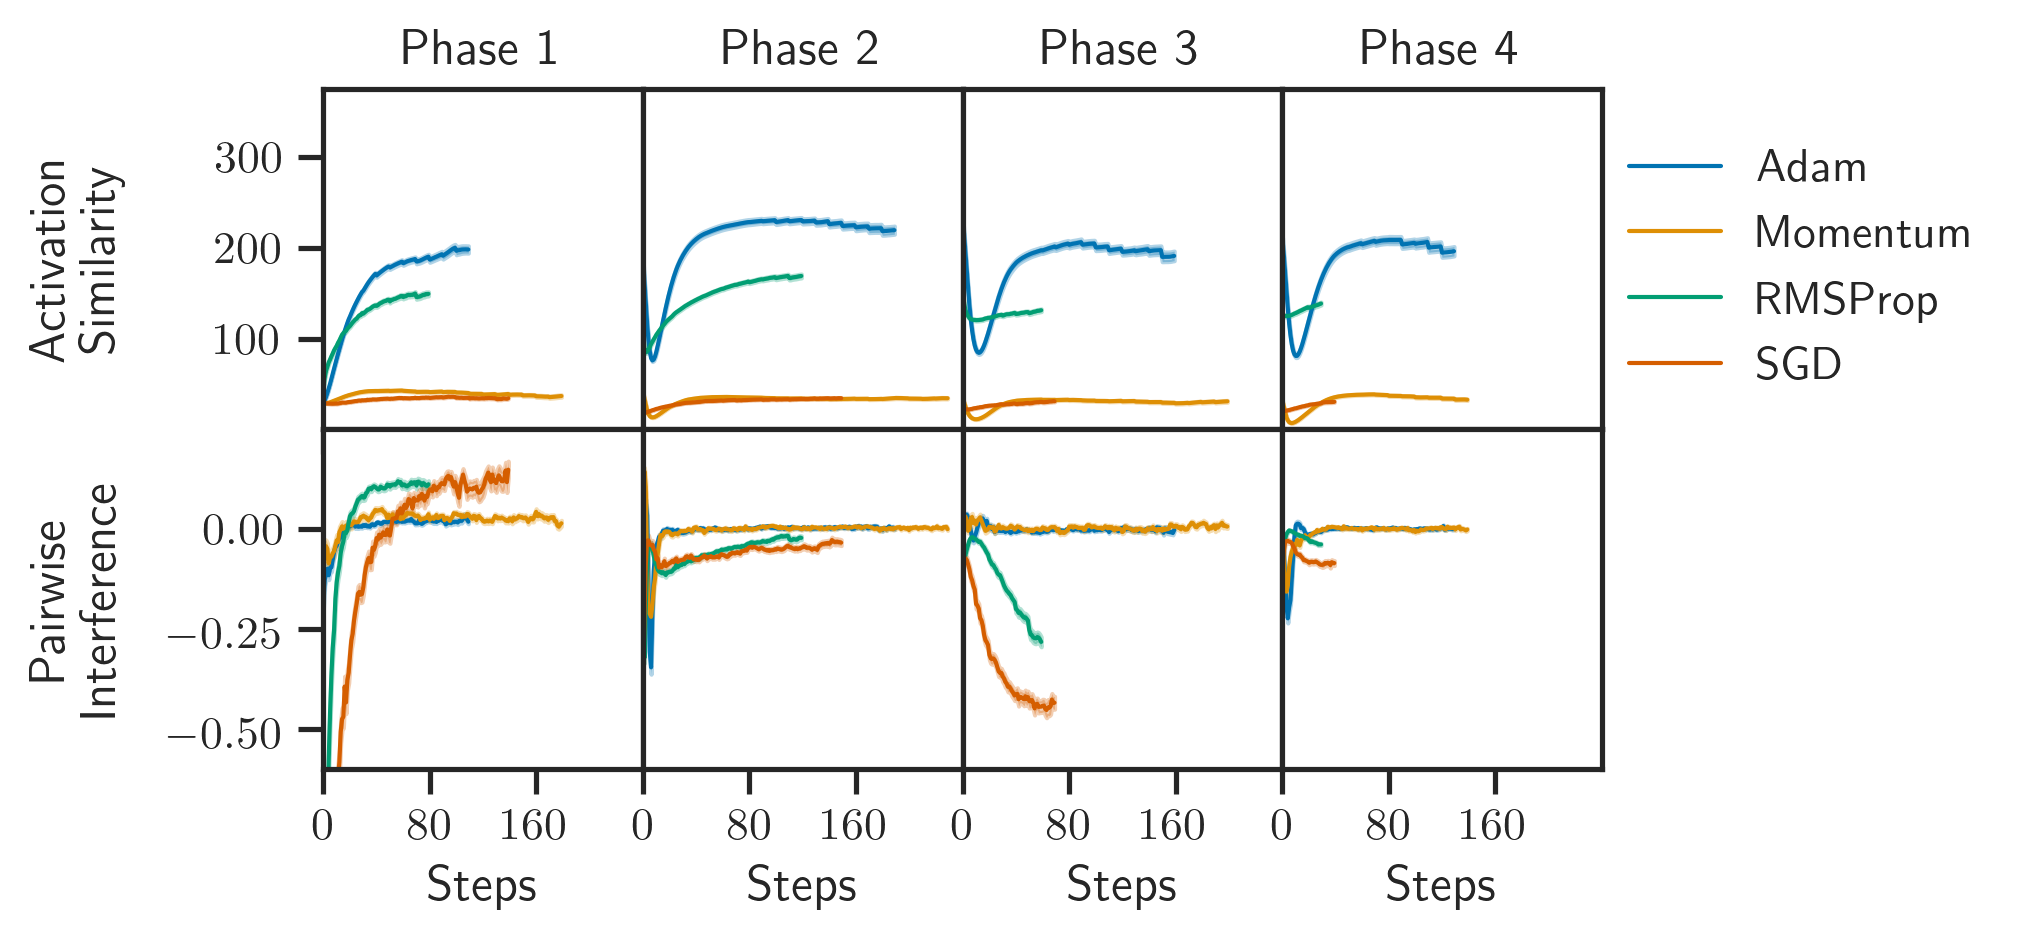

In [22]:
plot_data = {k: v for k, v in data.items() if (len(k) == 1) or ((k[0] == 'momentum') and (k[1] == 0.9)) or ((k[0] == 'rms') and (k[1] == 0.999))}
threshold = 125
fig, axmat = plt.subplots(2, 4, sharex=True, dpi=300, figsize=(5.5, 3))
colors = sns.color_palette('colorblind', len(data.keys()))
xmax = 0
for j in range(4):
    for i, (k, v) in enumerate(sorted(plot_data.items(), key=lambda x: x[0])):
        x = np.where(v['as_count'][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['as_avg'][j][x]
        yerr = v['as_sem'][j][x]
        label = optimizer_nice_names[k[0]] if j == 0 else None
        axmat[0, j].plot(
            x,
            y,
            label=label,
            linewidth=1,
            color=colors[i])
        axmat[0, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)
    
        x = np.where(v['pi_count'][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['pi_avg'][j][x]
        yerr = v['pi_sem'][j][x]
        axmat[1, j].plot(
            x,
            y,
            linewidth=1,
            color=colors[i])
        axmat[1, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)

axmat[0, 0].set_ylabel('Activation\nSimilarity', labelpad=10)
axmat[1, 0].set_ylabel('Pairwise\nInterference', labelpad=10)
for i in range(4):
    axmat[0, i].set_title('Phase {}'.format(i + 1))
    axmat[1, i].set_xticks([0, 80, 160])
    axmat[1, i].set_xlabel('Steps')
    axmat[0, i].set_ylim(0, 375)
    axmat[0, i].set_yticks([100, 200, 300])
    axmat[1, i].set_ylim(- 0.6, 0.25)
    axmat[1, i].set_yticks([- 0.5, - 0.25, 0.0])
    for j in range(2):
        axmat[j, i].set_xlim(0, xmax * 1.05)
        if i != 0:
            axmat[j, i].tick_params(axis='y', which='both', left=False)
            axmat[j, i].set_yticklabels([])
axmat[0, 0].legend(loc='upper right', bbox_to_anchor=(5.3, 0.95), frameon=False)
fig.align_ylabels(axmat[:, 0])
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig('experiment_2_mnist_additional_interference.pdf', bbox_inches='tight')

In [23]:
accuracy = {optimizer: dict() for optimizer in ['momentum', 'rms']}
retention = copy.deepcopy(accuracy)
relearning = copy.deepcopy(accuracy)
for _, row in rdf.iterrows():
    optimizer = row['optimizer']
    if optimizer == 'momentum':
        gamma = row['momentum']
    elif optimizer == 'rms':
        gamma = row['rho']
    else:
        continue
    if gamma not in accuracy[optimizer]:
        assert(gamma not in retention[optimizer])
        assert(gamma not in relearning[optimizer])
        accuracy[optimizer][gamma] = list()
        retention[optimizer][gamma] = list()
        relearning[optimizer][gamma] = list()
    accuracy[optimizer][gamma].append(row['accuracies'][sum(row['phase_length'][:1]) - 1][0])
    retention[optimizer][gamma].append(row['accuracies'][sum(row['phase_length'][:2]) - 1][0])
    relearning[optimizer][gamma].append(row['phase_length'][0] / row['phase_length'][2])
    
    
text = ''
text += '|-----------|--------|----------------|----------------|\n'
text += '| Optimizer | Gamma  |   Retention    |   Relearning   |\n'
text += '|-----------|--------|----------------|----------------|\n'
for optimizer in sorted(list(accuracy.keys())):
    for i, gamma in enumerate(sorted(accuracy[optimizer].keys())):
        text += '| {0:>9} | {1}  | {2:>6.4f}+-{3:<6.4f} | {4:>6.4f}+-{5:<6.4f} |\n'.format(
            optimizer_nice_names[optimizer] if i == 1 else '',
            str(gamma).ljust(5),
            np.mean(retention[optimizer][gamma]),
            np.std(retention[optimizer][gamma]) / np.sqrt(len(retention[optimizer][gamma])),
            np.mean(relearning[optimizer][gamma]),
            np.std(relearning[optimizer][gamma]) / np.sqrt(len(relearning[optimizer][gamma])))
    text += '|-----------|--------|----------------|----------------|\n'
with open('experiment_2_mnist_interference_momentum_and_rms.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|-----------|--------|----------------|----------------|
| Optimizer | Gamma  |   Retention    |   Relearning   |
|-----------|--------|----------------|----------------|
|           | 0.81   | 0.0378+-0.0035 | 1.5635+-0.0577 |
|  Momentum | 0.9    | 0.0177+-0.0023 | 1.1817+-0.0749 |
|           | 0.99   | 0.0032+-0.0010 | 0.3553+-0.0115 |
|-----------|--------|----------------|----------------|
|           | 0.81   | 0.0336+-0.0034 | 1.5068+-0.0685 |
|   RMSProp | 0.9    | 0.0687+-0.0045 | 2.1629+-0.1016 |
|           | 0.99   | 0.2263+-0.0065 | 2.0151+-0.0911 |
|           | 0.999  | 0.2635+-0.0061 | 1.8019+-0.0851 |
|-----------|--------|----------------|----------------|



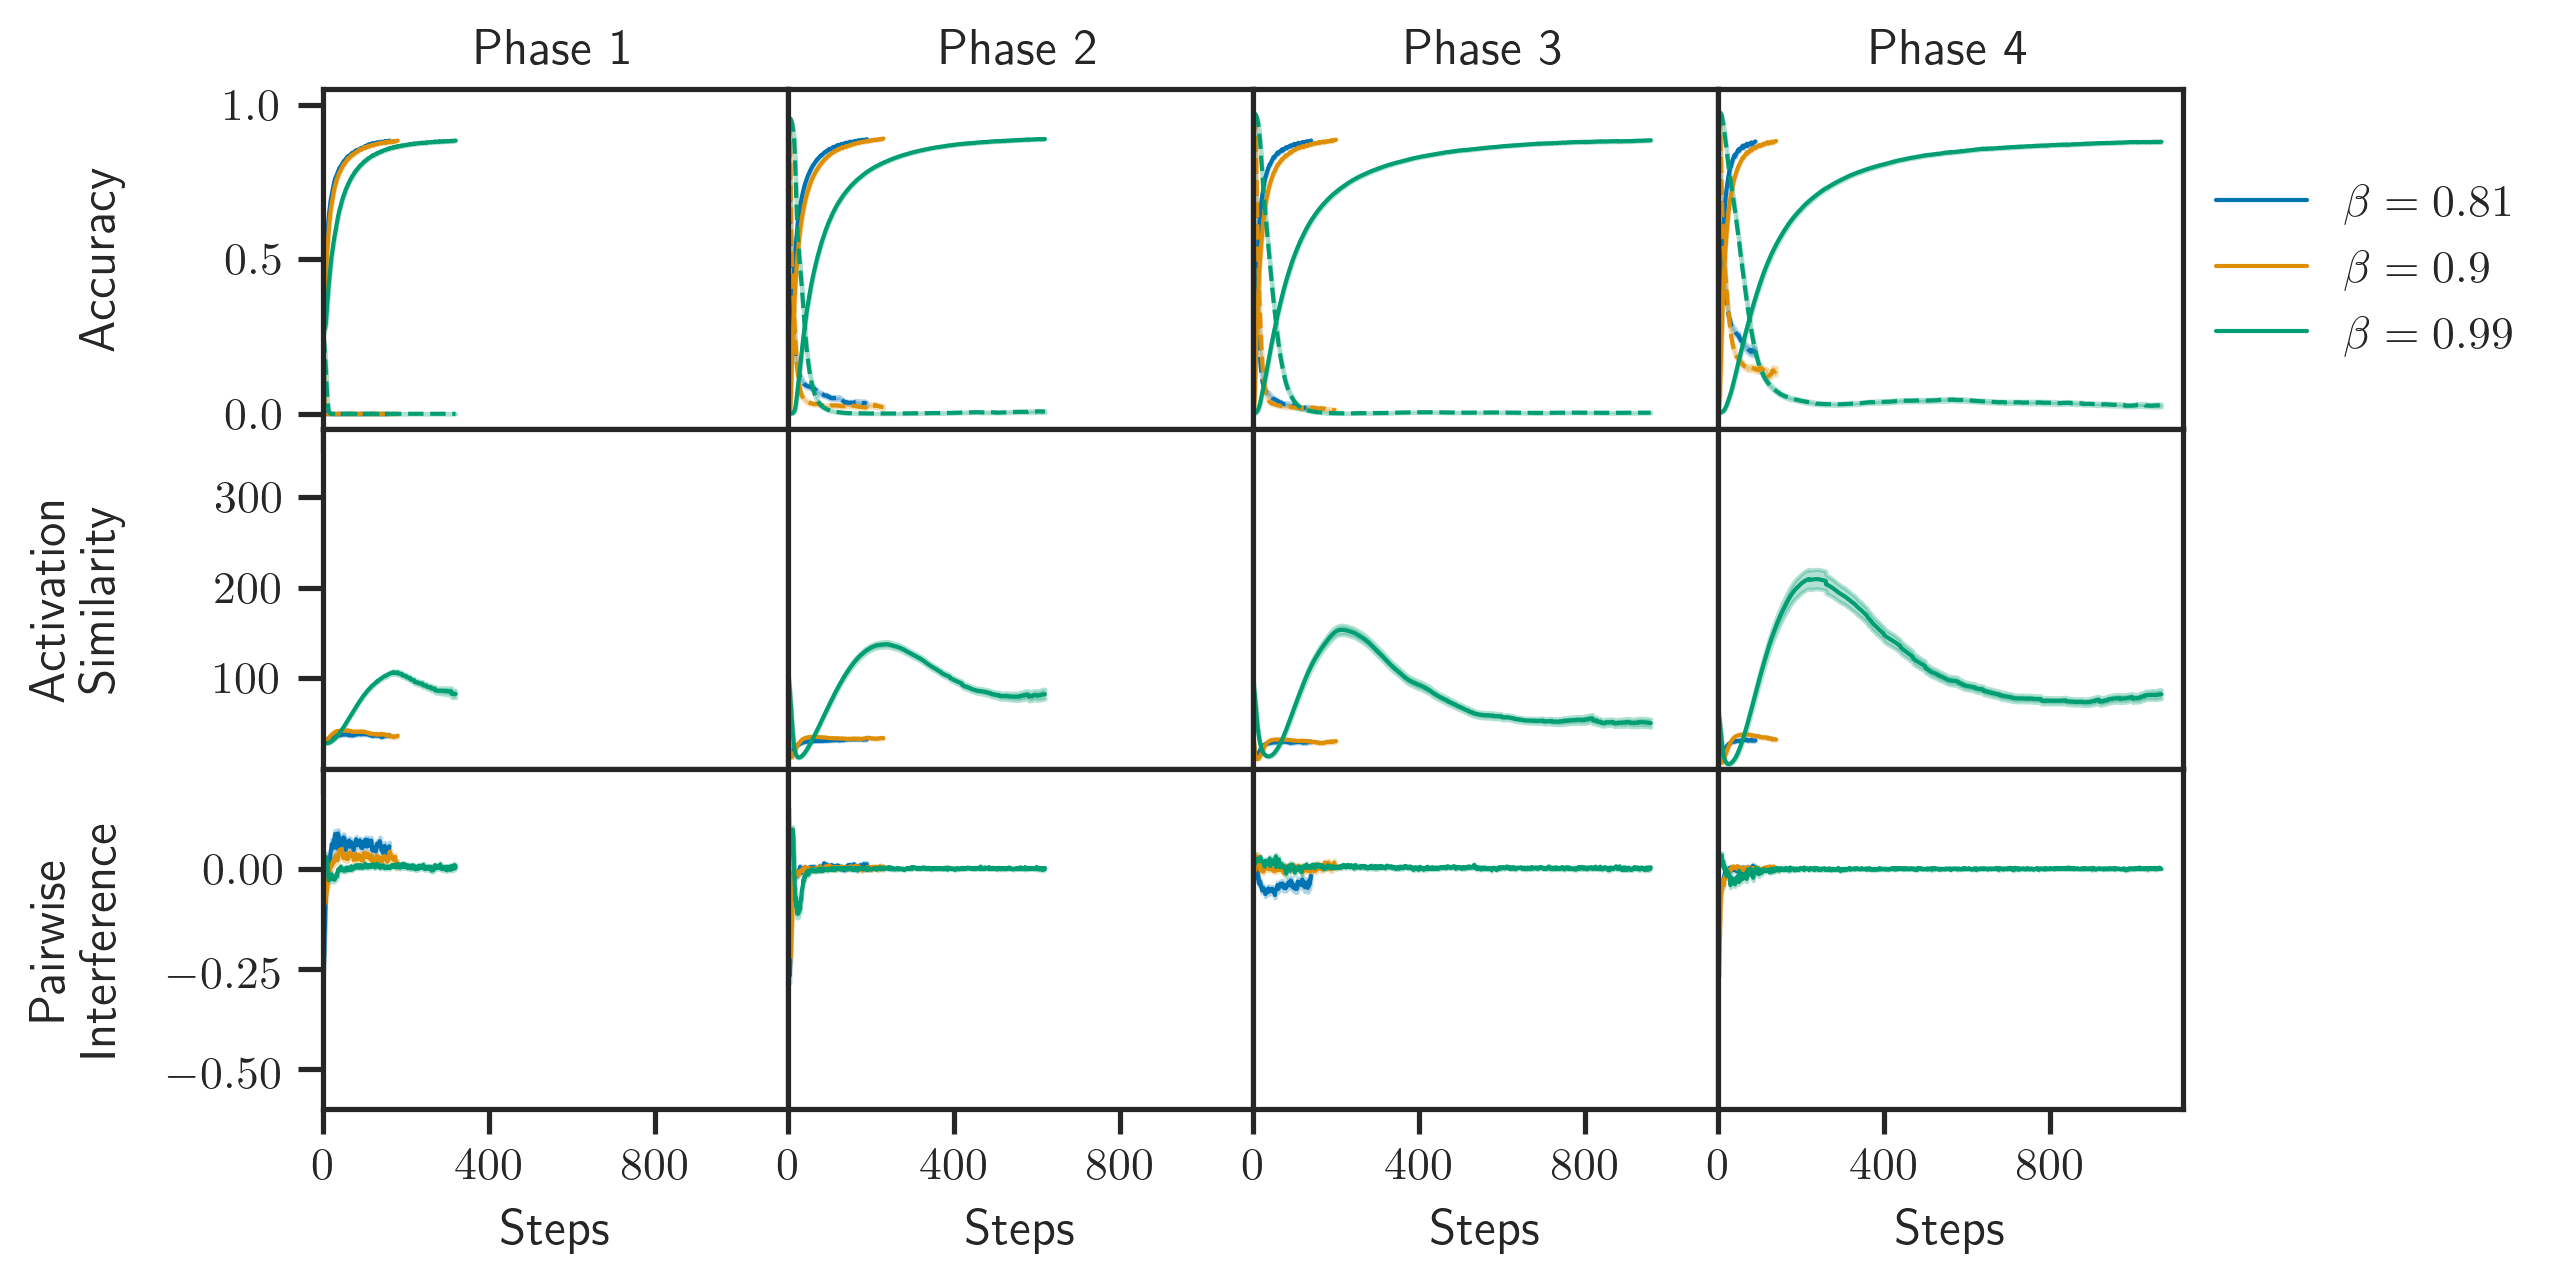

In [24]:
plot_data = {
    r'$\beta={}$'.format(k[1]) : v
    for k, v in data.items()
    if k[0] == 'momentum'}
threshold = 125
fig, axmat = plt.subplots(3, 4, sharex=True, dpi=300, figsize=(8, 4.5))
colors = sns.color_palette('colorblind', len(data.keys()))
xmax = 0
for j in range(4):
    for i, (k, v) in enumerate(sorted(plot_data.items(), key=lambda x: x[0])):
        other_phase = (j + 1) % 2 + 1
        x = np.where(v['d{}_count'.format(other_phase)][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['d{}_avg'.format(other_phase)][j][x]
        yerr = v['d{}_sem'.format(other_phase)][j][x]
        label = k if j == 0 else None
        axmat[0, j].plot(
            x,
            y,
            linestyle='--',
            linewidth=1,
            color=colors[i])
        axmat[0, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)
        
        x = np.where(v['online_count'][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['online_avg'][j][x]
        yerr = v['online_sem'][j][x]
        axmat[0, j].plot(
            x,
            y,
            label=label,
            linewidth=1,
            color=colors[i])
        axmat[0, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)

        x = np.where(v['as_count'][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['as_avg'][j][x]
        yerr = v['as_sem'][j][x]
        axmat[1, j].plot(
            x,
            y,
            linewidth=1,
            color=colors[i])
        axmat[1, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)

        x = np.where(v['pi_count'][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['pi_avg'][j][x]
        yerr = v['pi_sem'][j][x]
        axmat[2, j].plot(
            x,
            y,
            linewidth=1,
            color=colors[i])
        axmat[2, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)

axmat[0, 0].set_ylabel('Accuracy', labelpad=10)
axmat[1, 0].set_ylabel('Activation\nSimilarity', labelpad=10)
axmat[2, 0].set_ylabel('Pairwise\nInterference', labelpad=10)
for i in range(4):
    axmat[0, i].set_title('Phase {}'.format(i + 1))
    axmat[0, i].set_ylim(-0.05, 1.05)
    axmat[0, i].set_yticks([0.0, 0.5, 1.0])
    axmat[1, i].set_ylim(0, 375)
    axmat[1, i].set_yticks([100, 200, 300])
    axmat[2, i].set_ylim(- 0.6, 0.25)
    axmat[2, i].set_yticks([- 0.5, - 0.25, 0.0])
    axmat[2, i].set_xticks([0, 400, 800])
    axmat[2, i].set_xlabel('Steps', labelpad=5)
    for j in range(3):
        axmat[j, i].set_xlim(0, xmax * 1.05)
        if i != 0:
            axmat[j, i].tick_params(axis='y', which='both', left=False)
            axmat[j, i].set_yticklabels([])
fig.align_ylabels(axmat[:, 0])
axmat[0, 0].legend(loc='upper right', bbox_to_anchor=(4.8, 0.85), frameon=False)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig('experiment_2_mnist_additional_interference_momentum.pdf', bbox_inches='tight')

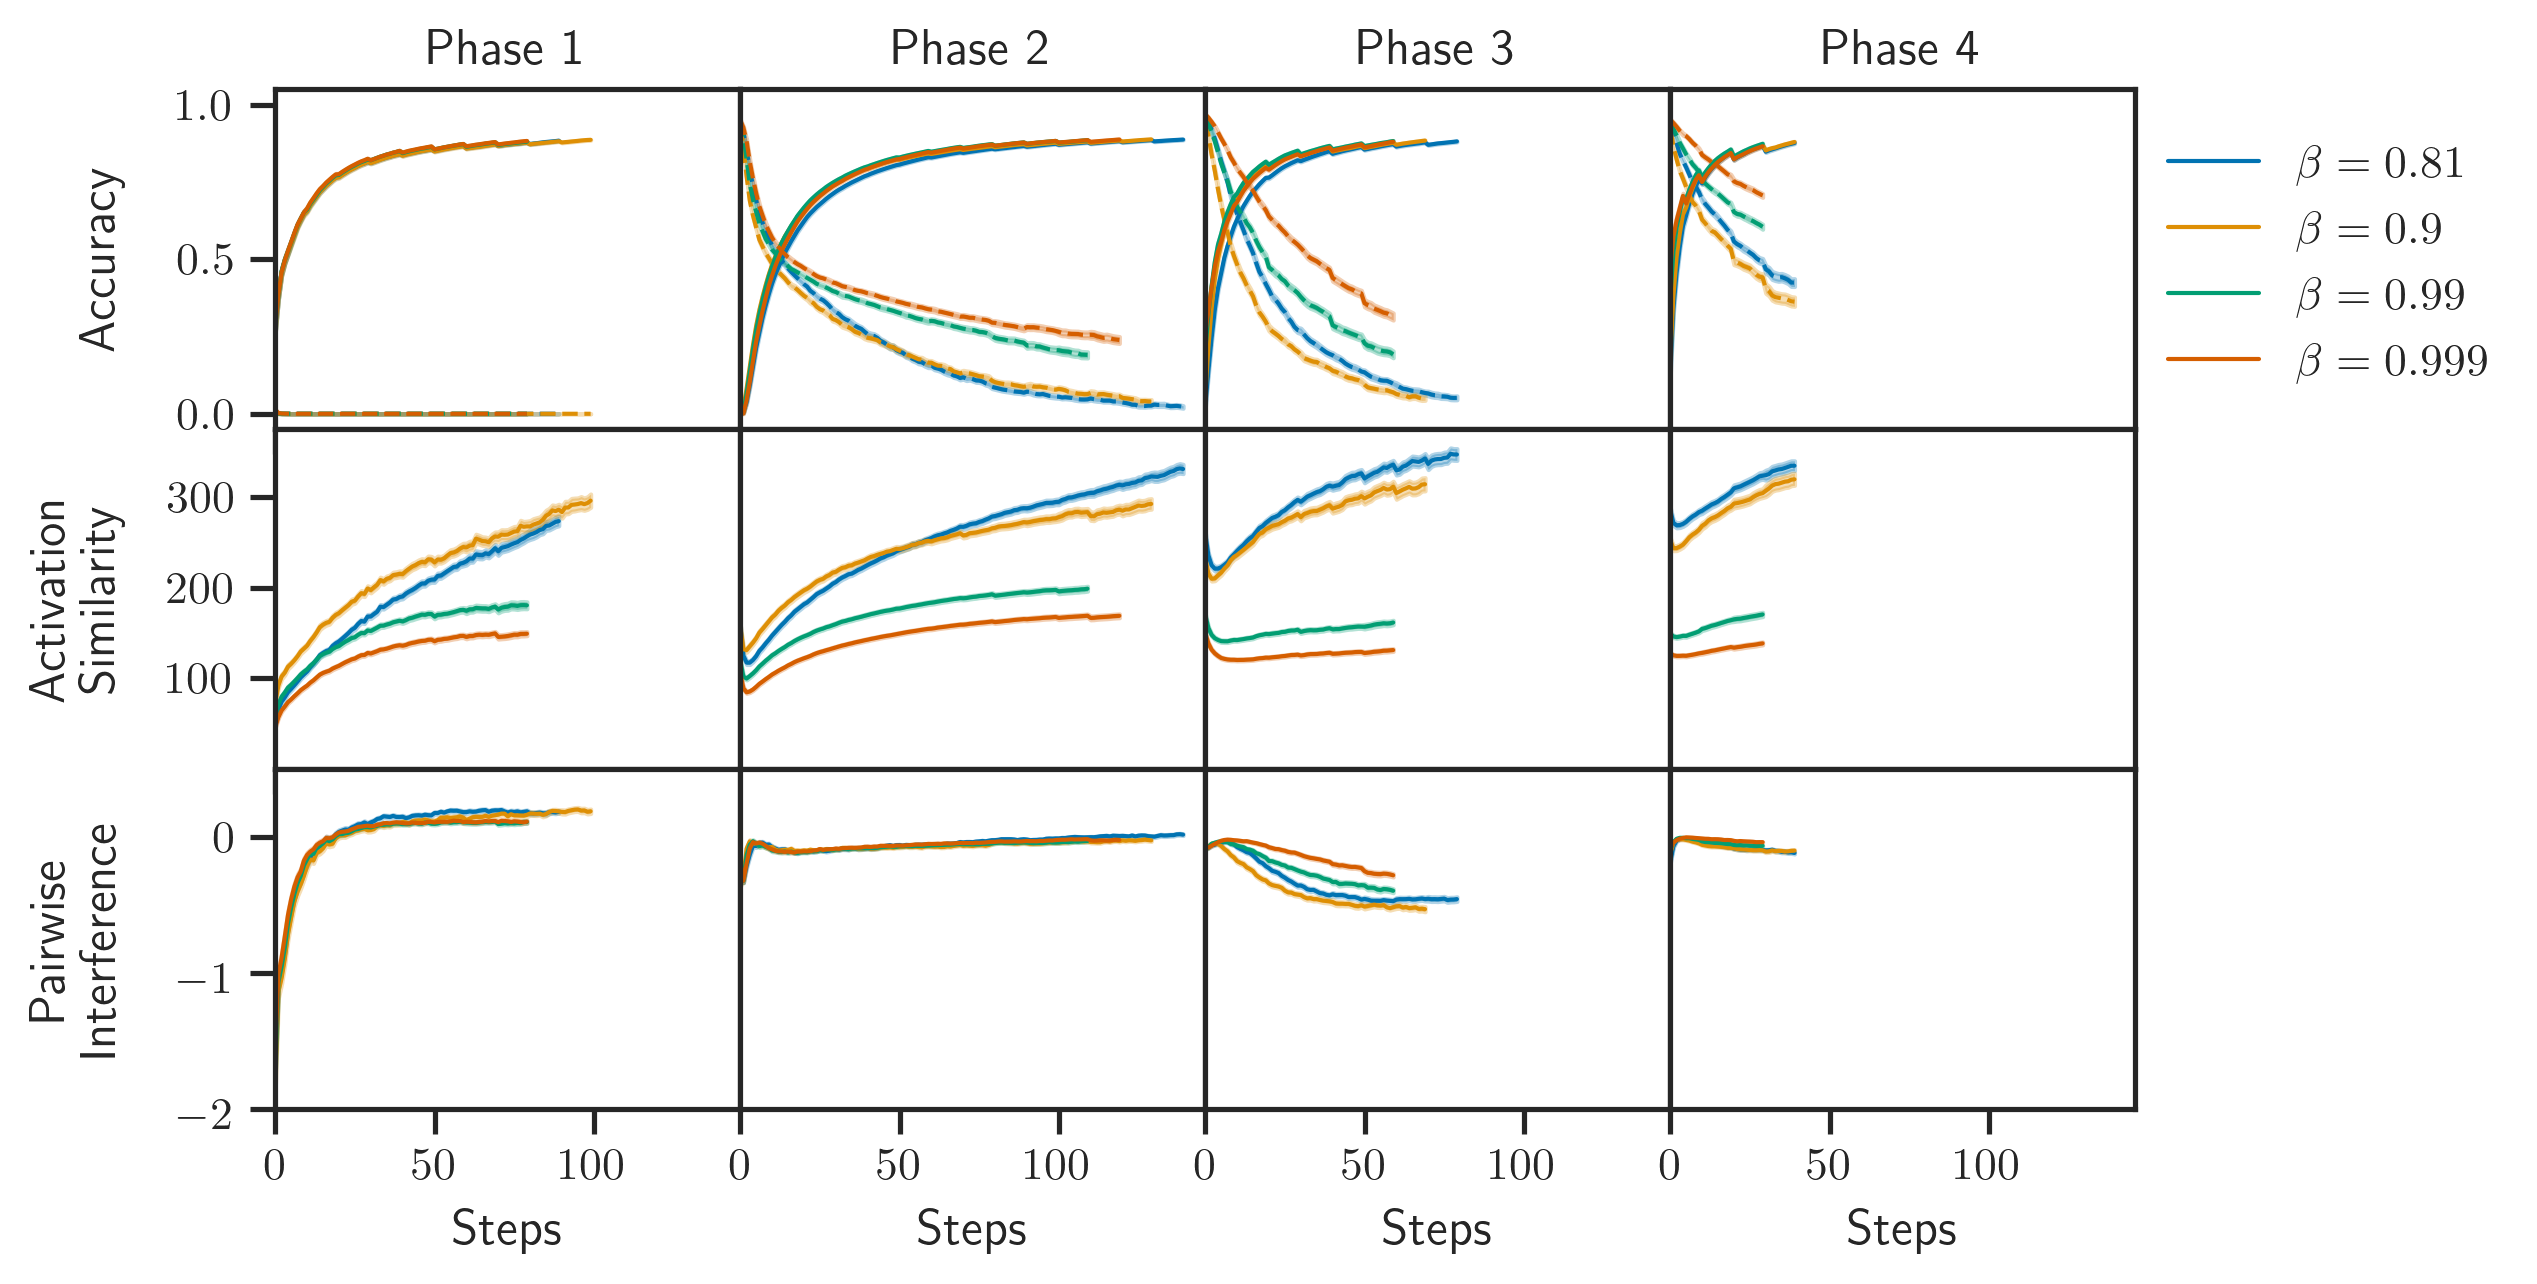

In [25]:
plot_data = {
    r'$\beta={}$'.format(k[1]) : v
    for k, v in data.items()
    if k[0] == 'rms'}
threshold = 125
fig, axmat = plt.subplots(3, 4, sharex=True, dpi=300, figsize=(8, 4.5))
colors = sns.color_palette('colorblind', len(data.keys()))
xmax = 0
for j in range(4):
    for i, (k, v) in enumerate(sorted(plot_data.items(), key=lambda x: x[0])):
        other_phase = (j + 1) % 2 + 1
        x = np.where(v['d{}_count'.format(other_phase)][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['d{}_avg'.format(other_phase)][j][x]
        yerr = v['d{}_sem'.format(other_phase)][j][x]
        label = k if j == 0 else None
        axmat[0, j].plot(
            x,
            y,
            linestyle='--',
            linewidth=1,
            color=colors[i])
        axmat[0, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)
        
        x = np.where(v['online_count'][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['online_avg'][j][x]
        yerr = v['online_sem'][j][x]
        axmat[0, j].plot(
            x,
            y,
            label=label,
            linewidth=1,
            color=colors[i])
        axmat[0, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)

        x = np.where(v['as_count'][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['as_avg'][j][x]
        yerr = v['as_sem'][j][x]
        axmat[1, j].plot(
            x,
            y,
            linewidth=1,
            color=colors[i])
        axmat[1, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)

        x = np.where(v['pi_count'][j] >= threshold)[0]
        xmax = max(xmax, max(x))
        y = v['pi_avg'][j][x]
        yerr = v['pi_sem'][j][x]
        axmat[2, j].plot(
            x,
            y,
            linewidth=1,
            color=colors[i])
        axmat[2, j].fill_between(
            x,
            y - yerr,
            y + yerr,
            color=colors[i],
            alpha=0.3)

axmat[0, 0].set_ylabel('Accuracy', labelpad=10)
axmat[1, 0].set_ylabel('Activation\nSimilarity', labelpad=10)
axmat[2, 0].set_ylabel('Pairwise\nInterference', labelpad=10)
for i in range(4):
    axmat[0, i].set_title('Phase {}'.format(i + 1))
    axmat[0, i].set_ylim(-0.05, 1.05)
    axmat[0, i].set_yticks([0.0, 0.5, 1.0])
    axmat[1, i].set_ylim(0, 375)
    axmat[1, i].set_yticks([100, 200, 300])
    axmat[2, i].set_ylim(- 2, 0.5)
    axmat[2, i].set_yticks([- 2, - 1, 0])
    axmat[2, i].set_xticks([0, 50, 100])
    axmat[2, i].set_xlabel('Steps', labelpad=5)
    for j in range(3):
        axmat[j, i].set_xlim(0, xmax * 1.05)
        if i != 0:
            axmat[j, i].tick_params(axis='y', which='both', left=False)
            axmat[j, i].set_yticklabels([])
fig.align_ylabels(axmat[:, 0])
axmat[0, 0].legend(loc='upper right', bbox_to_anchor=(4.85, 0.9625), frameon=False)
fig.subplots_adjust(wspace=0.0, hspace=0.0)
fig.savefig('experiment_2_mnist_additional_interference_rms.pdf', bbox_inches='tight')

<a href=#top>Back to Top</a>

## Experiment 2 Mountain Car<a name='experiment_2_mountain_car'/>

### Validation Phase<a name='experiment_2_mountain_car_validation'/>

In [26]:
data = mc_tools.load_data(['experiment_2_mountain_car_validation.json'])
summary = mc_tools.get_summary(data)
best = mc_tools.get_best(data, ['optimizer', 'momentum', 'rho'], 'auc', summary=summary)
best.head(n=len(best))

/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


approximator  beta_1  beta_2 lambda_  loss        lr  momentum optimizer  \
0  neural_network     NaN     NaN    None    TD  0.000173      0.81  momentum   
1  neural_network     NaN     NaN    None    TD  0.000005      0.99  momentum   
2  neural_network     NaN     NaN    None    TD  0.000086      0.90  momentum   
3  neural_network     NaN     NaN    None    TD  0.000043       NaN       rms   
4  neural_network     NaN     NaN    None    TD  0.000086       NaN       rms   
5  neural_network     NaN     NaN    None    TD  0.000043       NaN       rms   
6  neural_network     NaN     NaN    None    TD  0.002762       NaN       rms   
7  neural_network     NaN     NaN    None    TD  0.000691       NaN       sgd   
8  neural_network     0.9   0.999    None    TD  0.022097       NaN      adam   
9        constant     NaN     NaN    None  None       NaN       NaN  constant   

     rho  target_update  ...  final_activation_similarity_mean  \
0    NaN              1  ...                        226.550645   
1    NaN              1  ...                        224.486372   
2    NaN              1  ...                        210.959452   
3  0.900              1  ...                         80.281438   
4  0.990              1  ...                         70.899042   
5  0.810              1  ...                         99.581931   
6  0.999              1  ...                        194.836688   
7    NaN              1  ...                        233.413156   
8    NaN              1  ...                        238.182832   
9    NaN              1  ...                               NaN   

   final_activation_similarity_stderr  final_pairwise_interference_mean  \
0                            3.301223                       -180.761626   
1                            6.306082                        -10.234802   
2                            2.916897                       -102.823331   
3                            0.956469                         -0.396455   
4                            0.462085                         -5.044290   
5                            1.319836                         -0.643824   
6                            2.492814                        -13.832766   
7                            2.644190                        139.667044   
8                            3.664476                       -127.410140   
9                                 NaN                               NaN   

   final_pairwise_interference_stderr  \
0                           26.592003   
1                            2.231767   
2                           12.102812   
3                            0.021706   
4                            0.152107   
5                            0.030780   
6                            7.320429   
7                           31.638674   
8                           23.152057   
9                                 NaN   

                                       accuracy_mean  \
0  [72.32065322875977, 71.94528945922852, 71.5298...   
1  [72.32065322875977, 72.22271850585938, 72.0388...   
2  [72.32065322875977, 71.97896240234375, 71.5916...   
3  [72.32065322875977, 72.2877407836914, 72.25798...   
4  [72.32065322875977, 72.18922637939453, 72.1176...   
5  [72.32065322875977, 72.29035202026367, 72.2615...   
6  [72.32065322875977, 45.1217554473877, 49.16270...   
7  [72.32065322875977, 72.02822387695312, 71.7248...   
8  [72.32065322875977, 60.26202239990234, 75.7623...   
9  [72.3262710571289, 41.857299728393556, 40.5914...   

                                     accuracy_stderr  \
0  [0.018595516927809322, 0.025495393349522093, 0...   
1  [0.01859551692780932, 0.020319643088984894, 0....   
2  [0.01859551692780932, 0.024748833983838318, 0....   
3  [0.01859551692780932, 0.018769305112659392, 0....   
4  [0.01859551692780932, 0.01944351330590351, 0.0...   
5  [0.01859551692780932, 0.018758898645621885, 0....   
6  [0.018595516927809322, 0.5028547209970338, 1.4...   
7  [0.018595516927809322, 0.022921820231757

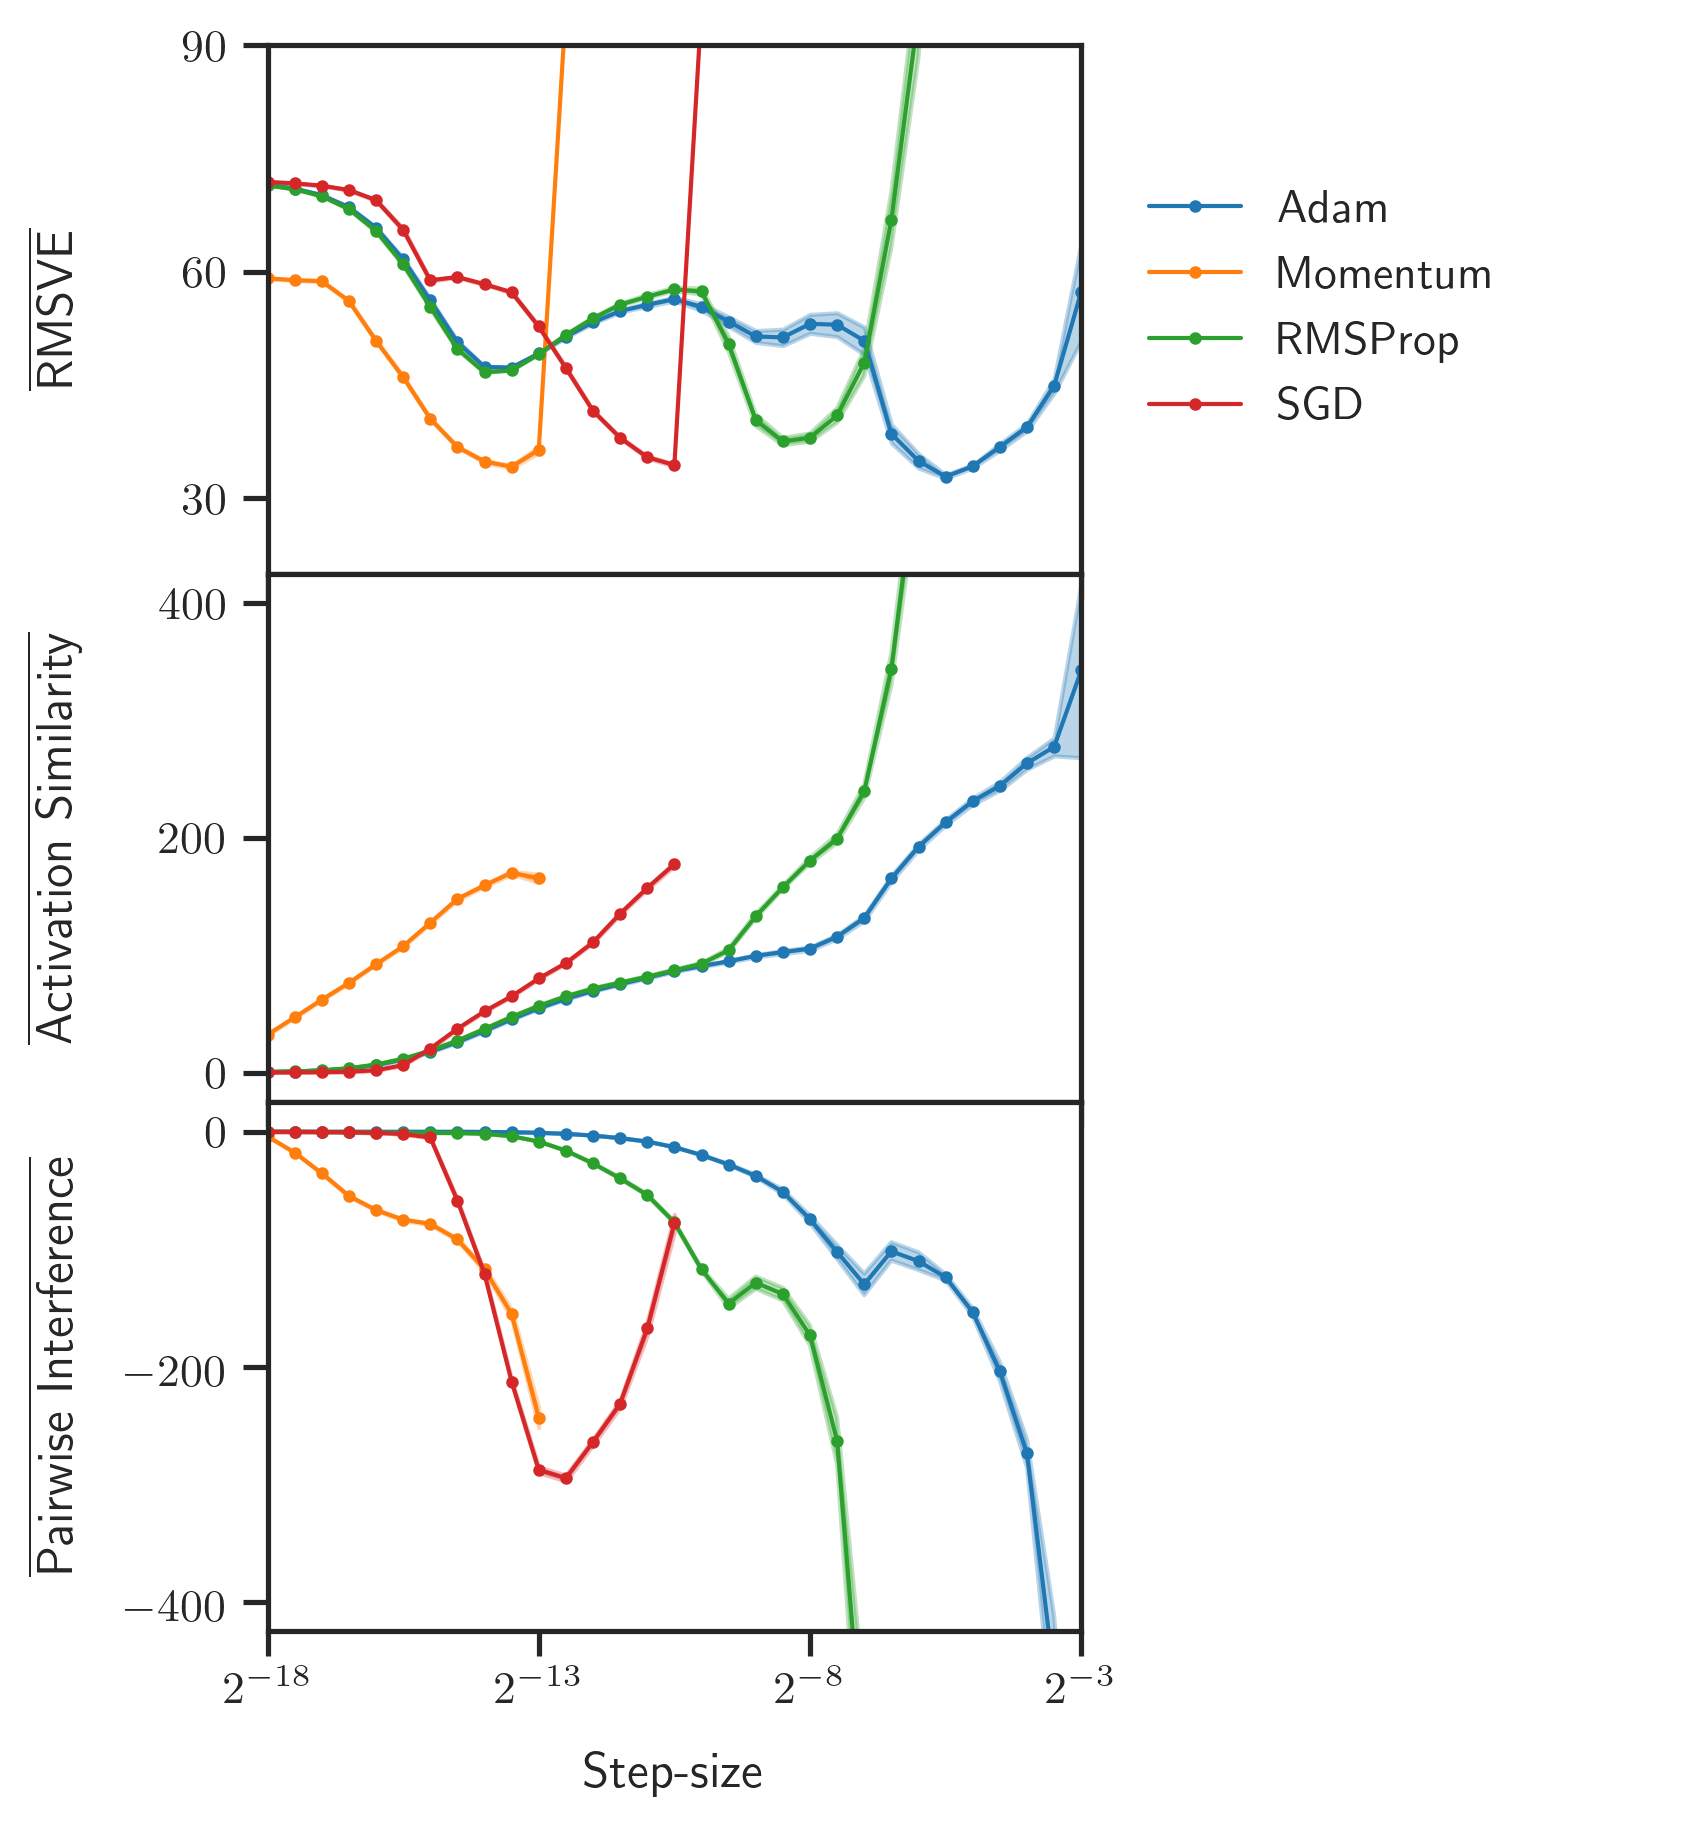

In [27]:
lr_comparison = dict()
for optimizer in set(summary['optimizer'].unique()) - {'constant'}:
    lr_comparison[optimizer] = summary[summary['optimizer'] == optimizer].sort_values('lr')
lr_comparison['momentum'] = lr_comparison['momentum'][lr_comparison['momentum']['momentum'] == 0.9]
lr_comparison['rms'] = lr_comparison['rms'][lr_comparison['rms']['rho'] == 0.999]

colors = sns.color_palette(n_colors=len(lr_comparison.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(3.5, 7))
sort_key = lambda x: x[0]
for i, (optimizer, value) in enumerate(sorted(lr_comparison.items(), key=sort_key)):
    y1 = value['mean_accuracy_mean'].to_numpy()
    y1err = value['mean_accuracy_stderr'].to_numpy()
    y1[np.isnan(y1)] = 95  # plot out of axis values to show divergence
    x = value['lr']
    ax1.plot(
        x,
        y1,
        '-o',
        label=optimizer_nice_names[optimizer],
        markersize=2,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    value = value[value['final_accuracy_mean'].notnull()]
    x = value['lr']
    try:
        y2 = value['mean_activation_similarity_mean']
        y2err = value['mean_activation_similarity_stderr']
        ax2.plot(
            x,
            y2,
            '-o',
            linewidth=1,
            markersize=2,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['mean_pairwise_interference_mean']
        y3err = value['mean_pairwise_interference_stderr']
        ax3.plot(
            x,
            y3,
            '-o',
            linewidth=1,
            markersize=2,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass

ax1.set_xscale('log', basex=2)
ax1.set_ylabel('$\overline{\mbox{RMSVE}}$', labelpad=10)
ax1.set_ylim(20, 90)
ax1.set_yticks([30, 60, 90])
ax2.set_ylabel('$\overline{\mbox{Activation Similarity}}$', labelpad=10)
ax2.set_ylim(- 25, 425)
ax2.set_yticks([0, 200, 400])
ax3.set_ylabel('$\overline{\mbox{Pairwise Interference}}$', labelpad=10)
ax3.set_ylim(- 425, 25)
ax3.set_yticks([- 400, - 200, 0])
ax3.set_xlim(2 ** (-18), 2 ** (-3))
ax3.set_xticks([2 ** (-18), 2 ** (-13), 2 ** (-8), 2 ** (-3)])
ax3.set_xlabel('Step-size', labelpad=10)
fig.align_ylabels((ax1, ax2, ax3))
fig.legend(loc='upper right', bbox_to_anchor=(1.465, 0.8), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('experiment_2_mountain_car_step-size.pdf', bbox_inches='tight')

<a href=#top>Back to Top</a>

### Testing Phase<a name='experiment_2_mountain_car_testing'/>

In [28]:
data = mc_tools.load_data(['experiment_2_mountain_car_test.json'])
summary = mc_tools.get_summary(data)
summary.head(n=len(summary))

approximator  beta_1  beta_2 lambda_  loss        lr  momentum optimizer  \
0  neural_network     NaN     NaN    None    TD  0.000173      0.81  momentum   
1  neural_network     NaN     NaN    None    TD  0.000005      0.99  momentum   
2  neural_network     NaN     NaN    None    TD  0.000043       NaN       rms   
3  neural_network     NaN     NaN    None    TD  0.000086      0.90  momentum   
4  neural_network     0.9   0.999    None    TD  0.022097       NaN      adam   
5  neural_network     NaN     NaN    None    TD  0.000086       NaN       rms   
6        constant     NaN     NaN    None  None       NaN       NaN  constant   
7  neural_network     NaN     NaN    None    TD  0.000043       NaN       rms   
8  neural_network     NaN     NaN    None    TD  0.000691       NaN       sgd   
9  neural_network     NaN     NaN    None    TD  0.003906       NaN       rms   

     rho  target_update  ...  final_activation_similarity_mean  \
0    NaN              1  ...                        225.133837   
1    NaN              1  ...                        228.743262   
2  0.810              1  ...                         98.260367   
3    NaN              1  ...                        211.498690   
4    NaN              1  ...                        247.324786   
5  0.990              1  ...                         70.503551   
6    NaN              1  ...                               NaN   
7  0.900              1  ...                         79.259290   
8    NaN              1  ...                        237.927529   
9  0.999              1  ...                        218.728700   

   final_activation_similarity_stderr  final_pairwise_interference_mean  \
0                            0.924390                       -129.652966   
1                            2.054625                        -12.074143   
2                            0.332731                         -0.596687   
3                            0.784598                        -80.048332   
4                            1.322969                        -84.268171   
5                            0.128104                         -4.884731   
6                                 NaN                               NaN   
7                            0.241527                         -0.362056   
8                            0.825034                        170.773419   
9                            1.029445                         10.317755   

   final_pairwise_interference_stderr  \
0                           10.906515   
1                            1.028174   
2                            0.007764   
3                            4.973199   
4                            5.283983   
5                            0.042999   
6                                 NaN   
7                            0.005479   
8                            8.635742   
9                            3.329046   

                                       accuracy_mean  \
0  [72.32498419189453, 71.96320510864258, 71.5561...   
1  [72.32498419189453, 72.23184194946289, 72.0523...   
2  [72.32498419189453, 72.29574784851074, 72.2673...   
3  [72.32498419189453, 71.99582455444336, 71.6164...   
4  [72.32498419189453, 56.82185952758789, 71.7328...   
5  [72.32498419189453, 72.19728044128418, 72.1265...   
6  [72.3262710571289, 41.34585971832276, 40.53755...   
7  [72.32498419189453, 72.29322332763672, 72.2638...   
8  [72.32498419189453, 72.0426859741211, 71.74491...   
9  [72.32498419189453, 56.168509292602536, 67.738...   

                                     accuracy_stderr  \
0  [0.005613815154144808, 0.00733386855582878, 0....   
1  [0.005613815154144808, 0.005861180989493349, 0...   
2  [0.005613815154144809, 0.0056245424317288364, ...   
3  [0.0056138151541448075, 0.007108732099331188, ...   
4  [0.005613815154144806, 1.5008969200060016, 1.4...   
5  [0.005613815154144811, 0.0057660533311189935, ...   
6  [0.0, 0.11010306435898964, 0.05859944391491927...   
7  [0.005613815154144808, 0.005625622776326

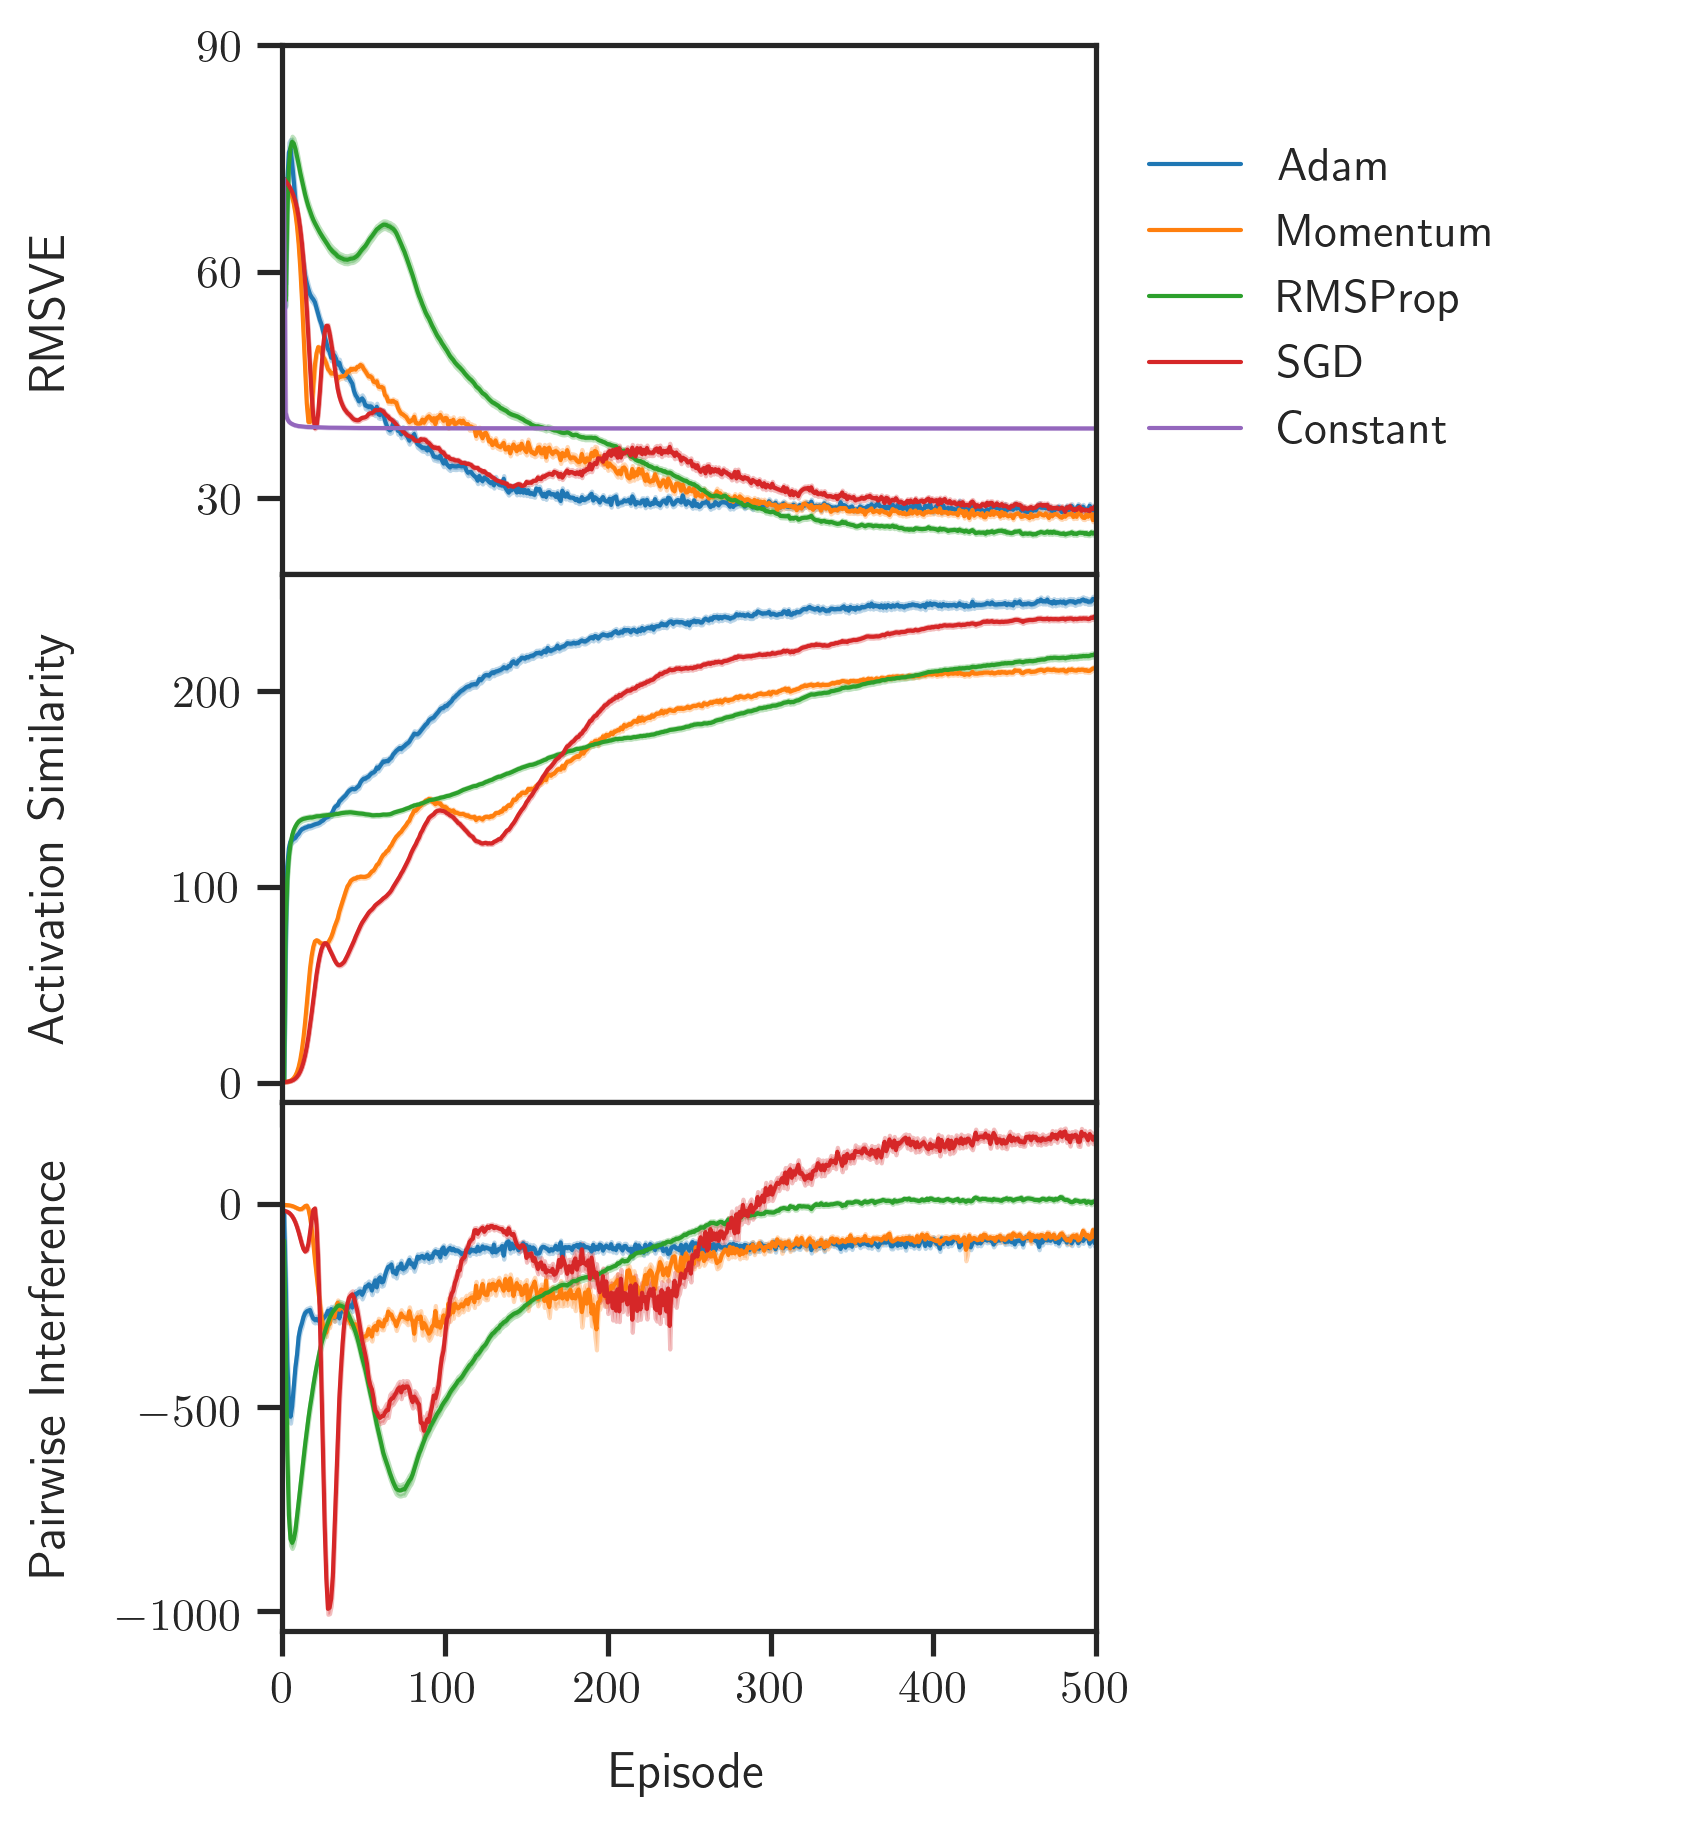

In [29]:
rdf = summary[np.isnan(summary['momentum']) | (summary['momentum'] == 0.9)]
rdf = rdf[np.isnan(rdf['rho']) | (rdf['rho'] == 0.999)]
colors = sns.color_palette(n_colors=len(rdf.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(3.5, 7))
sort_key = lambda x: '~' if x == 'constant' else x
for i, optimizer in enumerate(sorted(rdf['optimizer'].unique(), key=sort_key)):
    value = rdf[rdf['optimizer'] == optimizer].iloc[0].to_dict()
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer_nice_names[optimizer],
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    if optimizer == 'constant':
        continue
    try:
        y2 = value['activation_similarity_mean']
        y2err = value['activation_similarity_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['pairwise_interference_mean']
        y3err = value['pairwise_interference_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_ylabel('RMSVE', labelpad=10)
ax1.set_ylim(20, 90)
ax1.set_yticks([30, 60, 90])
ax2.set_ylabel('Activation Similarity', labelpad=10)
ax2.set_ylim(- 10, 260)
ax2.set_yticks([0, 100, 200])
ax3.set_ylabel('Pairwise Interference', labelpad=10)
ax3.set_ylim(- 1050, 250)
ax3.set_yticks([- 1000, - 500, 0])
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.align_ylabels((ax1, ax2, ax3))
fig.legend(loc='upper right', bbox_to_anchor=(1.465, 0.82), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('experiment_2_mountain_car_accuracies_and_interference.pdf', bbox_inches='tight')

In [30]:
rdf = summary[np.isnan(summary['momentum']) | (summary['momentum'] == 0.9)]
rdf = rdf[np.isnan(rdf['rho']) | (rdf['rho'] == 0.999)]

sort_key = lambda x: '~' if x == 'constant' else x
optimizers = sorted(rdf['optimizer'].unique(), key=sort_key)
optimizers = [optimizer for optimizer in optimizers if optimizer != 'constant']

text = ''
text += '|---------------------------|-----------|---------------|--------------|\n'
text += '|          Metric           | Optimizer |  Mean Value   | Final Value  |\n'
text += '|---------------------------|-----------|---------------|--------------|\n'
for metric in ['activation_similarity', 'pairwise_interference']:
    for i, optimizer in enumerate(optimizers):
        mean_metric_mean = rdf[rdf['optimizer'] == optimizer].iloc[0].to_dict()['mean_{}_mean'.format(metric)]
        mean_metric_stderr = rdf[rdf['optimizer'] == optimizer].iloc[0].to_dict()['mean_{}_stderr'.format(metric)]
        final_metric_mean = rdf[rdf['optimizer'] == optimizer].iloc[0].to_dict()['final_{}_mean'.format(metric)]
        final_metric_stderr = rdf[rdf['optimizer'] == optimizer].iloc[0].to_dict()['final_{}_stderr'.format(metric)]
        text += '| {0:>25} | {1:<9} | {2:>7.2f}+-{3:<4.2f} | {4:>6.2f}+-{5:<4.2f} |\n'.format(
            metric.replace('_', ' ').title() if i == 1 else '',
            optimizer_nice_names[optimizer],
            mean_metric_mean,
            mean_metric_stderr,
            final_metric_mean,
            final_metric_stderr)
    text += '|---------------------------|-----------|---------------|--------------|\n'
with open('experiment_2_mountain_car_metrics.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|---------------------------|-----------|---------------|--------------|
|          Metric           | Optimizer |  Mean Value   | Final Value  |
|---------------------------|-----------|---------------|--------------|
|                           | Adam      |  218.32+-0.90 | 247.32+-1.32 |
|     Activation Similarity | Momentum  |  170.64+-0.40 | 211.50+-0.78 |
|                           | RMSProp   |  179.36+-0.63 | 218.73+-1.03 |
|                           | SGD       |  180.50+-0.45 | 237.93+-0.83 |
|---------------------------|-----------|---------------|--------------|
|                           | Adam      | -124.82+-0.88 | -84.27+-5.28 |
|     Pairwise Interference | Momentum  | -156.11+-1.20 | -80.05+-4.97 |
|                           | RMSProp   | -168.70+-2.80 |  10.32+-3.33 |
|                           | SGD       |  -76.75+-3.02 | 170.77+-8.64 |
|---------------------------|-----------|---------------|--------------|



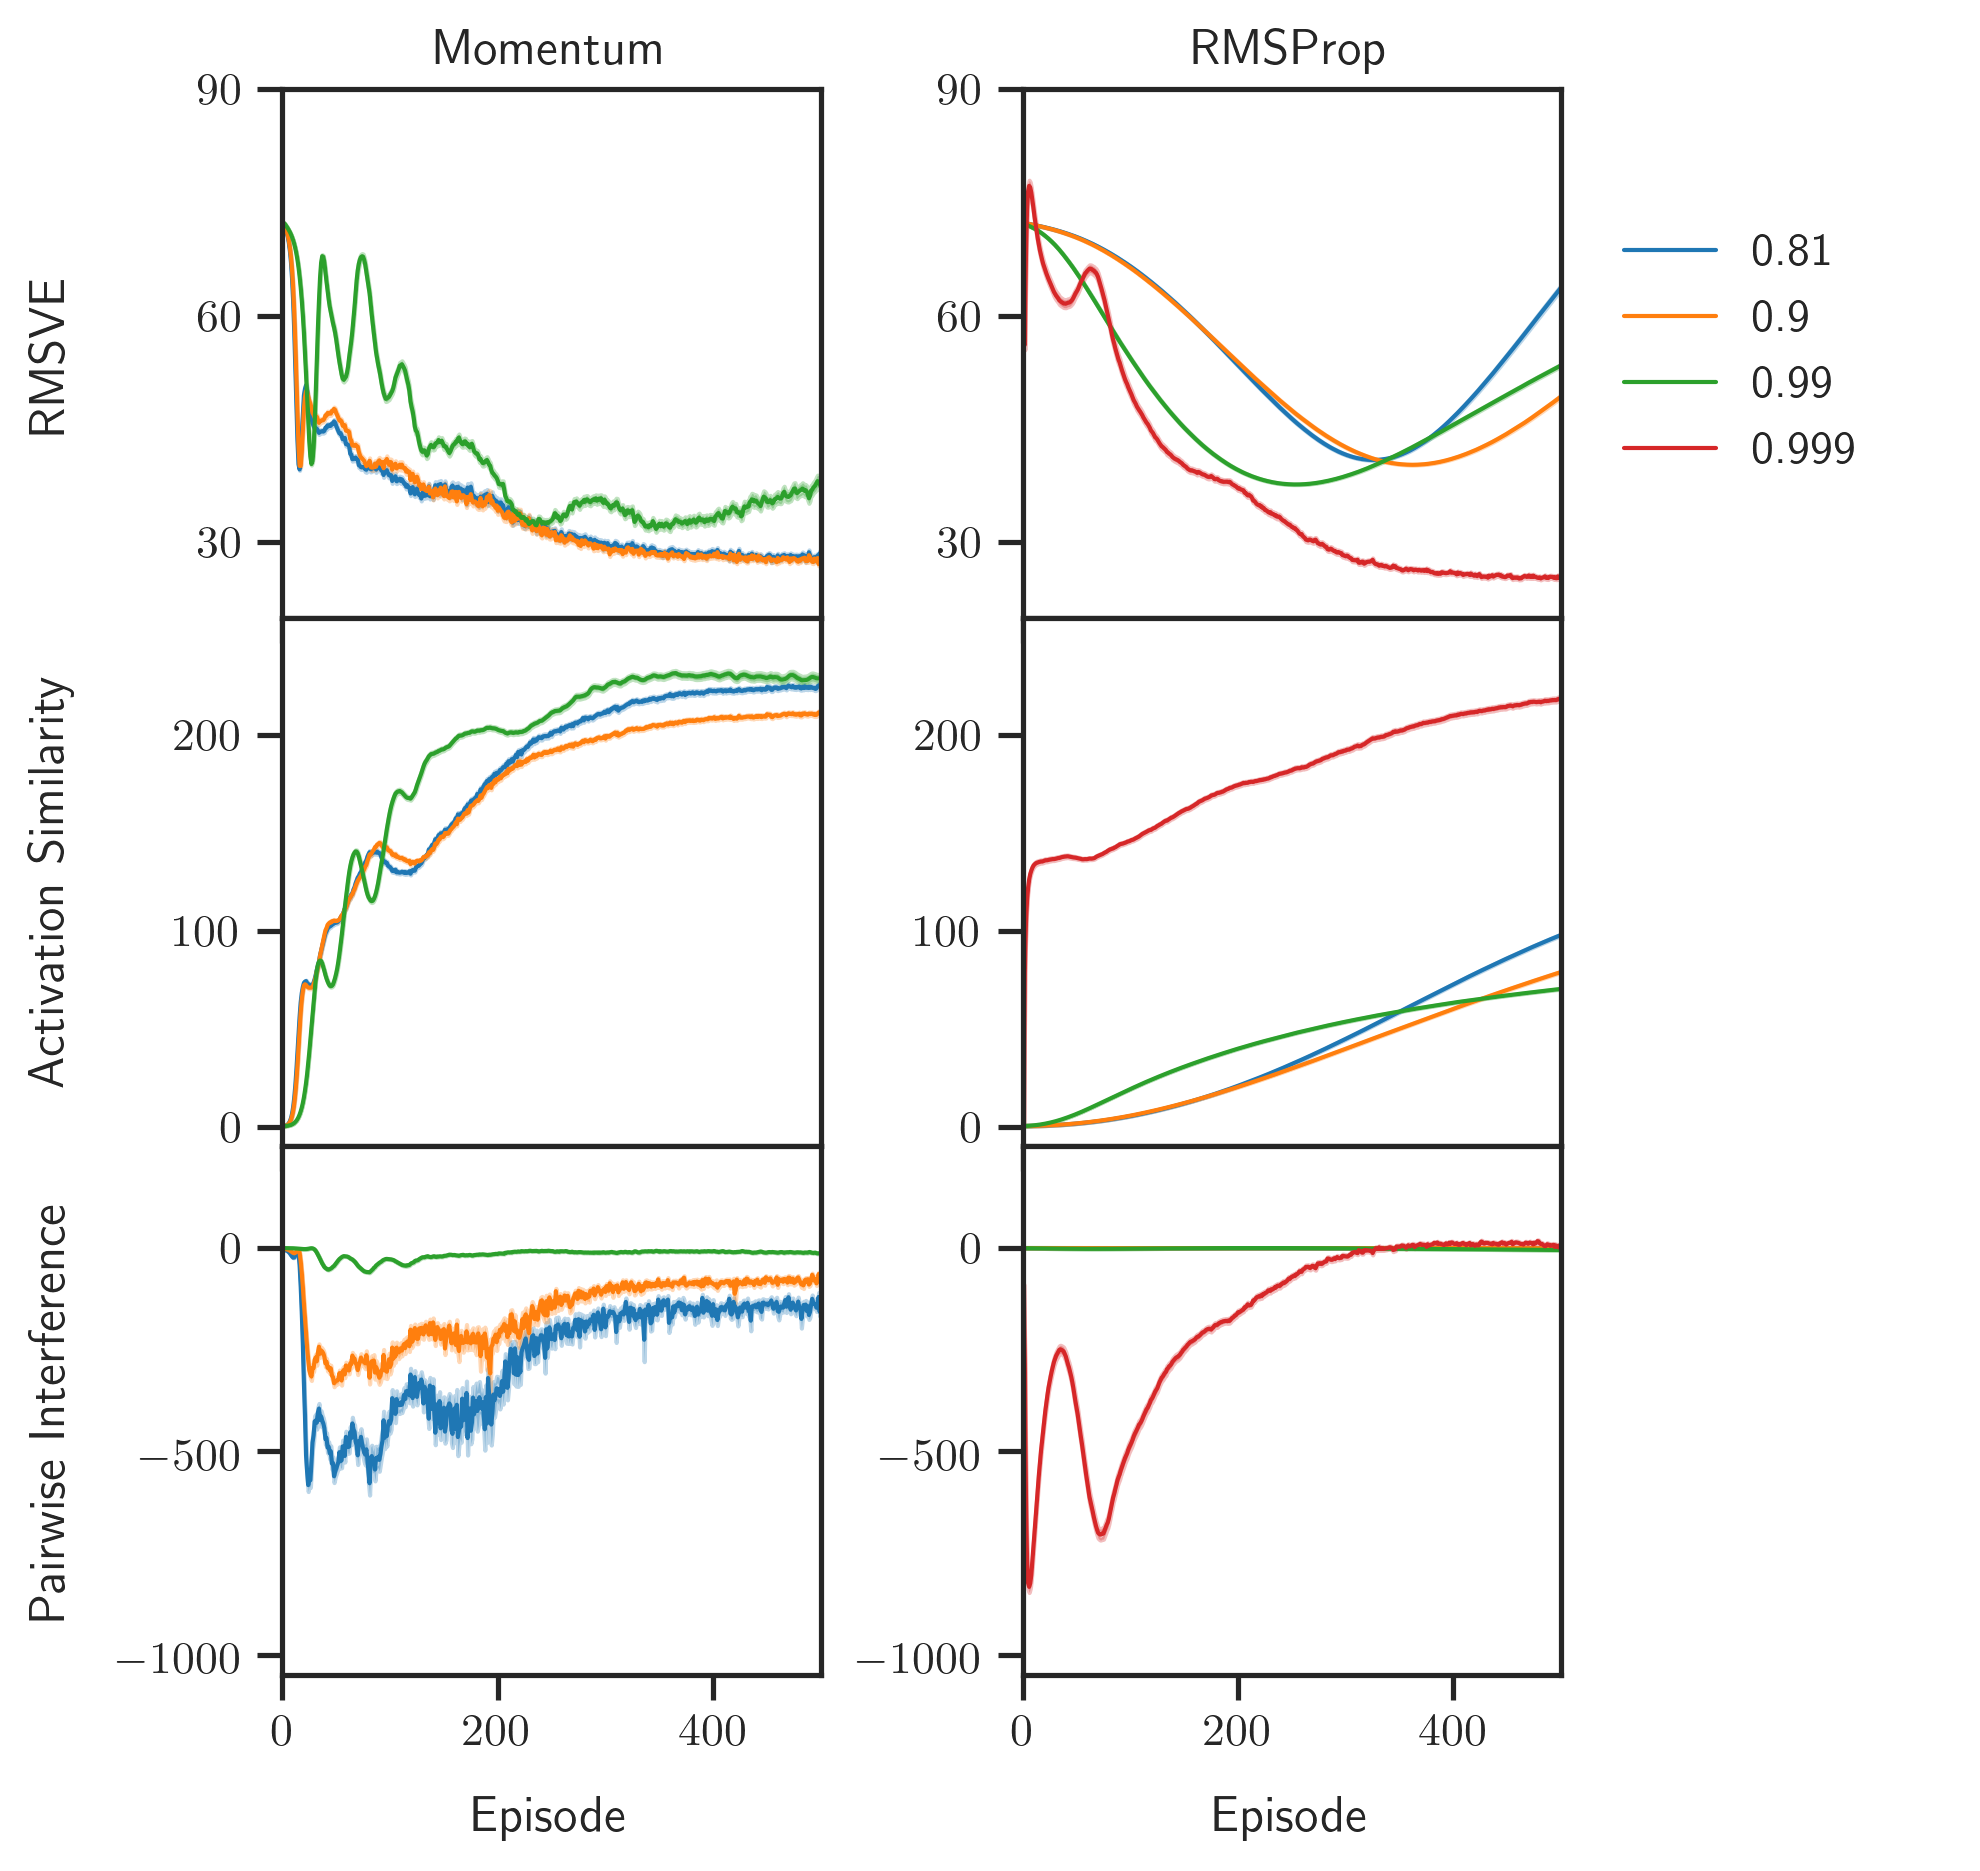

In [31]:
colors = sns.color_palette(n_colors=4)
fig, axmat = plt.subplots(3, 2, sharex=True, dpi=300, figsize=(5.5, 7))
sort_key = lambda x: '~' if x == 'constant' else x
for i, (optimizer, hyperparameter) in enumerate([('momentum', 'momentum'), ('rms', 'rho')]):
    rdf = summary[summary['optimizer'] == optimizer]
    for j, key in enumerate(['accuracy', 'activation_similarity', 'pairwise_interference']):
        hyperparameter_values = sorted(rdf[hyperparameter].unique())
        for k, hyperparameter_value in enumerate(hyperparameter_values):
            value = rdf[rdf[hyperparameter] == hyperparameter_value].iloc[0].to_dict()
            ax = axmat[j, i]
            try:
                y = value['{}_mean'.format(key)]
                yerr = value['{}_stderr'.format(key)]
                x = np.arange(len(y)) + 1
                if (i == 1) and (j == 0):
                    label = hyperparameter_value
                else:
                    label = None
                ax.plot(
                    x,
                    y,
                    label=label,
                    linewidth=1,
                    color=colors[k])
                ax.fill_between(
                    x,
                    y - yerr,
                    y + yerr,
                    alpha=0.3,
                    color=colors[k])
            except KeyError:
                pass
axmat[0, 0].set_title('Momentum')
axmat[0, 1].set_title('RMSProp')
axmat[0, 0].set_ylabel('RMSVE', labelpad=10)
axmat[0, 0].set_ylim(20, 90)
axmat[0, 0].set_yticks([30, 60, 90])
axmat[0, 1].set_ylim(20, 90)
axmat[0, 1].set_yticks([30, 60, 90])
axmat[1, 0].set_ylabel('Activation Similarity', labelpad=10)
axmat[1, 0].set_ylim(- 10, 260)
axmat[1, 0].set_yticks([0, 100, 200])
axmat[1, 1].set_ylim(- 10, 260)
axmat[1, 1].set_yticks([0, 100, 200])
axmat[2, 0].set_ylabel('Pairwise Interference', labelpad=10)
axmat[2, 0].set_ylim(- 1050, 250)
axmat[2, 0].set_yticks([- 1000, - 500, 0])
axmat[2, 1].set_ylim(- 1050, 250)
axmat[2, 1].set_yticks([- 1000, - 500, 0])
for i in range(2):
    axmat[2, i].set_xlim(0, 500)
    axmat[2, i].set_xlabel('Episode', labelpad=10)
fig.align_ylabels(axmat[:, 0])
fig.legend(loc='upper right', bbox_to_anchor=(1.15, 0.8), frameon=False)
fig.subplots_adjust(hspace=0.0, wspace=0.375)
fig.savefig('experiment_2_mountain_car_momentum_and_rms.pdf', bbox_inches='tight')

<a href=#top>Back to Top</a>

## Experiment 2 Acrobot<a name='experiment_2_acrobot'/>

### Validation Phase<a name='experiment_2_acrobot_validation'/>

In [32]:
data = ac_tools.load_data(['experiment_2_acrobot_validation.json'])
summary = ac_tools.get_summary(data)
best = ac_tools.get_best(data, ['optimizer', 'momentum', 'rho'], 'auc', summary=summary)
best.head(n=len(best))

/Users/dylanashley/.miniconda3/envs/catastrophic-forgetting/lib/python3.7/site-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


approximator  beta_1  beta_2 lambda_  loss        lr  momentum optimizer  \
0  neural_network     NaN     NaN    None    TD  0.000043      0.81  momentum   
1  neural_network     NaN     NaN    None    TD  0.000008      0.99  momentum   
2  neural_network     NaN     NaN    None    TD  0.000022      0.90  momentum   
3  neural_network     NaN     NaN    None    TD  0.000011       NaN       rms   
4  neural_network     NaN     NaN    None    TD  0.011049       NaN       rms   
5  neural_network     NaN     NaN    None    TD  0.000011       NaN       rms   
6  neural_network     NaN     NaN    None    TD  0.003906       NaN       rms   
7  neural_network     NaN     NaN    None    TD  0.000173       NaN       sgd   
8  neural_network     0.9   0.999    None    TD  0.003906       NaN      adam   
9        constant     NaN     NaN    None  None       NaN       NaN  constant   

     rho  target_update  ...  final_activation_similarity_mean  \
0    NaN              1  ...                         61.303583   
1    NaN              1  ...                       1494.922294   
2    NaN              1  ...                         80.084045   
3  0.900              1  ...                         19.447761   
4  0.990              1  ...                        268.939984   
5  0.810              1  ...                         19.266596   
6  0.999              1  ...                         48.776394   
7    NaN              1  ...                         69.527701   
8    NaN              1  ...                         73.205827   
9    NaN              1  ...                               NaN   

   final_activation_similarity_stderr  final_pairwise_interference_mean  \
0                            2.159762                       -576.910569   
1                          852.719595                        -50.669022   
2                            2.621246                       -564.438628   
3                            0.217467                         -5.094792   
4                            7.161884                       -449.331154   
5                            0.232855                         -3.980044   
6                            1.041782                        -89.774772   
7                            1.053823                       -488.437014   
8                            1.146769                        -73.305702   
9                                 NaN                               NaN   

   final_pairwise_interference_stderr  \
0                           49.980094   
1                           18.245424   
2                           55.391535   
3                            0.296124   
4                           65.566630   
5                            0.249628   
6                           22.992097   
7                           46.245493   
8                            7.170918   
9                                 NaN   

                                       accuracy_mean  \
0  [94.02470550537109, 90.41444915771484, 86.2919...   
1  [94.02470550537109, 87.43964584350586, 72.5125...   
2  [94.02470550537109, 90.67276580810547, 86.8111...   
3  [94.02470550537109, 93.83140838623046, 93.6478...   
4  [94.02470550537109, 72.54121208190918, 68.0886...   
5  [94.02470550537109, 93.84429321289062, 93.6655...   
6  [94.02470550537109, 72.37077995300292, 64.5776...   
7  [94.02470550537109, 91.26650299072266, 88.3540...   
8  [94.02470550537109, 59.313991928100585, 51.585...   
9  [94.02545166015625, 51.69423988342285, 51.2184...   

                                     accuracy_stderr  \
0  [0.08107295674313864, 0.13633862318122617, 0.2...   
1  [0.08107295674313864, 0.2653010316052124, 0.59...   
2  [0.08107295674313864, 0.1325565495021037, 0.22...   
3  [0.08107295674313864, 0.08085096708894353, 0.0...   
4  [0.08107295674313864, 1.9554418864717937, 1.02...   
5  [0.08107295674313864, 0.08092318062780694, 0.0...   
6  [0.08107295674313864, 3.2997361716310336, 2.55...   
7  [0.08107295674313866, 0.1153163444251731

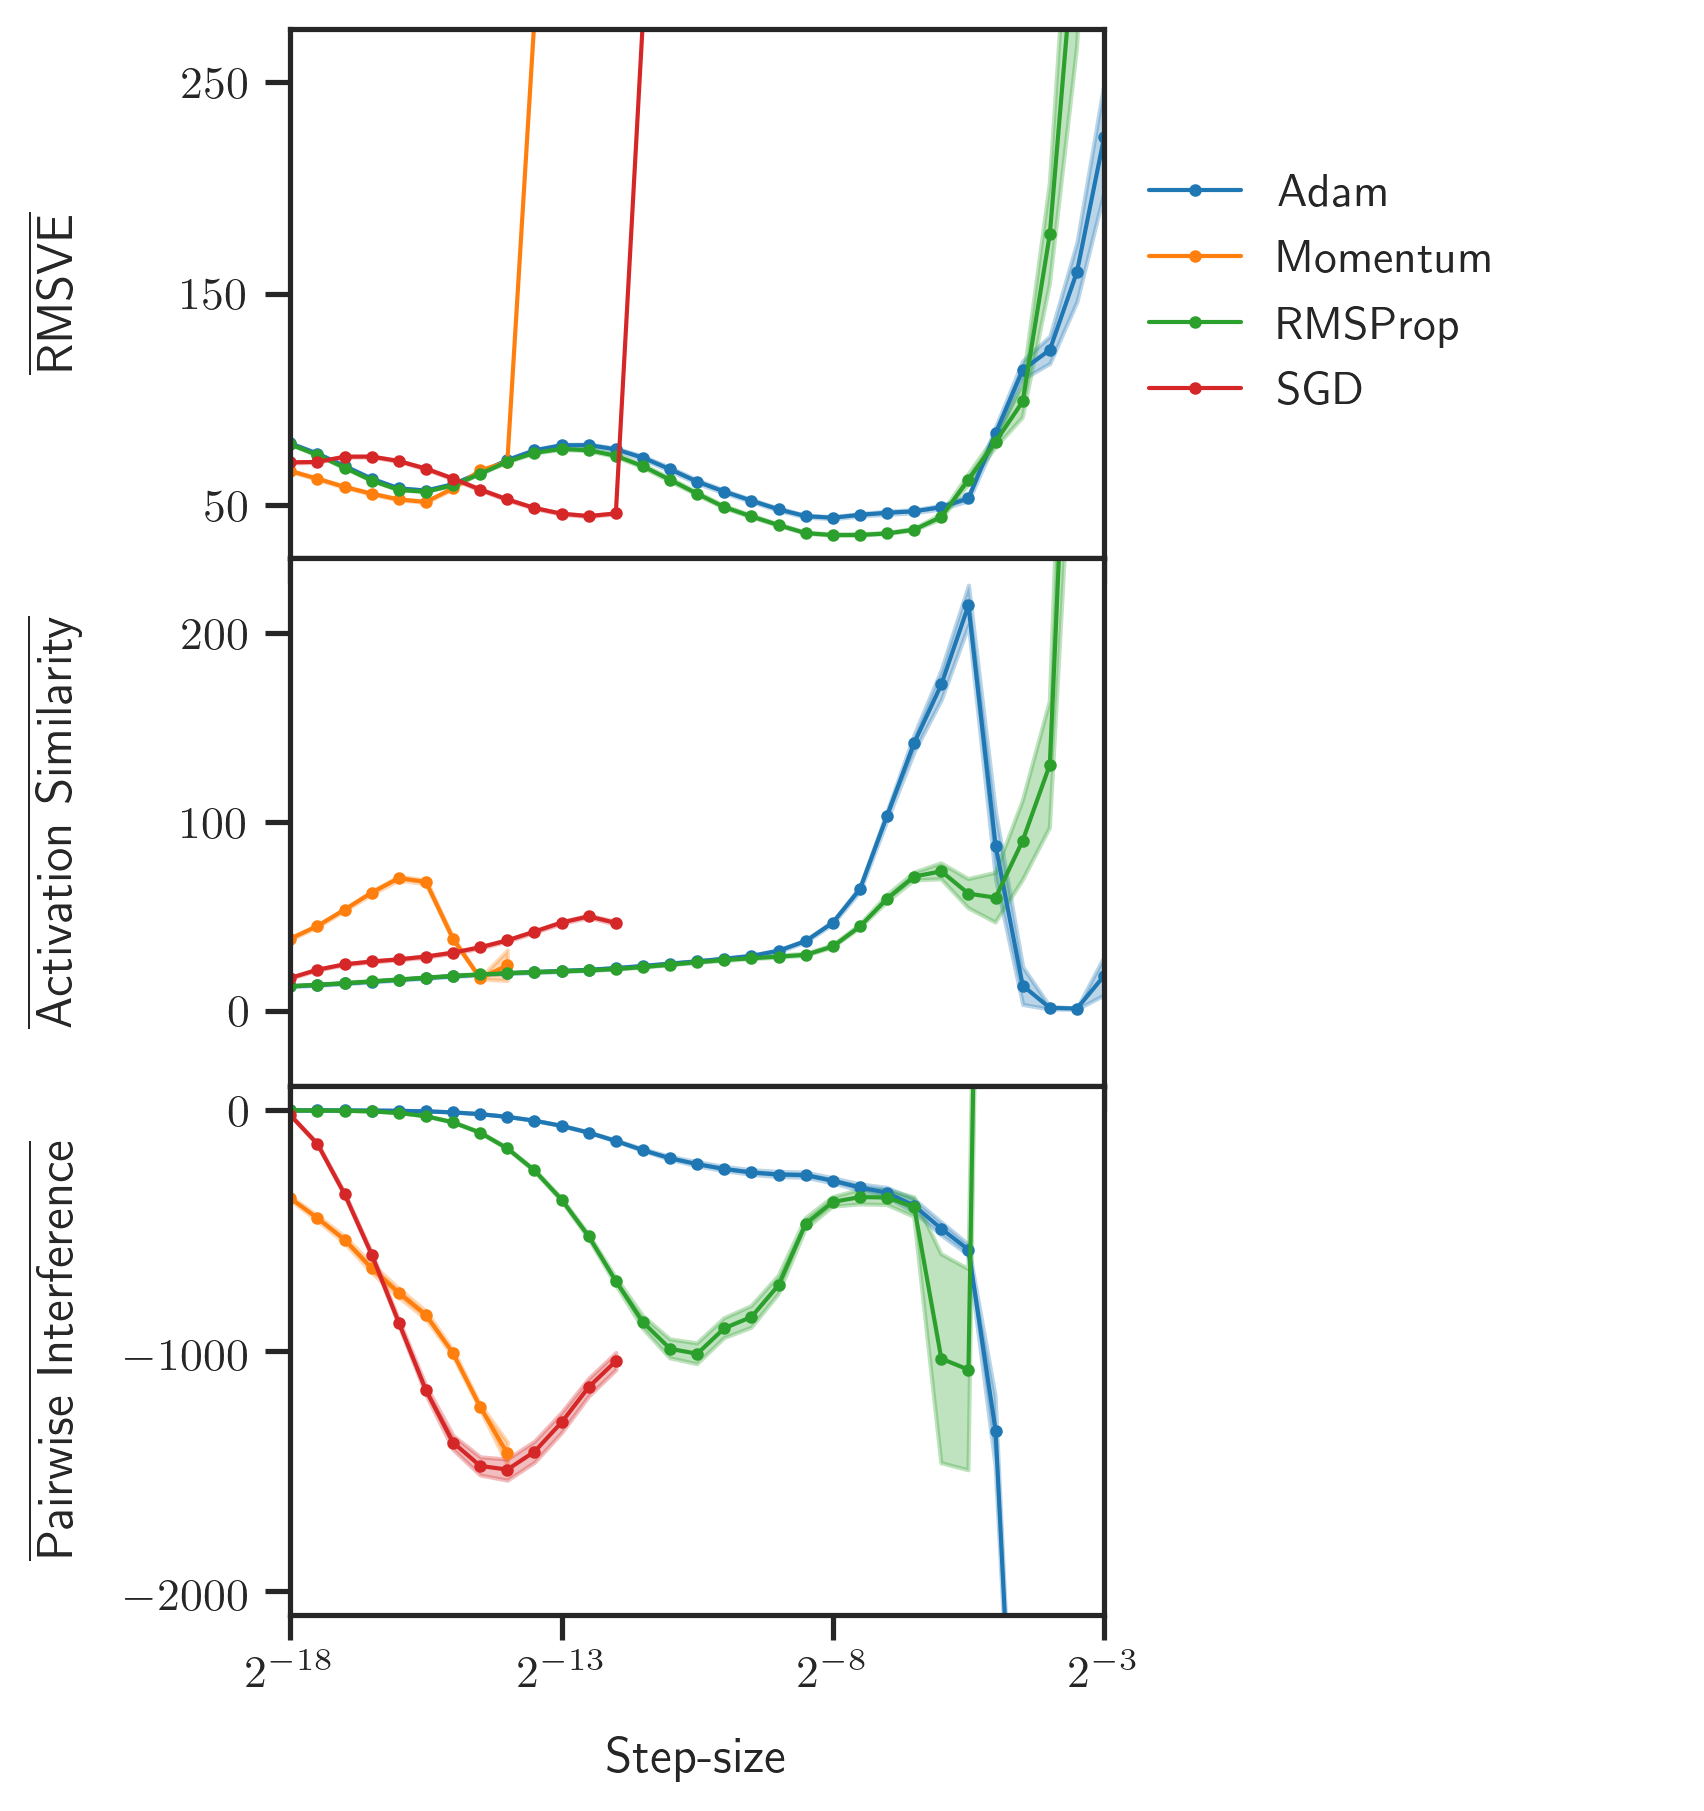

In [33]:
lr_comparison = dict()
for optimizer in set(summary['optimizer'].unique()) - {'constant'}:
    lr_comparison[optimizer] = summary[summary['optimizer'] == optimizer].sort_values('lr')
lr_comparison['momentum'] = lr_comparison['momentum'][lr_comparison['momentum']['momentum'] == 0.9]
lr_comparison['rms'] = lr_comparison['rms'][lr_comparison['rms']['rho'] == 0.999]

colors = sns.color_palette(n_colors=len(lr_comparison.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(3.5, 7))
sort_key = lambda x: x[0]
for i, (optimizer, value) in enumerate(sorted(lr_comparison.items(), key=sort_key)):
    y1 = value['mean_accuracy_mean'].to_numpy()
    y1err = value['mean_accuracy_stderr'].to_numpy()
    y1[np.isnan(y1)] = 280  # plot out of axis values to show divergence
    x = value['lr']
    ax1.plot(
        x,
        y1,
        '-o',
        label=optimizer_nice_names[optimizer],
        markersize=2,
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    value = value[value['final_accuracy_mean'].notnull()]
    x = value['lr']
    try:
        y2 = value['mean_activation_similarity_mean']
        y2err = value['mean_activation_similarity_stderr']
        ax2.plot(
            x,
            y2,
            '-o',
            linewidth=1,
            markersize=2,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['mean_pairwise_interference_mean'].to_numpy()
        y3err = value['mean_pairwise_interference_stderr'].to_numpy()
        y3err[(y3 < - 2100) | (y3 > 100)] = 0  # stop standard error creeping in from out of axis values
        ax3.plot(
            x,
            y3,
            '-o',
            linewidth=1,
            markersize=2,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass

ax1.set_xscale('log', basex=2)
ax1.set_ylabel('$\overline{\mbox{RMSVE}}$', labelpad=10)
ax1.set_ylim(25, 275)
ax1.set_yticks([50, 150, 250])
ax2.set_ylabel('$\overline{\mbox{Activation Similarity}}$', labelpad=10)
ax2.set_ylim(- 40, 240)
ax2.set_yticks([0, 100, 200])
ax3.set_ylabel('$\overline{\mbox{Pairwise Interference}}$', labelpad=10)
ax3.set_ylim(- 2100, 100)
ax3.set_yticks([- 2000, - 1000, 0])
ax3.set_xlim(2 ** (-18), 2 ** (-3))
ax3.set_xticks([2 ** (-18), 2 ** (-13), 2 ** (-8), 2 ** (-3)])
ax3.set_xlabel('Step-size', labelpad=10)
fig.align_ylabels((ax1, ax2, ax3))
fig.legend(loc='upper right', bbox_to_anchor=(1.465, 0.8), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('experiment_2_acrobot_step-size.pdf', bbox_inches='tight')

<a href=#top>Back to Top</a>

### Testing Phase<a name='experiment_2_acrobot_testing'/>

In [34]:
data = ac_tools.load_data(['experiment_2_acrobot_test.json'])
summary = ac_tools.get_summary(data)
summary.head(n=len(summary))

approximator  beta_1  beta_2 lambda_  loss        lr  momentum optimizer  \
0  neural_network     NaN     NaN    None    TD  0.003906       NaN       rms   
1  neural_network     NaN     NaN    None    TD  0.000043      0.81  momentum   
2  neural_network     NaN     NaN    None    TD  0.000008      0.99  momentum   
3  neural_network     NaN     NaN    None    TD  0.000011       NaN       rms   
4  neural_network     NaN     NaN    None    TD  0.000022      0.90  momentum   
5  neural_network     0.9   0.999    None    TD  0.003906       NaN      adam   
6  neural_network     NaN     NaN    None    TD  0.011049       NaN       rms   
7        constant     NaN     NaN    None  None       NaN       NaN  constant   
8  neural_network     NaN     NaN    None    TD  0.000011       NaN       rms   
9  neural_network     NaN     NaN    None    TD  0.000173       NaN       sgd   

     rho  target_update  ...  final_activation_similarity_mean  \
0  0.999              1  ...                         49.541587   
1    NaN              1  ...                         62.746288   
2    NaN              1  ...                               NaN   
3  0.810              1  ...                         19.051201   
4    NaN              1  ...                         81.063698   
5    NaN              1  ...                         72.685841   
6  0.990              1  ...                        270.810253   
7    NaN              1  ...                               NaN   
8  0.900              1  ...                         19.265956   
9    NaN              1  ...                         69.669580   

   final_activation_similarity_stderr  final_pairwise_interference_mean  \
0                            0.377192                        -74.130278   
1                            0.699439                       -556.064576   
2                                 NaN                               NaN   
3                            0.086124                         -3.864508   
4                            0.843766                       -562.918617   
5                            0.409743                        -64.523084   
6                            2.690929                       -489.588835   
7                                 NaN                               NaN   
8                            0.081245                         -5.029163   
9                            0.364410                       -463.383267   

   final_pairwise_interference_stderr  \
0                           12.390563   
1                           16.146047   
2                                 NaN   
3                            0.061059   
4                           17.960129   
5                            2.554622   
6                           26.431687   
7                                 NaN   
8                            0.073645   
9                           16.354102   

                                       accuracy_mean  \
0  [94.052863571167, 71.43526525878906, 63.944504...   
1  [94.0528635559082, 90.44136094665528, 86.38528...   
2  [94.0528635559082, 87.4134736175537, 72.832914...   
3  [94.05286354064941, 93.87274308776855, 93.6974...   
4  [94.0528635559082, 90.70103581237792, 86.90130...   
5  [94.05286354064941, 59.19219694519043, 51.6490...   
6  [94.0528635559082, 72.41114080810547, 67.66939...   
7  [94.02545166015625, 51.83429527282715, 51.4432...   
8  [94.05286358642579, 93.8598923034668, 93.67965...   
9  [94.052863571167, 91.29808334350587, 88.427264...   

                                     accuracy_stderr  \
0  [0.026619472942199525, 1.1459835575489012, 0.8...   
1  [0.026619472080905288, 0.04881689215685846, 0....   
2  [0.02661947143910389, 0.09935782989376166, 0.2...   
3  [0.026619472494265998, 0.026548500729003877, 0...   
4  [0.026619471941510268, 0.046804741550624765, 0...   
5  [0.02661947213426349, 0.23150324785738804, 0.1...   
6  [0.02661947243135646, 0.5877410617560185, 0.36...   
7  [0.0, 0.1348646626168815, 0.088768946062

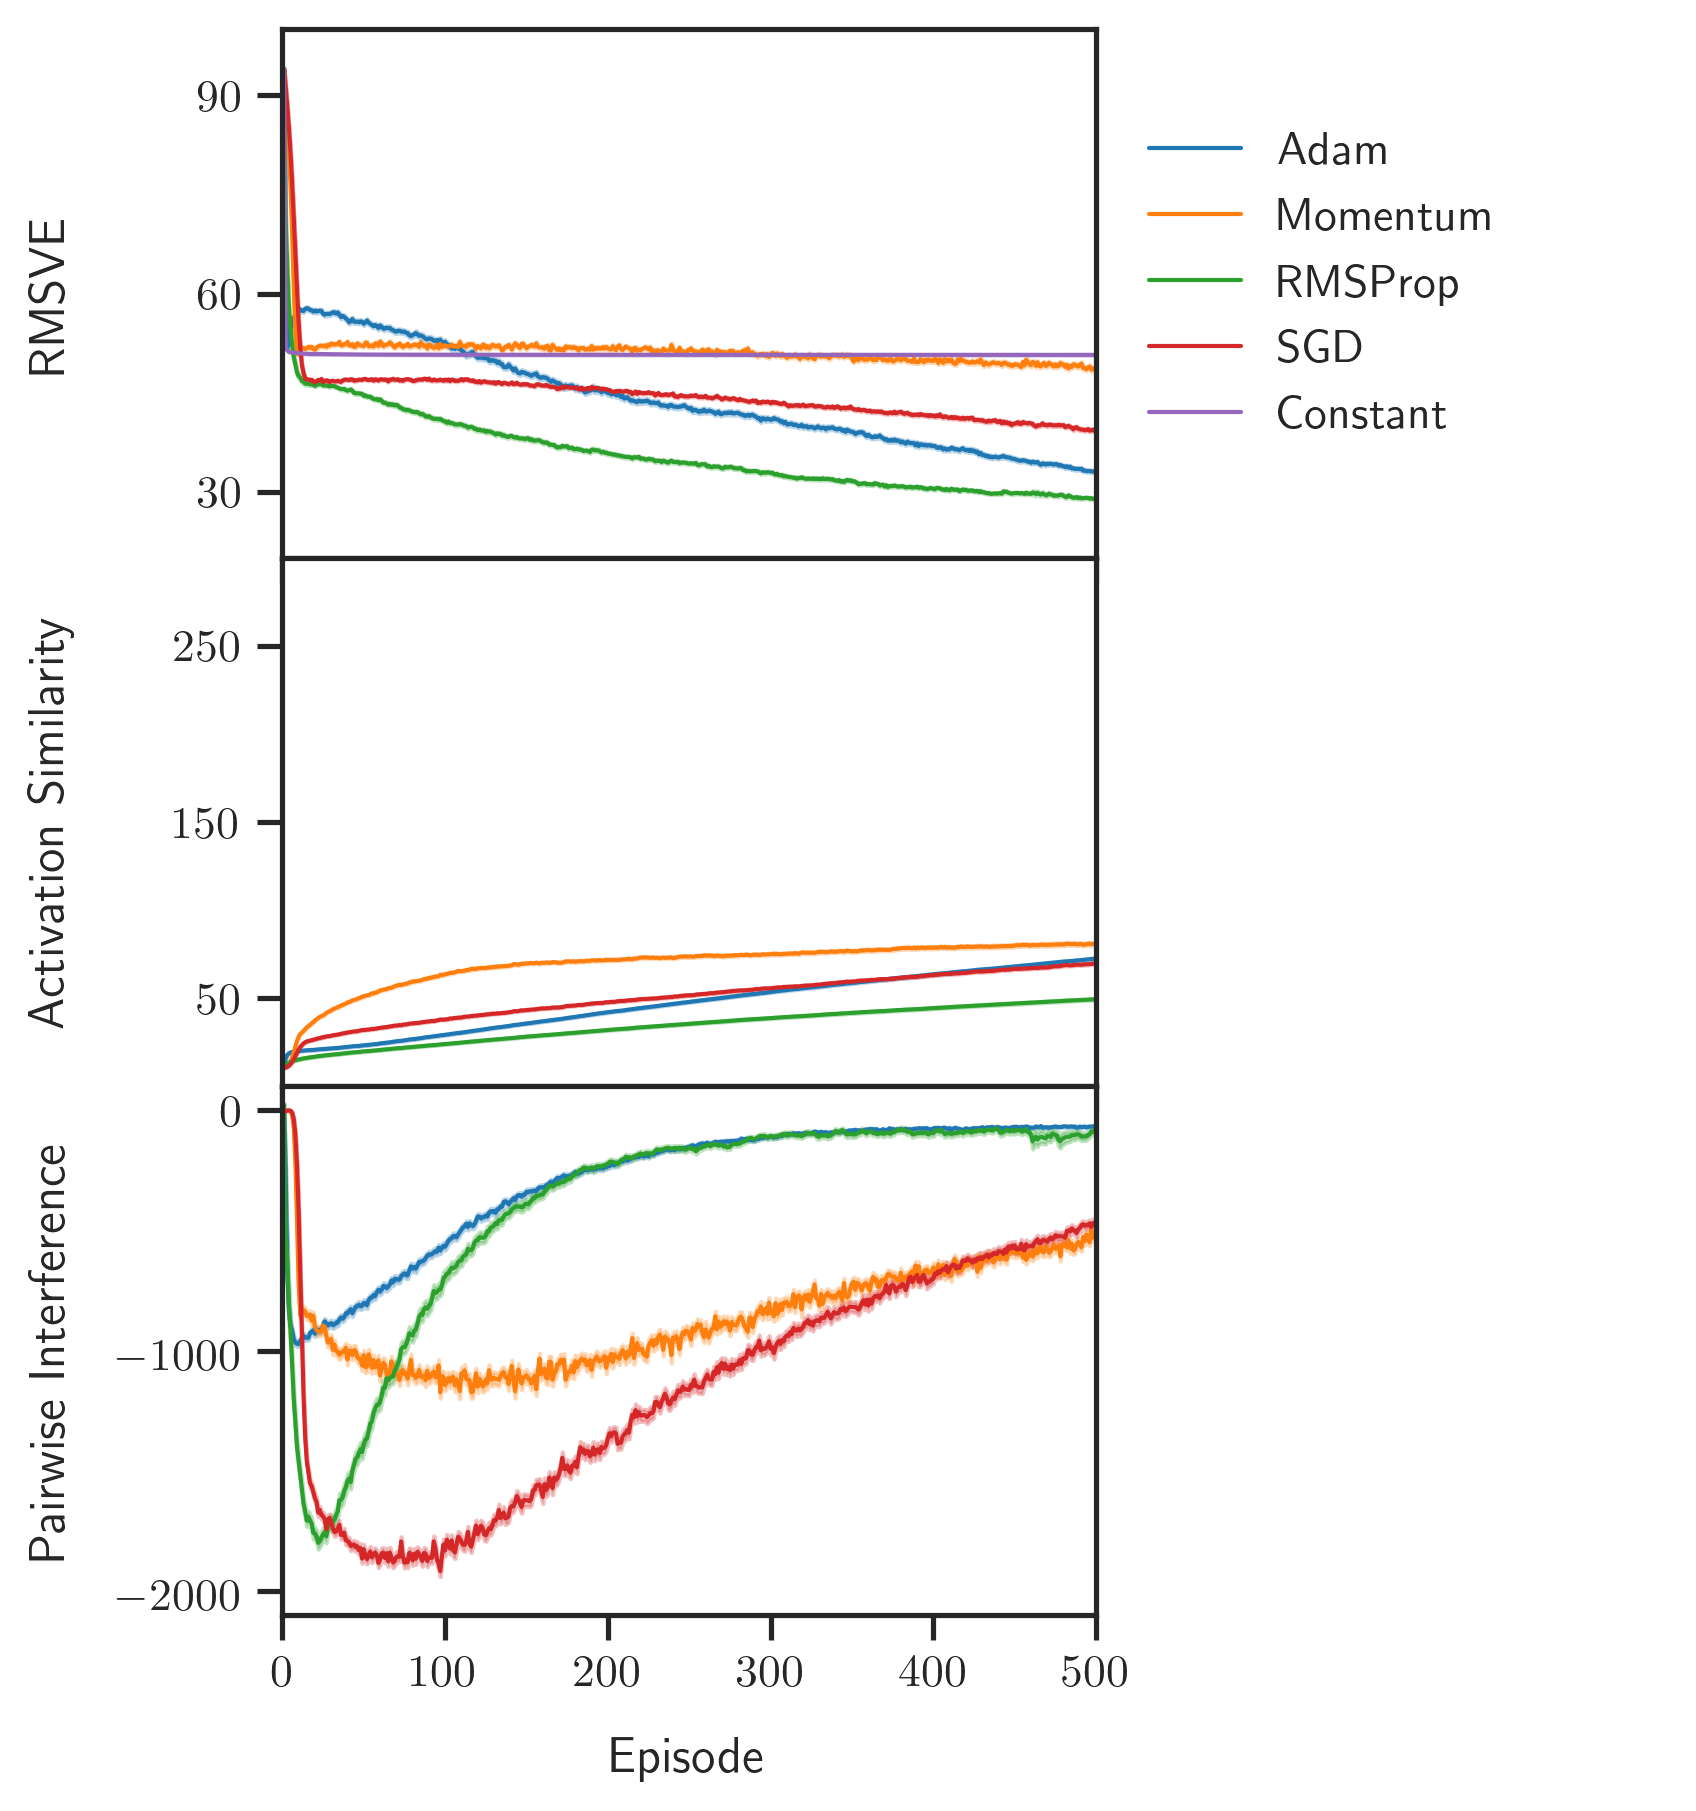

In [35]:
rdf = summary[np.isnan(summary['momentum']) | (summary['momentum'] == 0.9)]
rdf = rdf[np.isnan(rdf['rho']) | (rdf['rho'] == 0.999)]
colors = sns.color_palette(n_colors=len(rdf.keys()))
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, dpi=300, figsize=(3.5, 7))
sort_key = lambda x: '~' if x == 'constant' else x
for i, optimizer in enumerate(sorted(rdf['optimizer'].unique(), key=sort_key)):
    value = rdf[rdf['optimizer'] == optimizer].iloc[0].to_dict()
    y1 = value['accuracy_mean']
    y1err = value['accuracy_stderr']
    x = np.arange(len(y1)) + 1
    ax1.plot(
        x,
        y1,
        label=optimizer_nice_names[optimizer],
        linewidth=1,
        color=colors[i])
    ax1.fill_between(
        x,
        y1 - y1err,
        y1 + y1err,
        alpha=0.3,
        color=colors[i])
    if optimizer == 'constant':
        continue
    try:
        y2 = value['activation_similarity_mean']
        y2err = value['activation_similarity_stderr']
        ax2.plot(
            x,
            y2,
            linewidth=1,
            color=colors[i])
        ax2.fill_between(
            x,
            y2 - y2err,
            y2 + y2err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
    try:
        y3 = value['pairwise_interference_mean']
        y3err = value['pairwise_interference_stderr']
        ax3.plot(
            x,
            y3,
            linewidth=1,
            color=colors[i])
        ax3.fill_between(
            x,
            y3 - y3err,
            y3 + y3err,
            alpha=0.3,
            color=colors[i])
    except KeyError:
        pass
ax1.set_ylabel('RMSVE', labelpad=10)
ax1.set_ylim(20, 100)
ax1.set_yticks([30, 60, 90])
ax2.set_ylabel('Activation Similarity', labelpad=10)
ax2.set_ylim(0, 300)
ax2.set_yticks([50, 150, 250])
ax3.set_ylabel('Pairwise Interference', labelpad=10)
ax3.set_ylim(- 2100, 100)
ax3.set_yticks([- 2000, - 1000, 0])
ax3.set_xlim(0, 500)
ax3.set_xlabel('Episode', labelpad=10)
fig.align_ylabels((ax1, ax2, ax3))
fig.legend(loc='upper right', bbox_to_anchor=(1.465, 0.82), frameon=False)
fig.subplots_adjust(hspace=0.0)
fig.savefig('experiment_2_acrobot_accuracies_and_interference.pdf', bbox_inches='tight')

In [36]:
rdf = summary[np.isnan(summary['momentum']) | (summary['momentum'] == 0.9)]
rdf = rdf[np.isnan(rdf['rho']) | (rdf['rho'] == 0.999)]

sort_key = lambda x: '~' if x == 'constant' else x
optimizers = sorted(rdf['optimizer'].unique(), key=sort_key)
optimizers = [optimizer for optimizer in optimizers if optimizer != 'constant']

text = ''
text += '|---------------------------|-----------|-----------------|----------------|\n'
text += '|          Metric           | Optimizer |   Mean Value    |  Final Value   |\n'
text += '|---------------------------|-----------|-----------------|----------------|\n'
for metric in ['activation_similarity', 'pairwise_interference']:
    for i, optimizer in enumerate(optimizers):
        mean_metric_mean = rdf[rdf['optimizer'] == optimizer].iloc[0].to_dict()['mean_{}_mean'.format(metric)]
        mean_metric_stderr = rdf[rdf['optimizer'] == optimizer].iloc[0].to_dict()['mean_{}_stderr'.format(metric)]
        final_metric_mean = rdf[rdf['optimizer'] == optimizer].iloc[0].to_dict()['final_{}_mean'.format(metric)]
        final_metric_stderr = rdf[rdf['optimizer'] == optimizer].iloc[0].to_dict()['final_{}_stderr'.format(metric)]
        text += '| {0:>25} | {1:<9} | {2:>8.2f}+-{3:<5.2f} | {4:>7.2f}+-{5:<5.2f} |\n'.format(
            metric.replace('_', ' ').title() if i == 1 else '',
            optimizer_nice_names[optimizer],
            mean_metric_mean,
            mean_metric_stderr,
            final_metric_mean,
            final_metric_stderr)
    text += '|---------------------------|-----------|-----------------|----------------|\n'
with open('experiment_2_acrobot_metrics.txt', 'w') as outfile:
    print(text, file=outfile)
print(text)

|---------------------------|-----------|-----------------|----------------|
|          Metric           | Optimizer |   Mean Value    |  Final Value   |
|---------------------------|-----------|-----------------|----------------|
|                           | Adam      |    46.88+-0.24  |   72.69+-0.41  |
|     Activation Similarity | Momentum  |    69.44+-0.32  |   81.06+-0.84  |
|                           | RMSProp   |    34.42+-0.23  |   49.54+-0.38  |
|                           | SGD       |    50.33+-0.20  |   69.67+-0.36  |
|---------------------------|-----------|-----------------|----------------|
|                           | Adam      |  -287.47+-4.27  |  -64.52+-2.55  |
|     Pairwise Interference | Momentum  |  -861.73+-6.41  | -562.92+-17.96 |
|                           | RMSProp   |  -398.41+-8.07  |  -74.13+-12.39 |
|                           | SGD       | -1150.31+-12.37 | -463.38+-16.35 |
|---------------------------|-----------|-----------------|----------------|

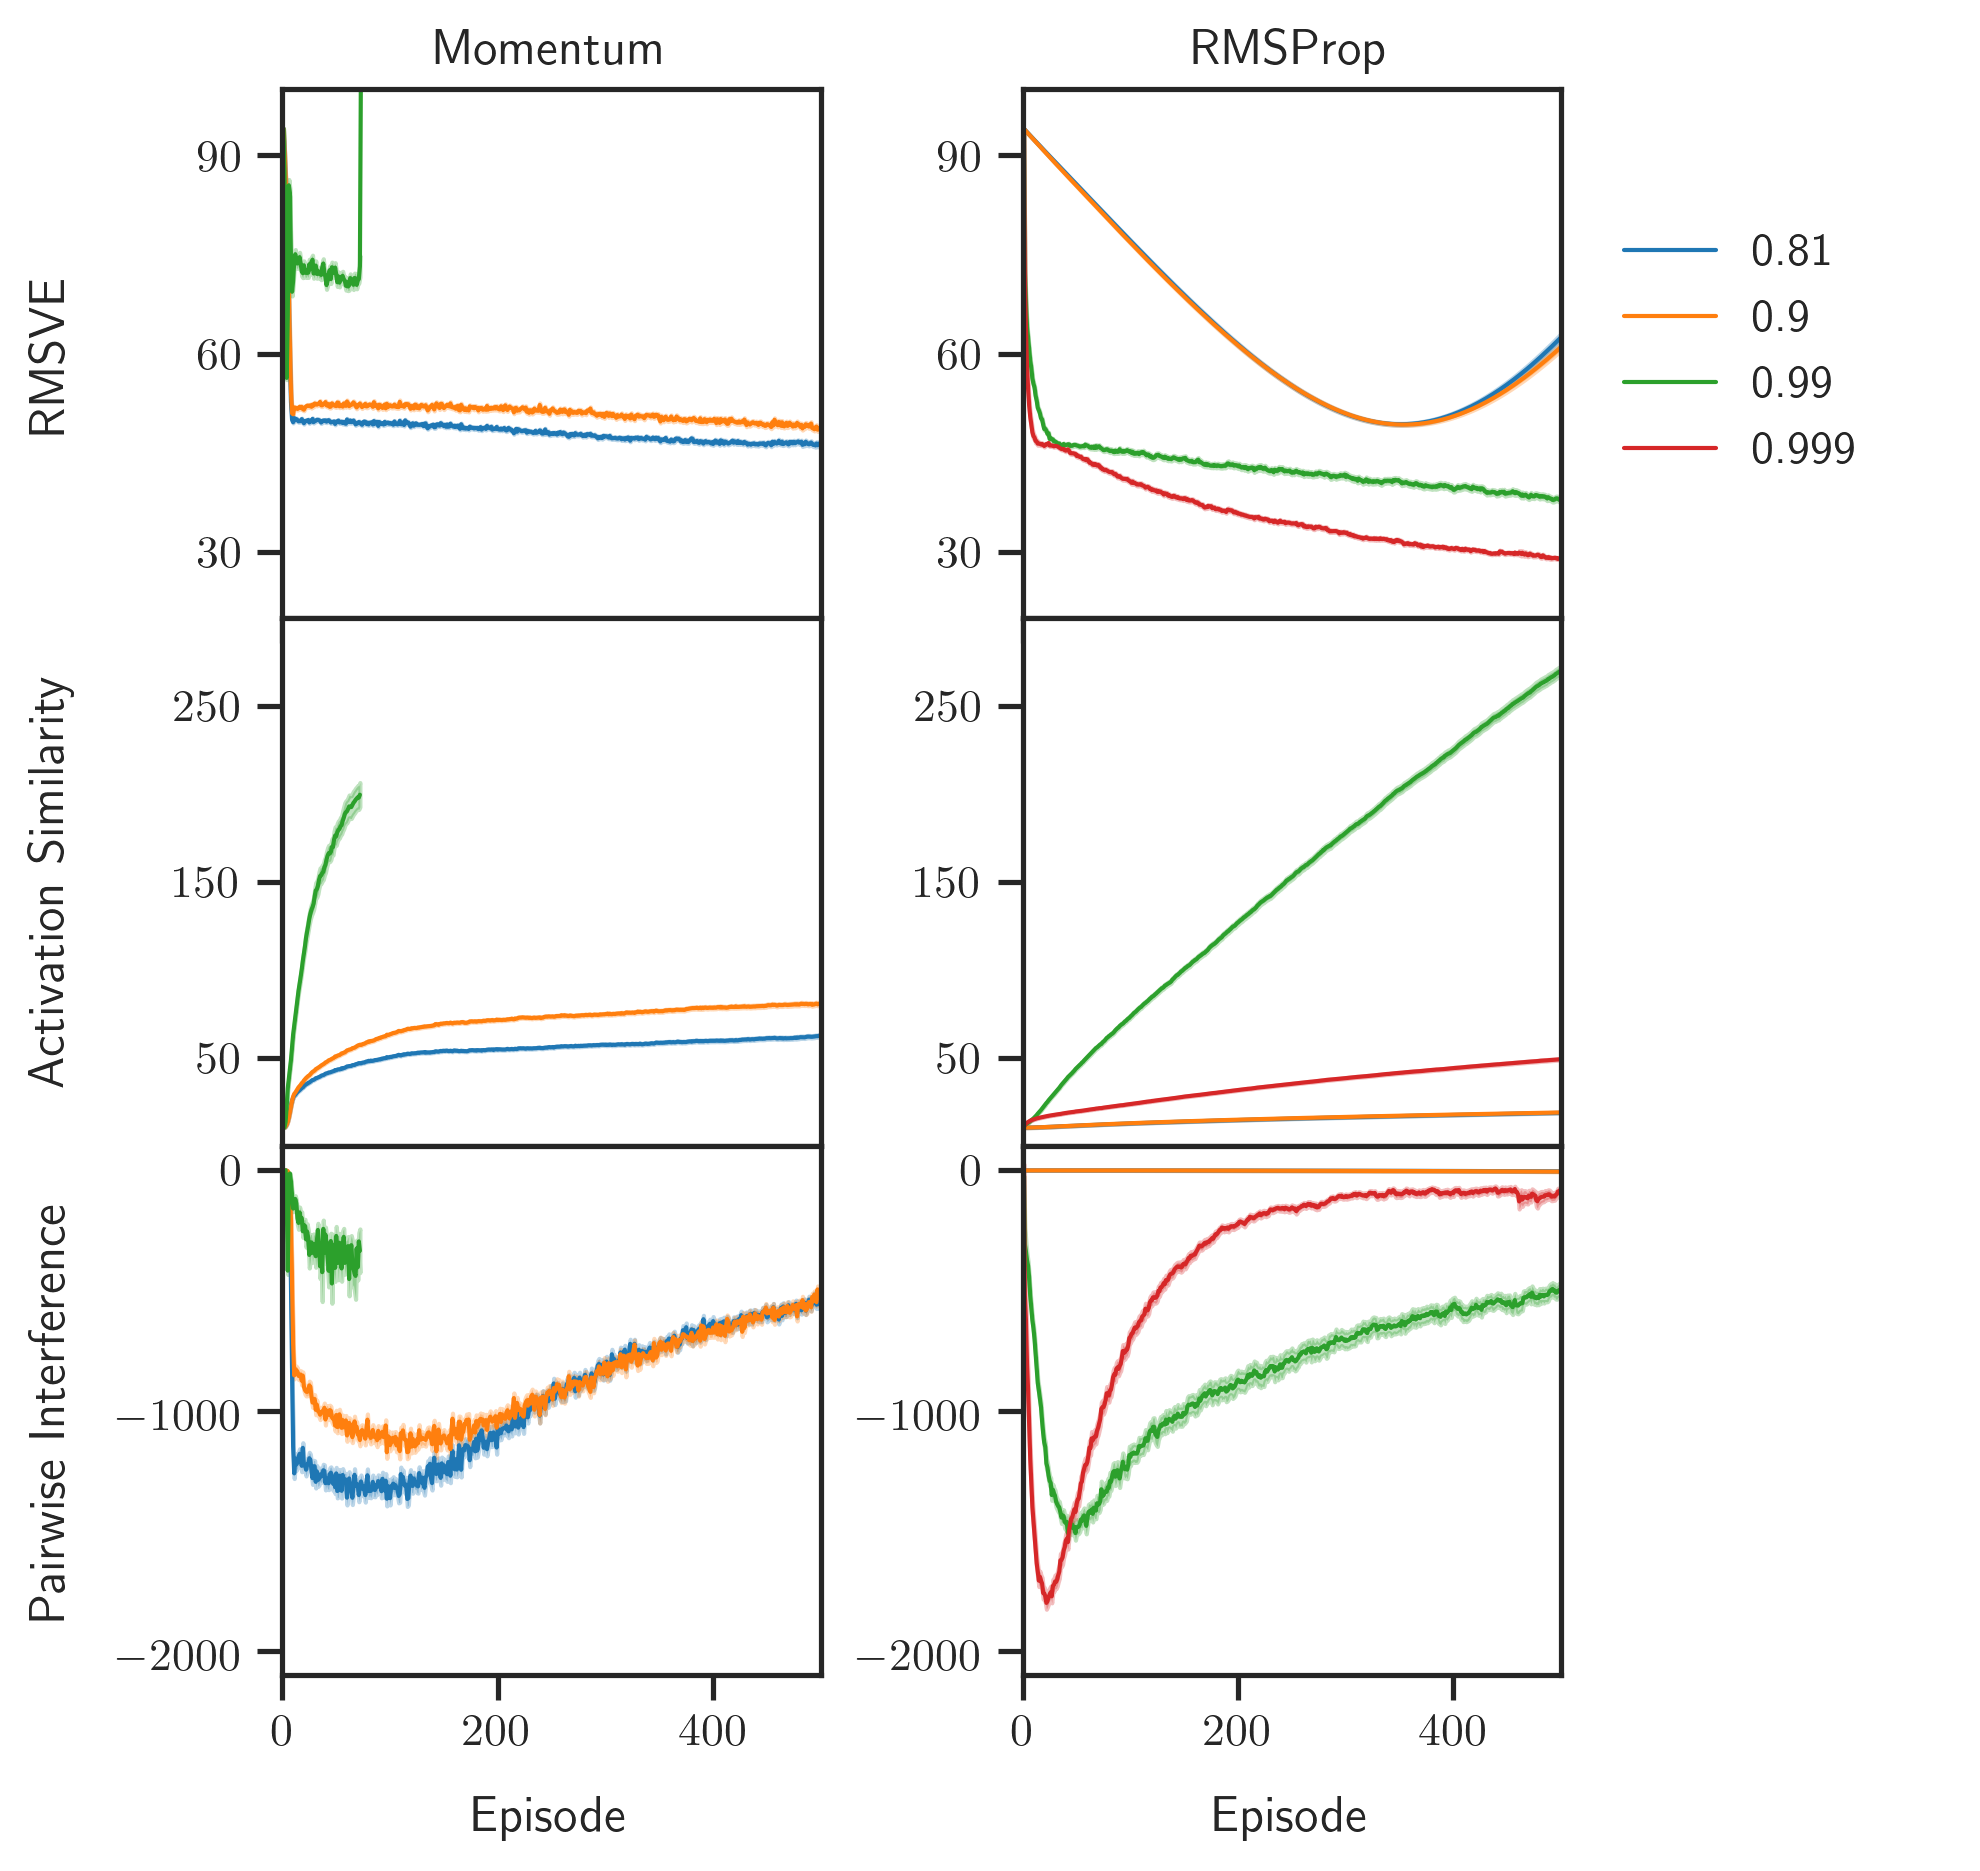

In [37]:
colors = sns.color_palette(n_colors=4)
fig, axmat = plt.subplots(3, 2, sharex=True, dpi=300, figsize=(5.5, 7))
sort_key = lambda x: '~' if x == 'constant' else x
for i, (optimizer, hyperparameter) in enumerate([('momentum', 'momentum'), ('rms', 'rho')]):
    rdf = summary[summary['optimizer'] == optimizer]
    for j, key in enumerate(['accuracy', 'activation_similarity', 'pairwise_interference']):
        hyperparameter_values = sorted(rdf[hyperparameter].unique())
        for k, hyperparameter_value in enumerate(hyperparameter_values):
            value = rdf[rdf[hyperparameter] == hyperparameter_value].iloc[0].to_dict()
            ax = axmat[j, i]
            try:
                y = value['{}_mean'.format(key)]
                yerr = value['{}_stderr'.format(key)]
                if key == 'accuracy':
                    y[np.isnan(y)] = 105
                x = np.arange(len(y)) + 1
                if (i == 1) and (j == 0):
                    label = hyperparameter_value
                else:
                    label = None
                ax.plot(
                    x,
                    y,
                    label=label,
                    linewidth=1,
                    color=colors[k])
                ax.fill_between(
                    x,
                    y - yerr,
                    y + yerr,
                    alpha=0.3,
                    color=colors[k])
            except KeyError:
                pass
axmat[0, 0].set_title('Momentum')
axmat[0, 1].set_title('RMSProp')
axmat[0, 0].set_ylabel('RMSVE', labelpad=10)
axmat[0, 0].set_ylim(20, 100)
axmat[0, 0].set_yticks([30, 60, 90])
axmat[0, 1].set_ylim(20, 100)
axmat[0, 1].set_yticks([30, 60, 90])
axmat[1, 0].set_ylabel('Activation Similarity', labelpad=10)
axmat[1, 0].set_ylim(0, 300)
axmat[1, 0].set_yticks([50, 150, 250])
axmat[1, 1].set_ylim(0, 300)
axmat[1, 1].set_yticks([50, 150, 250])
axmat[2, 0].set_ylabel('Pairwise Interference', labelpad=10)
axmat[2, 0].set_ylim(- 2100, 100)
axmat[2, 0].set_yticks([- 2000, - 1000, 0])
axmat[2, 1].set_ylim(- 2100, 100)
axmat[2, 1].set_yticks([- 2000, - 1000, 0])
for i in range(2):
    axmat[2, i].set_xlim(0, 500)
    axmat[2, i].set_xlabel('Episode', labelpad=10)
fig.align_ylabels(axmat[: ,0])
fig.legend(loc='upper right', bbox_to_anchor=(1.15, 0.8), frameon=False)
fig.subplots_adjust(hspace=0.0, wspace=0.375)
fig.savefig('experiment_2_acrobot_momentum_and_rms.pdf', bbox_inches='tight')

<a href=#top>Back to Top</a>